# Assignment 2: The Winter is here
##### This works best with epic battle music. Spoilers present.
<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Tywin Lannister was right when he said: "The great war is between death and life, ice and fire. If we loose, the night will never end"<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;It has been six months since the white walkers' army marched into the north, led by the night king himself on a dead dragon. It has been a battle like never before: never before have men faced such an enemy in battle, never before have men fought so bravely against a united threat, and never before have they been so gravely defeated.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; While Cersei is in King's landing, brave men have died fighting the great war. Among others, Tyrion is dead, Arya is dead and Jon Snow is dead, again. In a desperate battle, Daenerys leads all her forces in a final stand-off with the dead just south of Winterfell. <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Her army defeated, she is now on the run on her dragon in an air battle, being chased by two of her own dragons, the Night king and a dead Jon Snow. Suddenly, the Night king's spear hits Danny's dragon, who, raining blood and fire, falls into ice, taking the lost queen, with him. <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Daenerys opens her eyes in a strange place, a place which does not follow the rules of space and time, where the dead souls killed by the dead men are trapped, forever. But who woke her up? There stands near her, Tyrion, with Jorah, Davos, Jon Snow, and everybody else. They all indulge in a heartfelt reunion when someone yells- "But how do we get out?<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Varys sees a talking crystal close by, who asks them of completing a task, which on completion would allow them to go back to the land of the living, with the ultimate tool to defeat the white-walkers and kills the night king, the Dragon-axe. They have summoned you for help, as the task is out of their expertise, to apply a modified CNN to solve the object detection problem on the PASCAL VOC dataset. Varys, the master of whisperers, has used his talents to import the following for you:

In [1]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()
# You can ask Varys to get you more if you desire
import xml.etree.ElementTree as ET
from PIL import Image, ImageFont, ImageDraw
import glob
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from random import randint

resnet_input = 224 #size of resnet18 input images, Took it from resnet paper implementation
use_gpu = False
iou_threshold = 0.3
stride = 5

In [2]:
# Cersei chose violence, you choose your hyper-parameters wisely using validation data!
batch_size = 100
num_epochs = 5
learning_rate =  0.01
hyp_momentum = 0.9

## Build the data
The hound who was in charge for getting the data, brought you the following links:
<br/>Training and validation:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
<br/>Testing data:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
<br/>He also told you that the dataset(datascrolls :P) consists of images from of 20 classes, with detection annotations included. The JPEGImages folder houses the images, and the Annotations folder has the object-wise labels for the objects in one xml file per image. You have to extract the object information, ie. the [xmin, ymin] (the top left x,y co-ordinates) and the [xmax, ymax] (the bottom right x,y co-ordinates) of only the objects belonging to the given 20 classes(aeroplane, bicycle, boat, bottle, bus, car, cat, chair, cow, dining table, dog, horse, motorbike, person, potted plant, sheep, train, TV). For parsing the xml file, you can ask Varys to import xml.etree.ElementTree for you. <br/>
<br/> You can then ask Bronn and Jamie to organize the data as follows:
<br/> For every image in the dataset, extract/crop the object patch from the image one by one using their respective co-ordinates:[xmin, ymin, xmax, ymax], resize the image to resnet_input, and store it with its class label information. Do the same for training/validation and test datasets. <br/>
##### Important
You also have to collect data for an extra background class which stands for the class of an object which is not a part of any of the 20 classes. For this, you can crop and resize any random patches from an image. A good idea is to extract patches that have low "intersection over union" with any object present in the image frame from the 20 Pascal VOC classes. The number of background images should be roughly around those of other class objects' images. Hence the total classes turn out to be 21. This is important for applying the sliding window method later.

In [3]:
classes = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')


In [4]:
# Taken from stackoverflow for drawing random bounding boxes
def random_bbox(bbox):
    v = [randint(0, v) for v in bbox]
    left = min(v[0], v[2])
    upper = min(v[1], v[3])
    right = max(v[0], v[2])
    lower = max(v[1], v[3])
    return [left, upper, right, lower]

In [5]:
# Taken form pyimagesearch for calculating intersection over union
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = (xB - xA + 1) * (yB - yA + 1)
 
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea + np.finfo(float).eps)
 
    # return the intersection over union value
    return iou

In [6]:
def jamie_bronn_build_dataset(root, image, image_arr, class_arr, orig_image,train):
    # Begin
    filename = root.find('filename').text
    bboxarr = []
    #Loop on every object of the loop
    for objects in root.findall('object'):
        class_name = objects.find('name').text
        box_position = [int(objects.find('bndbox').find('xmin').text), \
                        int(objects.find('bndbox').find('ymin').text), \
                        int(objects.find('bndbox').find('xmax').text), \
                        int(objects.find('bndbox').find('ymax').text)]
        bboxarr.append(box_position)
        img = image.crop(box_position)
        print("In image "+filename+" found "+class_name)
        image_arr.append(img.convert('RGB'))  
        # every class name corresponds to some number in the classes array that we add to the class_name array
        class_arr.append(classes.index(class_name))
        orig_image.append(filename)
    if train:
        # Now generating background images for the given image file for training only.
        num = 0
        while(num < 1):
            bbox = image.getbbox()
            boxA = random_bbox(bbox)
            mscore = 0
            for boxB in bboxarr:
                score = (bb_intersection_over_union(boxA, boxB))
                if (score>mscore):
                    mscore = score
            if (mscore < iou_threshold):
                image_arr.append(img.crop(boxA).convert('RGB'))
                class_arr.append(classes.index('__background__'))
                orig_image.append(filename)
                num = num + 1        

In [7]:
class hound_dataset(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        # Begin
        self.image_arr  = []
        self.class_arr  = []
        self.orig_image = []
        self.transform = transform

        if(train):
            dir = root_dir + 'train/VOCdevkit/VOC2007/'
        else :
            dir = root_dir + 'test/VOCdevkit/VOC2007/'
        
        anotdir = dir + 'Annotations/'
        imdir   = dir + 'JPEGImages/'
        
        for filepath in glob.glob(anotdir+'*.xml'):
            tree = ET.parse(filepath)
            root = tree.getroot()
            filename = root.find('filename').text
            image = Image.open(imdir+filename)
            jamie_bronn_build_dataset(root, image, self.image_arr, self.class_arr, self.orig_image, train)

    def __len__(self):
        # Begin
        # return the size of the dataset (total number of images) as an integer
        # this should be rather easy if you created a mapping in __init__
        return len(self.image_arr)
        
    def __getitem__(self, idx):
        # Begin
        if self.transform is None:
            return (self.image_arr[idx], self.class_arr[idx], self.orig_image[idx])
        else:
            img_transformed = self.transform(self.image_arr[idx])
            return (img_transformed, self.class_arr[idx], self.orig_image[idx])
    

## Train the netwok
<br/>You can ask Arya to train the network on the created dataset. This will yield a classification network on the 21 classes of the VOC dataset. 

In [8]:
composed_transform = transforms.Compose([transforms.Scale((resnet_input,resnet_input)),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor()])
train_dataset = hound_dataset(root_dir='/home/eeshangd/vision_env/LELImproved/dataset/', train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = hound_dataset(root_dir='/home/eeshangd/vision_env/LELImproved/dataset/', train=False, transform=composed_transform) # Supply proper root_dir

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In image 005906.jpg found bus
In image 005906.jpg found person
In image 005906.jpg found person
In image 006141.jpg found bottle
In image 007219.jpg found tvmonitor
In image 007219.jpg found chair
In image 003260.jpg found tvmonitor
In image 003260.jpg found person
In image 003260.jpg found person
In image 003260.jpg found person
In image 005629.jpg found chair
In image 005629.jpg found chair
In image 005629.jpg found chair
In image 005629.jpg found chair
In image 005629.jpg found diningtable
In image 004438.jpg found dog
In image 004438.jpg found person
In image 004438.jpg found person
In image 004438.jpg found tvmonitor
In image 001125.jpg found car
In image 001125.jpg found car
In image 001125.jpg found car
In image 001125.jpg found person
In image 001125.jpg found person
In image 006802.jpg found train
In image 006802.jpg found person
In image 006802.jpg found person
In image 003254.jpg found bird
In image 007187.jpg found sofa
In image 007187.jpg found person
In image 007187.jpg f

In image 009792.jpg found chair
In image 009792.jpg found chair
In image 009792.jpg found person
In image 009792.jpg found person
In image 009792.jpg found person
In image 009792.jpg found person
In image 002435.jpg found boat
In image 002435.jpg found boat
In image 006321.jpg found dog
In image 006321.jpg found chair
In image 006762.jpg found motorbike
In image 006762.jpg found person
In image 006762.jpg found person
In image 003413.jpg found boat
In image 003413.jpg found boat
In image 003413.jpg found boat
In image 003413.jpg found boat
In image 003413.jpg found boat
In image 003629.jpg found pottedplant
In image 003629.jpg found pottedplant
In image 003629.jpg found pottedplant
In image 003629.jpg found pottedplant
In image 009565.jpg found sofa
In image 009565.jpg found person
In image 005453.jpg found dog
In image 005453.jpg found horse
In image 005453.jpg found horse
In image 005829.jpg found person
In image 005829.jpg found person
In image 005829.jpg found person
In image 00773

In image 000694.jpg found person
In image 000694.jpg found person
In image 000694.jpg found person
In image 000694.jpg found person
In image 000694.jpg found person
In image 005450.jpg found person
In image 007498.jpg found diningtable
In image 007498.jpg found person
In image 000122.jpg found cat
In image 002378.jpg found person
In image 002378.jpg found pottedplant
In image 002378.jpg found pottedplant
In image 002378.jpg found pottedplant
In image 002378.jpg found pottedplant
In image 002378.jpg found pottedplant
In image 005839.jpg found car
In image 005839.jpg found car
In image 001843.jpg found bottle
In image 001843.jpg found person
In image 001843.jpg found person
In image 008262.jpg found bus
In image 004796.jpg found motorbike
In image 004796.jpg found motorbike
In image 004796.jpg found person
In image 008815.jpg found cat
In image 009615.jpg found aeroplane
In image 002963.jpg found sheep
In image 003655.jpg found car
In image 003655.jpg found person
In image 005781.jpg fou

In image 001747.jpg found cat
In image 008770.jpg found aeroplane
In image 000885.jpg found bicycle
In image 000885.jpg found person
In image 009420.jpg found diningtable
In image 009420.jpg found bottle
In image 009420.jpg found bottle
In image 009420.jpg found person
In image 009420.jpg found chair
In image 009420.jpg found chair
In image 009420.jpg found chair
In image 009420.jpg found chair
In image 007939.jpg found cow
In image 005856.jpg found tvmonitor
In image 005856.jpg found person
In image 005856.jpg found person
In image 002896.jpg found bird
In image 006497.jpg found car
In image 006497.jpg found car
In image 006497.jpg found person
In image 006497.jpg found person
In image 006497.jpg found person
In image 006497.jpg found person
In image 006497.jpg found person
In image 006497.jpg found person
In image 008349.jpg found sheep
In image 006794.jpg found aeroplane
In image 003422.jpg found chair
In image 003422.jpg found person
In image 003422.jpg found person
In image 003422

In image 006570.jpg found dog
In image 006570.jpg found dog
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 008836.jpg found person
In image 004085.jpg found dog
In image 004085.jpg found person
In image 000344.jpg found bottle
In image 002783.jpg found bus
In image 002783.jpg found car
In image 002879.jpg found person
In image 004186.jpg found bus
In image 004186.jpg found bus
In image 004186.jpg found car
In image 004186.jpg found car
In image 004186.jpg found car
In image 004186.jpg found car
In image 004186.jpg found car
In image 004186.jpg found car
In image 001945.

In image 003223.jpg found boat
In image 006349.jpg found aeroplane
In image 005210.jpg found tvmonitor
In image 009813.jpg found sofa
In image 009813.jpg found person
In image 003945.jpg found bicycle
In image 003945.jpg found bicycle
In image 003945.jpg found bicycle
In image 003945.jpg found person
In image 003945.jpg found person
In image 003945.jpg found person
In image 003945.jpg found person
In image 003945.jpg found person
In image 008519.jpg found bird
In image 007388.jpg found person
In image 004581.jpg found bus
In image 004581.jpg found car
In image 004581.jpg found car
In image 009527.jpg found boat
In image 009527.jpg found boat
In image 009527.jpg found boat
In image 003204.jpg found tvmonitor
In image 006735.jpg found dog
In image 006735.jpg found person
In image 006735.jpg found person
In image 009726.jpg found person
In image 009726.jpg found person
In image 009726.jpg found person
In image 009726.jpg found bottle
In image 009726.jpg found bottle
In image 009726.jpg fo

In image 002744.jpg found person
In image 002744.jpg found person
In image 007697.jpg found horse
In image 007697.jpg found person
In image 006301.jpg found car
In image 000923.jpg found tvmonitor
In image 000923.jpg found sofa
In image 000923.jpg found pottedplant
In image 000923.jpg found pottedplant
In image 000923.jpg found tvmonitor
In image 000923.jpg found pottedplant
In image 009295.jpg found person
In image 009295.jpg found bicycle
In image 009295.jpg found tvmonitor
In image 004508.jpg found bottle
In image 004508.jpg found bottle
In image 004508.jpg found bottle
In image 004508.jpg found person
In image 004508.jpg found person
In image 005315.jpg found bicycle
In image 005315.jpg found person
In image 007621.jpg found sheep
In image 007621.jpg found sheep
In image 009272.jpg found aeroplane
In image 002502.jpg found train
In image 007376.jpg found bus
In image 007376.jpg found bus
In image 007376.jpg found car
In image 006088.jpg found chair
In image 006088.jpg found chair
I

In image 001082.jpg found pottedplant
In image 007709.jpg found person
In image 007709.jpg found person
In image 007709.jpg found bicycle
In image 007709.jpg found car
In image 007709.jpg found car
In image 007709.jpg found car
In image 007709.jpg found car
In image 008989.jpg found bottle
In image 008989.jpg found bottle
In image 008989.jpg found bottle
In image 008989.jpg found bottle
In image 008989.jpg found bottle
In image 008989.jpg found bottle
In image 008989.jpg found bottle
In image 008989.jpg found bottle
In image 008989.jpg found bottle
In image 009141.jpg found person
In image 009141.jpg found person
In image 009141.jpg found person
In image 009141.jpg found person
In image 009141.jpg found person
In image 009141.jpg found person
In image 003855.jpg found motorbike
In image 003855.jpg found person
In image 003855.jpg found person
In image 003855.jpg found person
In image 003855.jpg found bicycle
In image 003855.jpg found bicycle
In image 003855.jpg found bicycle
In image 0

In image 005306.jpg found person
In image 005306.jpg found person
In image 005306.jpg found person
In image 005306.jpg found person
In image 005306.jpg found horse
In image 003973.jpg found bus
In image 003973.jpg found car
In image 003973.jpg found person
In image 003973.jpg found person
In image 001718.jpg found dog
In image 002025.jpg found chair
In image 002025.jpg found chair
In image 002025.jpg found diningtable
In image 002689.jpg found person
In image 007465.jpg found tvmonitor
In image 004544.jpg found bus
In image 004544.jpg found car
In image 002518.jpg found person
In image 002518.jpg found person
In image 002518.jpg found person
In image 002518.jpg found bottle
In image 002518.jpg found bottle
In image 000276.jpg found person
In image 000276.jpg found person
In image 000276.jpg found person
In image 003696.jpg found horse
In image 003696.jpg found person
In image 006529.jpg found person
In image 006529.jpg found aeroplane
In image 001714.jpg found sheep
In image 002989.jpg

In image 005024.jpg found person
In image 005024.jpg found person
In image 007416.jpg found cat
In image 007416.jpg found chair
In image 002184.jpg found dog
In image 002184.jpg found dog
In image 001932.jpg found person
In image 001932.jpg found person
In image 001932.jpg found chair
In image 002678.jpg found horse
In image 002678.jpg found horse
In image 002678.jpg found person
In image 002678.jpg found person
In image 002678.jpg found person
In image 007125.jpg found boat
In image 007234.jpg found horse
In image 007234.jpg found person
In image 008556.jpg found chair
In image 001457.jpg found sofa
In image 001457.jpg found chair
In image 000565.jpg found bicycle
In image 003107.jpg found person
In image 009507.jpg found car
In image 009507.jpg found car
In image 009507.jpg found car
In image 009507.jpg found car
In image 000380.jpg found bicycle
In image 007470.jpg found aeroplane
In image 001882.jpg found sofa
In image 001882.jpg found chair
In image 004694.jpg found person
In imag

In image 006067.jpg found aeroplane
In image 006903.jpg found person
In image 006903.jpg found person
In image 006903.jpg found dog
In image 006903.jpg found dog
In image 002091.jpg found boat
In image 002091.jpg found person
In image 002091.jpg found person
In image 002091.jpg found person
In image 002091.jpg found person
In image 005032.jpg found train
In image 008512.jpg found dog
In image 003611.jpg found person
In image 003611.jpg found horse
In image 002776.jpg found bus
In image 002776.jpg found person
In image 002776.jpg found person
In image 002776.jpg found car
In image 002776.jpg found car
In image 002776.jpg found car
In image 000500.jpg found bicycle
In image 000500.jpg found person
In image 000500.jpg found person
In image 000500.jpg found person
In image 000500.jpg found person
In image 000500.jpg found person
In image 000500.jpg found person
In image 000500.jpg found person
In image 005968.jpg found dog
In image 009324.jpg found bird
In image 009324.jpg found bird
In im

In image 007071.jpg found cat
In image 008720.jpg found cat
In image 002842.jpg found horse
In image 002842.jpg found person
In image 007666.jpg found train
In image 000520.jpg found person
In image 009063.jpg found aeroplane
In image 009063.jpg found aeroplane
In image 007954.jpg found dog
In image 009780.jpg found dog
In image 009780.jpg found person
In image 009780.jpg found sofa
In image 001800.jpg found sofa
In image 001800.jpg found person
In image 005576.jpg found train
In image 002886.jpg found person
In image 002886.jpg found person
In image 002886.jpg found person
In image 002886.jpg found person
In image 008905.jpg found aeroplane
In image 007810.jpg found diningtable
In image 007810.jpg found person
In image 005811.jpg found person
In image 005811.jpg found person
In image 005811.jpg found person
In image 005811.jpg found chair
In image 006362.jpg found car
In image 006362.jpg found car
In image 000746.jpg found dog
In image 003784.jpg found bicycle
In image 000030.jpg foun

In image 000537.jpg found dog
In image 005398.jpg found motorbike
In image 005398.jpg found person
In image 005398.jpg found person
In image 006983.jpg found boat
In image 006983.jpg found person
In image 008108.jpg found motorbike
In image 008108.jpg found motorbike
In image 008108.jpg found person
In image 008108.jpg found person
In image 008108.jpg found person
In image 008108.jpg found person
In image 008108.jpg found person
In image 008108.jpg found motorbike
In image 008108.jpg found motorbike
In image 008108.jpg found motorbike
In image 008108.jpg found person
In image 008108.jpg found car
In image 006619.jpg found aeroplane
In image 000052.jpg found pottedplant
In image 000052.jpg found pottedplant
In image 000052.jpg found pottedplant
In image 000052.jpg found pottedplant
In image 000052.jpg found pottedplant
In image 000052.jpg found pottedplant
In image 009153.jpg found person
In image 005161.jpg found person
In image 005161.jpg found person
In image 005161.jpg found person


In image 002120.jpg found bird
In image 002120.jpg found person
In image 003565.jpg found bird
In image 003176.jpg found car
In image 003013.jpg found car
In image 007568.jpg found person
In image 000637.jpg found bicycle
In image 002807.jpg found motorbike
In image 002807.jpg found person
In image 005360.jpg found train
In image 005360.jpg found train
In image 002178.jpg found car
In image 004563.jpg found car
In image 004563.jpg found car
In image 004563.jpg found car
In image 004563.jpg found person
In image 004563.jpg found person
In image 004563.jpg found person
In image 001981.jpg found cat
In image 000496.jpg found diningtable
In image 000496.jpg found chair
In image 006183.jpg found cat
In image 002359.jpg found dog
In image 000464.jpg found cow
In image 000464.jpg found cow
In image 007940.jpg found person
In image 007236.jpg found bus
In image 007236.jpg found person
In image 007236.jpg found person
In image 007236.jpg found person
In image 007236.jpg found person
In image 00

In image 007484.jpg found bus
In image 007484.jpg found bus
In image 007484.jpg found bus
In image 007484.jpg found person
In image 006660.jpg found car
In image 006660.jpg found boat
In image 006660.jpg found boat
In image 008638.jpg found train
In image 008638.jpg found train
In image 008638.jpg found person
In image 000476.jpg found person
In image 000476.jpg found dog
In image 000476.jpg found sofa
In image 003255.jpg found sofa
In image 007133.jpg found car
In image 007133.jpg found car
In image 007133.jpg found car
In image 005765.jpg found person
In image 005765.jpg found person
In image 005765.jpg found person
In image 005325.jpg found boat
In image 000950.jpg found chair
In image 000950.jpg found chair
In image 000950.jpg found chair
In image 000950.jpg found chair
In image 000950.jpg found diningtable
In image 003177.jpg found dog
In image 002932.jpg found person
In image 002836.jpg found bird
In image 002836.jpg found bird
In image 008739.jpg found person
In image 008739.jpg

In image 009884.jpg found pottedplant
In image 007258.jpg found sofa
In image 005267.jpg found train
In image 002037.jpg found bird
In image 002563.jpg found person
In image 002563.jpg found car
In image 002563.jpg found person
In image 002563.jpg found person
In image 009859.jpg found person
In image 007819.jpg found train
In image 007819.jpg found car
In image 007261.jpg found car
In image 007261.jpg found car
In image 007261.jpg found person
In image 002361.jpg found pottedplant
In image 002361.jpg found person
In image 008997.jpg found diningtable
In image 008997.jpg found chair
In image 008997.jpg found chair
In image 008997.jpg found chair
In image 008997.jpg found chair
In image 008997.jpg found chair
In image 008997.jpg found chair
In image 008997.jpg found pottedplant
In image 008997.jpg found pottedplant
In image 008997.jpg found pottedplant
In image 008997.jpg found tvmonitor
In image 006375.jpg found car
In image 006375.jpg found car
In image 006375.jpg found car
In image 0

In image 007297.jpg found aeroplane
In image 003979.jpg found bird
In image 003979.jpg found bird
In image 003979.jpg found bird
In image 006230.jpg found dog
In image 008933.jpg found cat
In image 008933.jpg found pottedplant
In image 008933.jpg found pottedplant
In image 005577.jpg found car
In image 004372.jpg found horse
In image 004372.jpg found person
In image 008752.jpg found motorbike
In image 008752.jpg found person
In image 008752.jpg found person
In image 008752.jpg found person
In image 008752.jpg found person
In image 008752.jpg found person
In image 005396.jpg found tvmonitor
In image 005396.jpg found person
In image 005396.jpg found person
In image 003218.jpg found bicycle
In image 003218.jpg found bicycle
In image 003218.jpg found bicycle
In image 003218.jpg found bicycle
In image 003218.jpg found bicycle
In image 003218.jpg found bicycle
In image 003218.jpg found person
In image 003218.jpg found person
In image 003218.jpg found person
In image 003218.jpg found person
I

In image 009365.jpg found aeroplane
In image 005601.jpg found dog
In image 005601.jpg found dog
In image 003722.jpg found boat
In image 003508.jpg found dog
In image 004994.jpg found person
In image 004994.jpg found chair
In image 005585.jpg found person
In image 005585.jpg found car
In image 003660.jpg found tvmonitor
In image 008953.jpg found person
In image 008953.jpg found bottle
In image 002116.jpg found dog
In image 002116.jpg found sofa
In image 002116.jpg found sofa
In image 002116.jpg found car
In image 002116.jpg found pottedplant
In image 002116.jpg found person
In image 000549.jpg found cat
In image 000091.jpg found car
In image 000091.jpg found car
In image 000091.jpg found car
In image 004392.jpg found chair
In image 004392.jpg found chair
In image 004392.jpg found pottedplant
In image 004392.jpg found pottedplant
In image 004392.jpg found person
In image 004392.jpg found person
In image 002858.jpg found horse
In image 002858.jpg found person
In image 005658.jpg found bus

In image 001421.jpg found person
In image 001421.jpg found chair
In image 001421.jpg found diningtable
In image 005535.jpg found dog
In image 007859.jpg found sheep
In image 008557.jpg found tvmonitor
In image 008557.jpg found pottedplant
In image 008557.jpg found pottedplant
In image 008557.jpg found pottedplant
In image 008557.jpg found pottedplant
In image 008557.jpg found pottedplant
In image 008557.jpg found pottedplant
In image 008557.jpg found pottedplant
In image 008557.jpg found pottedplant
In image 008557.jpg found sofa
In image 007538.jpg found chair
In image 007128.jpg found person
In image 007128.jpg found person
In image 007128.jpg found person
In image 007128.jpg found person
In image 007128.jpg found person
In image 006055.jpg found chair
In image 006055.jpg found chair
In image 006055.jpg found chair
In image 006055.jpg found chair
In image 006055.jpg found chair
In image 006427.jpg found person
In image 006427.jpg found person
In image 006427.jpg found person
In image

In image 009458.jpg found bottle
In image 009458.jpg found bottle
In image 009458.jpg found bottle
In image 009458.jpg found bottle
In image 009458.jpg found bottle
In image 000525.jpg found motorbike
In image 000525.jpg found motorbike
In image 000525.jpg found person
In image 000525.jpg found person
In image 004706.jpg found person
In image 004706.jpg found bicycle
In image 006028.jpg found bicycle
In image 006028.jpg found person
In image 006028.jpg found person
In image 001314.jpg found cat
In image 007194.jpg found bird
In image 007194.jpg found bird
In image 007194.jpg found bird
In image 007194.jpg found bird
In image 007194.jpg found bird
In image 007194.jpg found bird
In image 007194.jpg found bird
In image 005419.jpg found horse
In image 005419.jpg found person
In image 009247.jpg found diningtable
In image 009247.jpg found chair
In image 009247.jpg found chair
In image 009247.jpg found chair
In image 009247.jpg found chair
In image 007854.jpg found bicycle
In image 007021.jp

In image 006417.jpg found car
In image 006417.jpg found car
In image 006417.jpg found car
In image 006417.jpg found car
In image 003216.jpg found dog
In image 003216.jpg found chair
In image 001559.jpg found car
In image 001559.jpg found car
In image 001559.jpg found car
In image 006864.jpg found person
In image 006864.jpg found person
In image 006864.jpg found person
In image 006864.jpg found person
In image 006947.jpg found tvmonitor
In image 000089.jpg found person
In image 000089.jpg found person
In image 000089.jpg found person
In image 000089.jpg found chair
In image 003439.jpg found cow
In image 003439.jpg found cow
In image 005285.jpg found bird
In image 005285.jpg found bird
In image 007322.jpg found dog
In image 007971.jpg found car
In image 007971.jpg found person
In image 007049.jpg found aeroplane
In image 007049.jpg found aeroplane
In image 007049.jpg found person
In image 000123.jpg found train
In image 009443.jpg found pottedplant
In image 009443.jpg found pottedplant
I

In image 000892.jpg found person
In image 000892.jpg found motorbike
In image 005961.jpg found bus
In image 005961.jpg found person
In image 005961.jpg found person
In image 005961.jpg found person
In image 005961.jpg found person
In image 005961.jpg found person
In image 005961.jpg found person
In image 007868.jpg found cat
In image 005469.jpg found sheep
In image 000222.jpg found diningtable
In image 000222.jpg found person
In image 000222.jpg found person
In image 000222.jpg found bottle
In image 000222.jpg found bottle
In image 000222.jpg found person
In image 000222.jpg found person
In image 000222.jpg found person
In image 000222.jpg found person
In image 000222.jpg found person
In image 000222.jpg found person
In image 000222.jpg found person
In image 000222.jpg found person
In image 000222.jpg found chair
In image 000222.jpg found chair
In image 000583.jpg found motorbike
In image 000583.jpg found motorbike
In image 000583.jpg found person
In image 000583.jpg found person
In im

In image 001352.jpg found person
In image 001352.jpg found person
In image 001352.jpg found person
In image 001352.jpg found person
In image 001352.jpg found person
In image 001352.jpg found person
In image 001352.jpg found person
In image 001352.jpg found person
In image 001352.jpg found person
In image 001352.jpg found chair
In image 001352.jpg found chair
In image 001352.jpg found chair
In image 001352.jpg found person
In image 001352.jpg found person
In image 001352.jpg found person
In image 001352.jpg found person
In image 001352.jpg found person
In image 001352.jpg found person
In image 001352.jpg found person
In image 001352.jpg found person
In image 001352.jpg found person
In image 001352.jpg found person
In image 001352.jpg found person
In image 001352.jpg found person
In image 001352.jpg found person
In image 001352.jpg found person
In image 001352.jpg found person
In image 001352.jpg found person
In image 001352.jpg found person
In image 001352.jpg found person
In image 0013

In image 002156.jpg found chair
In image 002156.jpg found chair
In image 002156.jpg found chair
In image 002156.jpg found chair
In image 002156.jpg found chair
In image 002156.jpg found diningtable
In image 002156.jpg found person
In image 004951.jpg found train
In image 004951.jpg found train
In image 009609.jpg found bird
In image 009609.jpg found person
In image 002534.jpg found car
In image 002534.jpg found car
In image 003103.jpg found car
In image 003576.jpg found bus
In image 003576.jpg found bus
In image 003576.jpg found motorbike
In image 003576.jpg found person
In image 003576.jpg found person
In image 003576.jpg found person
In image 003576.jpg found person
In image 003576.jpg found person
In image 005799.jpg found tvmonitor
In image 005799.jpg found person
In image 005799.jpg found person
In image 005799.jpg found person
In image 004389.jpg found horse
In image 004389.jpg found person
In image 002514.jpg found person
In image 002514.jpg found person
In image 002514.jpg foun

In image 009078.jpg found car
In image 009078.jpg found person
In image 009078.jpg found car
In image 009078.jpg found pottedplant
In image 008733.jpg found chair
In image 008733.jpg found chair
In image 008733.jpg found chair
In image 008733.jpg found chair
In image 008733.jpg found diningtable
In image 008733.jpg found pottedplant
In image 008628.jpg found chair
In image 008628.jpg found chair
In image 008628.jpg found sofa
In image 008628.jpg found person
In image 002002.jpg found chair
In image 004946.jpg found person
In image 004946.jpg found car
In image 004946.jpg found car
In image 001483.jpg found train
In image 001483.jpg found train
In image 002589.jpg found chair
In image 002589.jpg found chair
In image 002589.jpg found chair
In image 002589.jpg found sofa
In image 002589.jpg found person
In image 002589.jpg found person
In image 002589.jpg found person
In image 002589.jpg found person
In image 007244.jpg found person
In image 007244.jpg found bicycle
In image 006038.jpg fo

In image 008316.jpg found train
In image 001522.jpg found bottle
In image 001522.jpg found bottle
In image 009377.jpg found person
In image 009377.jpg found train
In image 004814.jpg found cat
In image 004555.jpg found aeroplane
In image 008061.jpg found bottle
In image 008061.jpg found bottle
In image 008061.jpg found bottle
In image 008061.jpg found bottle
In image 008061.jpg found bottle
In image 002684.jpg found horse
In image 001418.jpg found dog
In image 007721.jpg found bird
In image 007721.jpg found car
In image 007721.jpg found car
In image 007721.jpg found car
In image 005654.jpg found train
In image 003748.jpg found bird
In image 003126.jpg found bird
In image 004776.jpg found train
In image 008884.jpg found person
In image 008884.jpg found person
In image 008884.jpg found boat
In image 006726.jpg found pottedplant
In image 006400.jpg found train
In image 006400.jpg found train
In image 006400.jpg found train
In image 008822.jpg found dog
In image 000676.jpg found sheep
In i

In image 001931.jpg found car
In image 001343.jpg found tvmonitor
In image 001343.jpg found tvmonitor
In image 001343.jpg found chair
In image 001343.jpg found sofa
In image 001343.jpg found sofa
In image 005171.jpg found boat
In image 005171.jpg found boat
In image 007513.jpg found train
In image 000564.jpg found diningtable
In image 000564.jpg found bottle
In image 000564.jpg found bottle
In image 000564.jpg found bottle
In image 000564.jpg found chair
In image 000564.jpg found chair
In image 000564.jpg found chair
In image 000564.jpg found chair
In image 000564.jpg found chair
In image 000564.jpg found chair
In image 008438.jpg found bird
In image 008876.jpg found person
In image 008876.jpg found horse
In image 005818.jpg found person
In image 005818.jpg found person
In image 001617.jpg found motorbike
In image 001617.jpg found motorbike
In image 001617.jpg found motorbike
In image 001617.jpg found person
In image 001617.jpg found person
In image 001617.jpg found person
In image 001

In image 001272.jpg found bottle
In image 001272.jpg found bottle
In image 001272.jpg found person
In image 004067.jpg found motorbike
In image 004067.jpg found motorbike
In image 004067.jpg found motorbike
In image 004067.jpg found person
In image 004067.jpg found person
In image 004067.jpg found person
In image 006829.jpg found dog
In image 004141.jpg found cow
In image 004141.jpg found cow
In image 004141.jpg found person
In image 008175.jpg found person
In image 008175.jpg found person
In image 008175.jpg found sofa
In image 009596.jpg found motorbike
In image 009596.jpg found motorbike
In image 009596.jpg found motorbike
In image 009596.jpg found motorbike
In image 009596.jpg found motorbike
In image 009596.jpg found person
In image 009596.jpg found person
In image 009596.jpg found person
In image 009596.jpg found person
In image 009596.jpg found person
In image 009596.jpg found person
In image 009596.jpg found person
In image 009596.jpg found person
In image 009596.jpg found car


In image 006583.jpg found person
In image 006583.jpg found tvmonitor
In image 006583.jpg found tvmonitor
In image 006344.jpg found train
In image 006344.jpg found person
In image 006344.jpg found person
In image 006344.jpg found person
In image 007100.jpg found tvmonitor
In image 007100.jpg found tvmonitor
In image 004753.jpg found chair
In image 004753.jpg found person
In image 004753.jpg found person
In image 004753.jpg found bottle
In image 005078.jpg found cat
In image 002117.jpg found tvmonitor
In image 002117.jpg found dog
In image 002117.jpg found person
In image 002117.jpg found dog
In image 002117.jpg found person
In image 002117.jpg found person
In image 009358.jpg found bus
In image 009358.jpg found car
In image 009358.jpg found car
In image 009358.jpg found person
In image 009299.jpg found diningtable
In image 009299.jpg found person
In image 009299.jpg found person
In image 009299.jpg found person
In image 009299.jpg found bottle
In image 009299.jpg found bottle
In image 0

In image 000036.jpg found dog
In image 006806.jpg found pottedplant
In image 006806.jpg found pottedplant
In image 006806.jpg found pottedplant
In image 006806.jpg found pottedplant
In image 009016.jpg found bottle
In image 008930.jpg found cat
In image 007925.jpg found bicycle
In image 007925.jpg found pottedplant
In image 007925.jpg found pottedplant
In image 007925.jpg found pottedplant
In image 006374.jpg found aeroplane
In image 002826.jpg found dog
In image 002826.jpg found dog
In image 002826.jpg found person
In image 002826.jpg found person
In image 002826.jpg found person
In image 002826.jpg found dog
In image 009200.jpg found tvmonitor
In image 009200.jpg found tvmonitor
In image 009200.jpg found chair
In image 009200.jpg found sofa
In image 008550.jpg found car
In image 008550.jpg found car
In image 008550.jpg found person
In image 008550.jpg found person
In image 008550.jpg found person
In image 008550.jpg found person
In image 008550.jpg found person
In image 008550.jpg fo

In image 009411.jpg found car
In image 009411.jpg found person
In image 006240.jpg found person
In image 008645.jpg found boat
In image 002987.jpg found bus
In image 002987.jpg found person
In image 008063.jpg found chair
In image 008063.jpg found chair
In image 008063.jpg found chair
In image 006958.jpg found dog
In image 006958.jpg found person
In image 006958.jpg found diningtable
In image 005825.jpg found boat
In image 001765.jpg found motorbike
In image 009187.jpg found train
In image 004742.jpg found diningtable
In image 004742.jpg found bottle
In image 004742.jpg found bottle
In image 004742.jpg found bottle
In image 004742.jpg found bottle
In image 004742.jpg found bottle
In image 004742.jpg found pottedplant
In image 004742.jpg found chair
In image 004742.jpg found person
In image 004742.jpg found person
In image 004742.jpg found person
In image 004742.jpg found person
In image 009155.jpg found tvmonitor
In image 000713.jpg found boat
In image 000713.jpg found boat
In image 00

In image 007653.jpg found car
In image 007653.jpg found person
In image 008300.jpg found aeroplane
In image 003845.jpg found sofa
In image 004229.jpg found motorbike
In image 004229.jpg found person
In image 007276.jpg found train
In image 007276.jpg found person
In image 007525.jpg found car
In image 004911.jpg found train
In image 004911.jpg found train
In image 000689.jpg found train
In image 008093.jpg found car
In image 003706.jpg found motorbike
In image 003706.jpg found person
In image 003706.jpg found person
In image 005003.jpg found car
In image 001402.jpg found sofa
In image 001402.jpg found sofa
In image 001402.jpg found bicycle
In image 005365.jpg found dog
In image 003589.jpg found bicycle
In image 003589.jpg found person
In image 003589.jpg found person
In image 003589.jpg found person
In image 003589.jpg found person
In image 003589.jpg found person
In image 003589.jpg found person
In image 003589.jpg found person
In image 003589.jpg found person
In image 003589.jpg foun

In image 001590.jpg found bottle
In image 001590.jpg found tvmonitor
In image 004014.jpg found chair
In image 004014.jpg found person
In image 008592.jpg found sheep
In image 008592.jpg found sheep
In image 008592.jpg found bottle
In image 008592.jpg found bottle
In image 008592.jpg found person
In image 008592.jpg found person
In image 008592.jpg found person
In image 008592.jpg found person
In image 002182.jpg found car
In image 002109.jpg found cat
In image 000635.jpg found train
In image 000635.jpg found train
In image 003690.jpg found sofa
In image 003690.jpg found person
In image 002841.jpg found person
In image 002841.jpg found person
In image 002241.jpg found car
In image 002241.jpg found car
In image 002241.jpg found car
In image 002241.jpg found person
In image 002241.jpg found person
In image 002241.jpg found person
In image 002241.jpg found person
In image 002241.jpg found person
In image 002241.jpg found person
In image 000438.jpg found person
In image 000120.jpg found dog

In image 006584.jpg found person
In image 006584.jpg found person
In image 006584.jpg found person
In image 006584.jpg found person
In image 006584.jpg found person
In image 006584.jpg found person
In image 006584.jpg found person
In image 006584.jpg found person
In image 006584.jpg found person
In image 006584.jpg found person
In image 003231.jpg found car
In image 003134.jpg found person
In image 003134.jpg found person
In image 003134.jpg found person
In image 005298.jpg found person
In image 005298.jpg found person
In image 009810.jpg found car
In image 009833.jpg found chair
In image 009833.jpg found chair
In image 009833.jpg found chair
In image 009833.jpg found chair
In image 009833.jpg found chair
In image 009833.jpg found chair
In image 009833.jpg found chair
In image 009833.jpg found chair
In image 009833.jpg found chair
In image 009894.jpg found train
In image 005086.jpg found chair
In image 005086.jpg found person
In image 005086.jpg found person
In image 005086.jpg found d

In image 005593.jpg found car
In image 005593.jpg found person
In image 005593.jpg found person
In image 005593.jpg found person
In image 007318.jpg found person
In image 005566.jpg found car
In image 005566.jpg found car
In image 005566.jpg found car
In image 005566.jpg found car
In image 001027.jpg found chair
In image 001027.jpg found chair
In image 001027.jpg found chair
In image 001027.jpg found chair
In image 001027.jpg found sofa
In image 001027.jpg found bicycle
In image 001027.jpg found tvmonitor
In image 006475.jpg found bird
In image 006475.jpg found bird
In image 006475.jpg found bird
In image 006475.jpg found person
In image 002345.jpg found dog
In image 005660.jpg found train
In image 005660.jpg found person
In image 006652.jpg found train
In image 002401.jpg found person
In image 003145.jpg found person
In image 003145.jpg found person
In image 004396.jpg found aeroplane
In image 002683.jpg found sheep
In image 005790.jpg found diningtable
In image 005790.jpg found perso

In image 002529.jpg found diningtable
In image 002529.jpg found person
In image 009461.jpg found aeroplane
In image 009461.jpg found aeroplane
In image 002135.jpg found car
In image 002135.jpg found car
In image 002135.jpg found car
In image 002135.jpg found car
In image 002135.jpg found car
In image 002135.jpg found car
In image 002135.jpg found car
In image 008235.jpg found train
In image 006272.jpg found person
In image 006272.jpg found motorbike
In image 005404.jpg found cow
In image 003808.jpg found tvmonitor
In image 000296.jpg found car
In image 000296.jpg found boat
In image 009667.jpg found bicycle
In image 000726.jpg found bottle
In image 000726.jpg found person
In image 000726.jpg found person
In image 002893.jpg found motorbike
In image 009946.jpg found person
In image 009946.jpg found person
In image 009946.jpg found person
In image 009946.jpg found train
In image 009718.jpg found train
In image 009718.jpg found car
In image 009718.jpg found car
In image 009718.jpg found c

In image 007649.jpg found person
In image 007649.jpg found person
In image 007649.jpg found bottle
In image 003146.jpg found pottedplant
In image 003651.jpg found train
In image 003651.jpg found person
In image 003092.jpg found car
In image 009717.jpg found cow
In image 009717.jpg found cow
In image 009717.jpg found cow
In image 009717.jpg found cow
In image 009717.jpg found boat
In image 009717.jpg found boat
In image 009717.jpg found boat
In image 009717.jpg found boat
In image 009717.jpg found boat
In image 009717.jpg found boat
In image 009717.jpg found boat
In image 009717.jpg found boat
In image 009717.jpg found person
In image 008466.jpg found car
In image 001837.jpg found person
In image 001837.jpg found person
In image 001837.jpg found person
In image 001837.jpg found chair
In image 001837.jpg found chair
In image 001512.jpg found bird
In image 006564.jpg found aeroplane
In image 008151.jpg found sofa
In image 008151.jpg found sofa
In image 008151.jpg found chair
In image 0089

In image 001060.jpg found car
In image 001060.jpg found bicycle
In image 001060.jpg found person
In image 000934.jpg found aeroplane
In image 007180.jpg found sofa
In image 007180.jpg found cat
In image 007180.jpg found pottedplant
In image 007180.jpg found pottedplant
In image 007180.jpg found pottedplant
In image 007180.jpg found chair
In image 004985.jpg found cat
In image 004985.jpg found person
In image 001432.jpg found car
In image 004274.jpg found tvmonitor
In image 004274.jpg found pottedplant
In image 005176.jpg found person
In image 005176.jpg found person
In image 005176.jpg found person
In image 005176.jpg found person
In image 008386.jpg found tvmonitor
In image 008386.jpg found tvmonitor
In image 008386.jpg found chair
In image 005783.jpg found motorbike
In image 005783.jpg found motorbike
In image 004542.jpg found person
In image 004542.jpg found person
In image 004542.jpg found person
In image 004542.jpg found person
In image 004542.jpg found sofa
In image 003622.jpg fo

In image 004253.jpg found chair
In image 004253.jpg found chair
In image 004253.jpg found chair
In image 004253.jpg found chair
In image 004253.jpg found diningtable
In image 007713.jpg found bird
In image 000208.jpg found diningtable
In image 000208.jpg found chair
In image 000208.jpg found chair
In image 000208.jpg found chair
In image 000208.jpg found chair
In image 000208.jpg found sofa
In image 007691.jpg found car
In image 007050.jpg found cat
In image 009333.jpg found tvmonitor
In image 009333.jpg found dog
In image 009333.jpg found sofa
In image 009333.jpg found chair
In image 009917.jpg found diningtable
In image 009917.jpg found chair
In image 009917.jpg found chair
In image 009917.jpg found person
In image 009917.jpg found person
In image 009917.jpg found bottle
In image 005363.jpg found sheep
In image 005657.jpg found person
In image 004129.jpg found cat
In image 001074.jpg found bird
In image 009819.jpg found diningtable
In image 009819.jpg found chair
In image 009819.jpg 

In image 003623.jpg found bird
In image 001858.jpg found aeroplane
In image 005838.jpg found cat
In image 000774.jpg found train
In image 003588.jpg found chair
In image 003588.jpg found chair
In image 009336.jpg found car
In image 009336.jpg found car
In image 009336.jpg found person
In image 009336.jpg found person
In image 003915.jpg found dog
In image 003915.jpg found person
In image 003915.jpg found person
In image 006066.jpg found sofa
In image 006066.jpg found chair
In image 006066.jpg found tvmonitor
In image 007359.jpg found tvmonitor
In image 007359.jpg found person
In image 005269.jpg found train
In image 005269.jpg found person
In image 005620.jpg found aeroplane
In image 002444.jpg found person
In image 002444.jpg found person
In image 002444.jpg found bottle
In image 002444.jpg found bottle
In image 006233.jpg found person
In image 005248.jpg found person
In image 005248.jpg found horse
In image 000931.jpg found boat
In image 001151.jpg found dog
In image 001151.jpg found

In image 005130.jpg found bird
In image 002481.jpg found person
In image 004662.jpg found horse
In image 004662.jpg found person
In image 009197.jpg found dog
In image 009197.jpg found person
In image 009197.jpg found person
In image 006025.jpg found aeroplane
In image 004912.jpg found bicycle
In image 004912.jpg found chair
In image 004912.jpg found chair
In image 002367.jpg found person
In image 002367.jpg found motorbike
In image 008744.jpg found person
In image 008744.jpg found horse
In image 008558.jpg found dog
In image 008558.jpg found dog
In image 008558.jpg found dog
In image 006367.jpg found bird
In image 003620.jpg found cat
In image 001362.jpg found person
In image 001362.jpg found sofa
In image 002737.jpg found aeroplane
In image 001341.jpg found bird
In image 007781.jpg found pottedplant
In image 007618.jpg found person
In image 004488.jpg found car
In image 004488.jpg found car
In image 004488.jpg found car
In image 003608.jpg found car
In image 005389.jpg found train
In

In image 004562.jpg found person
In image 004562.jpg found person
In image 004562.jpg found sofa
In image 001699.jpg found horse
In image 001699.jpg found car
In image 007536.jpg found sofa
In image 007536.jpg found sofa
In image 006318.jpg found cat
In image 003638.jpg found chair
In image 003638.jpg found diningtable
In image 003638.jpg found person
In image 003638.jpg found person
In image 003638.jpg found person
In image 003638.jpg found person
In image 002924.jpg found pottedplant
In image 002924.jpg found cat
In image 008076.jpg found diningtable
In image 008076.jpg found chair
In image 008076.jpg found chair
In image 008076.jpg found chair
In image 008076.jpg found tvmonitor
In image 008076.jpg found sofa
In image 003271.jpg found car
In image 006628.jpg found chair
In image 006628.jpg found chair
In image 006628.jpg found chair
In image 006628.jpg found chair
In image 006628.jpg found chair
In image 006628.jpg found chair
In image 006628.jpg found chair
In image 006628.jpg foun

In image 002460.jpg found bicycle
In image 002460.jpg found person
In image 007991.jpg found bird
In image 004430.jpg found bicycle
In image 005812.jpg found dog
In image 005812.jpg found dog
In image 001004.jpg found bird
In image 000165.jpg found person
In image 002542.jpg found person
In image 002542.jpg found person
In image 002542.jpg found person
In image 002542.jpg found person
In image 002542.jpg found diningtable
In image 002542.jpg found chair
In image 002542.jpg found chair
In image 002542.jpg found pottedplant
In image 002542.jpg found pottedplant
In image 002542.jpg found pottedplant
In image 002542.jpg found pottedplant
In image 002542.jpg found pottedplant
In image 004850.jpg found car
In image 008809.jpg found cat
In image 002369.jpg found cow
In image 005906.jpg found bus
In image 005906.jpg found person
In image 005906.jpg found person
In image 004213.jpg found motorbike
In image 004213.jpg found person
In image 004213.jpg found person
In image 000059.jpg found tvmoni

In image 002822.jpg found aeroplane
In image 003876.jpg found aeroplane
In image 007354.jpg found person
In image 007354.jpg found chair
In image 007354.jpg found tvmonitor
In image 007820.jpg found aeroplane
In image 007820.jpg found aeroplane
In image 001682.jpg found person
In image 001682.jpg found person
In image 001682.jpg found bottle
In image 003913.jpg found person
In image 003913.jpg found person
In image 006459.jpg found horse
In image 006459.jpg found person
In image 006459.jpg found person
In image 006459.jpg found person
In image 006459.jpg found person
In image 006459.jpg found person
In image 006459.jpg found car
In image 006459.jpg found car
In image 009031.jpg found sheep
In image 009031.jpg found sheep
In image 009031.jpg found sheep
In image 009031.jpg found sheep
In image 009597.jpg found train
In image 003298.jpg found person
In image 003030.jpg found cow
In image 001378.jpg found person
In image 001378.jpg found bird
In image 006235.jpg found car
In image 006235.

In image 009607.jpg found bird
In image 009607.jpg found bird
In image 006321.jpg found dog
In image 006321.jpg found chair
In image 006598.jpg found dog
In image 006598.jpg found person
In image 008622.jpg found car
In image 008622.jpg found car
In image 006762.jpg found motorbike
In image 006762.jpg found person
In image 006762.jpg found person
In image 001044.jpg found dog
In image 001044.jpg found dog
In image 003683.jpg found car
In image 003413.jpg found boat
In image 003413.jpg found boat
In image 003413.jpg found boat
In image 003413.jpg found boat
In image 003413.jpg found boat
In image 003629.jpg found pottedplant
In image 003629.jpg found pottedplant
In image 003629.jpg found pottedplant
In image 003629.jpg found pottedplant
In image 009565.jpg found sofa
In image 009565.jpg found person
In image 003018.jpg found person
In image 005453.jpg found dog
In image 005453.jpg found horse
In image 005453.jpg found horse
In image 004888.jpg found cat
In image 004888.jpg found cat
In 

In image 006329.jpg found car
In image 003511.jpg found bicycle
In image 008673.jpg found chair
In image 008673.jpg found bicycle
In image 007602.jpg found cow
In image 007602.jpg found cow
In image 007602.jpg found cow
In image 007602.jpg found cow
In image 001436.jpg found aeroplane
In image 000229.jpg found diningtable
In image 000229.jpg found person
In image 000229.jpg found person
In image 000229.jpg found person
In image 000229.jpg found person
In image 000229.jpg found person
In image 000229.jpg found person
In image 000229.jpg found person
In image 000229.jpg found bottle
In image 000229.jpg found bottle
In image 000229.jpg found chair
In image 007747.jpg found tvmonitor
In image 007747.jpg found sofa
In image 007747.jpg found diningtable
In image 007747.jpg found chair
In image 006413.jpg found bicycle
In image 006413.jpg found person
In image 004567.jpg found sofa
In image 004567.jpg found chair
In image 000987.jpg found person
In image 000987.jpg found person
In image 00098

In image 000828.jpg found person
In image 000828.jpg found person
In image 000828.jpg found person
In image 000828.jpg found person
In image 000828.jpg found person
In image 000828.jpg found person
In image 007312.jpg found dog
In image 007312.jpg found dog
In image 003791.jpg found chair
In image 003791.jpg found chair
In image 003791.jpg found chair
In image 003791.jpg found chair
In image 003791.jpg found chair
In image 003791.jpg found diningtable
In image 003791.jpg found diningtable
In image 003791.jpg found pottedplant
In image 003791.jpg found pottedplant
In image 006212.jpg found aeroplane
In image 001926.jpg found bird
In image 001926.jpg found bird
In image 004101.jpg found sofa
In image 004101.jpg found person
In image 004101.jpg found bicycle
In image 004101.jpg found bicycle
In image 004101.jpg found bicycle
In image 004066.jpg found sofa
In image 006863.jpg found horse
In image 006863.jpg found horse
In image 006863.jpg found horse
In image 006863.jpg found horse
In imag

In image 005034.jpg found aeroplane
In image 002676.jpg found cow
In image 002676.jpg found cow
In image 002676.jpg found cow
In image 002676.jpg found cow
In image 002676.jpg found cow
In image 002676.jpg found cow
In image 002676.jpg found cow
In image 004695.jpg found chair
In image 004695.jpg found sofa
In image 001974.jpg found boat
In image 001974.jpg found cow
In image 001974.jpg found person
In image 001974.jpg found person
In image 001974.jpg found person
In image 001974.jpg found person
In image 001974.jpg found person
In image 001974.jpg found boat
In image 008349.jpg found sheep
In image 006794.jpg found aeroplane
In image 003422.jpg found chair
In image 003422.jpg found person
In image 003422.jpg found person
In image 003422.jpg found person
In image 003422.jpg found diningtable
In image 006428.jpg found horse
In image 006428.jpg found person
In image 006428.jpg found person
In image 007740.jpg found bottle
In image 007740.jpg found bottle
In image 007740.jpg found bottle


In image 008057.jpg found car
In image 000838.jpg found bird
In image 001257.jpg found dog
In image 008119.jpg found sofa
In image 009925.jpg found pottedplant
In image 008646.jpg found chair
In image 008646.jpg found chair
In image 002001.jpg found aeroplane
In image 002001.jpg found aeroplane
In image 002001.jpg found aeroplane
In image 002001.jpg found aeroplane
In image 002001.jpg found aeroplane
In image 002591.jpg found person
In image 002591.jpg found person
In image 002591.jpg found person
In image 002591.jpg found person
In image 004316.jpg found cat
In image 000248.jpg found person
In image 000248.jpg found horse
In image 007534.jpg found sheep
In image 007534.jpg found sheep
In image 001054.jpg found dog
In image 007457.jpg found person
In image 007457.jpg found bottle
In image 005399.jpg found person
In image 005399.jpg found person
In image 007802.jpg found dog
In image 009771.jpg found cow
In image 009771.jpg found cow
In image 006370.jpg found person
In image 006370.jpg 

In image 003803.jpg found bird
In image 003325.jpg found dog
In image 003325.jpg found dog
In image 008980.jpg found dog
In image 006951.jpg found motorbike
In image 006951.jpg found person
In image 006821.jpg found bus
In image 006821.jpg found car
In image 006821.jpg found car
In image 006821.jpg found car
In image 006821.jpg found car
In image 006821.jpg found person
In image 008886.jpg found horse
In image 008886.jpg found person
In image 005598.jpg found bus
In image 009678.jpg found bus
In image 005939.jpg found cat
In image 005939.jpg found sofa
In image 009262.jpg found aeroplane
In image 000006.jpg found pottedplant
In image 000006.jpg found diningtable
In image 000006.jpg found chair
In image 000006.jpg found chair
In image 000006.jpg found chair
In image 000006.jpg found chair
In image 000006.jpg found chair
In image 000006.jpg found chair
In image 003916.jpg found car
In image 009214.jpg found bicycle
In image 009214.jpg found car
In image 009214.jpg found person
In image 0

In image 004581.jpg found bus
In image 004581.jpg found car
In image 004581.jpg found car
In image 009527.jpg found boat
In image 009527.jpg found boat
In image 009527.jpg found boat
In image 003204.jpg found tvmonitor
In image 005240.jpg found train
In image 005240.jpg found person
In image 006735.jpg found dog
In image 006735.jpg found person
In image 006735.jpg found person
In image 000237.jpg found person
In image 000237.jpg found horse
In image 009726.jpg found person
In image 009726.jpg found person
In image 009726.jpg found person
In image 009726.jpg found bottle
In image 009726.jpg found bottle
In image 009726.jpg found diningtable
In image 009726.jpg found diningtable
In image 009726.jpg found person
In image 005796.jpg found person
In image 005796.jpg found tvmonitor
In image 008047.jpg found tvmonitor
In image 008047.jpg found car
In image 008047.jpg found car
In image 008047.jpg found car
In image 008047.jpg found car
In image 001349.jpg found bottle
In image 004491.jpg fou

In image 005432.jpg found car
In image 009906.jpg found tvmonitor
In image 009906.jpg found tvmonitor
In image 009906.jpg found tvmonitor
In image 009906.jpg found tvmonitor
In image 009488.jpg found bird
In image 003455.jpg found aeroplane
In image 003455.jpg found person
In image 008493.jpg found dog
In image 008493.jpg found chair
In image 008493.jpg found chair
In image 008493.jpg found chair
In image 008493.jpg found chair
In image 008493.jpg found dog
In image 002572.jpg found bottle
In image 002572.jpg found bottle
In image 002572.jpg found chair
In image 002572.jpg found chair
In image 002572.jpg found chair
In image 002572.jpg found person
In image 002572.jpg found person
In image 002572.jpg found person
In image 002572.jpg found person
In image 002572.jpg found person
In image 002572.jpg found person
In image 002572.jpg found person
In image 002572.jpg found person
In image 002572.jpg found person
In image 002572.jpg found person
In image 007942.jpg found horse
In image 00794

In image 008925.jpg found bottle
In image 008925.jpg found bottle
In image 008925.jpg found bottle
In image 008925.jpg found bottle
In image 006088.jpg found chair
In image 006088.jpg found chair
In image 006088.jpg found sofa
In image 006088.jpg found sofa
In image 006088.jpg found sofa
In image 006088.jpg found pottedplant
In image 003699.jpg found sofa
In image 003699.jpg found pottedplant
In image 003699.jpg found pottedplant
In image 003699.jpg found pottedplant
In image 003699.jpg found pottedplant
In image 003699.jpg found pottedplant
In image 003699.jpg found person
In image 002928.jpg found chair
In image 004649.jpg found train
In image 004649.jpg found train
In image 004649.jpg found train
In image 007631.jpg found person
In image 007631.jpg found person
In image 007631.jpg found bottle
In image 007631.jpg found bottle
In image 007631.jpg found bottle
In image 007631.jpg found person
In image 007631.jpg found person
In image 007631.jpg found chair
In image 007631.jpg found ch

In image 009382.jpg found person
In image 009382.jpg found person
In image 006725.jpg found cat
In image 006793.jpg found horse
In image 006793.jpg found person
In image 006793.jpg found car
In image 004582.jpg found sheep
In image 004582.jpg found sheep
In image 001954.jpg found car
In image 001954.jpg found car
In image 001954.jpg found car
In image 001954.jpg found car
In image 000082.jpg found car
In image 000082.jpg found car
In image 003217.jpg found car
In image 003217.jpg found person
In image 009314.jpg found bus
In image 009314.jpg found person
In image 009314.jpg found person
In image 009314.jpg found person
In image 009314.jpg found person
In image 000360.jpg found cow
In image 000360.jpg found cow
In image 000360.jpg found cow
In image 000360.jpg found cow
In image 008978.jpg found car
In image 006673.jpg found boat
In image 006673.jpg found boat
In image 006673.jpg found boat
In image 006673.jpg found boat
In image 006673.jpg found boat
In image 006673.jpg found boat
In i

In image 003684.jpg found motorbike
In image 008921.jpg found person
In image 008123.jpg found bird
In image 006955.jpg found car
In image 006955.jpg found car
In image 006955.jpg found car
In image 003313.jpg found car
In image 003313.jpg found person
In image 003313.jpg found person
In image 003313.jpg found person
In image 003313.jpg found person
In image 007835.jpg found tvmonitor
In image 007835.jpg found chair
In image 007835.jpg found chair
In image 007835.jpg found person
In image 007835.jpg found car
In image 007835.jpg found car
In image 007835.jpg found car
In image 009396.jpg found car
In image 009396.jpg found car
In image 008090.jpg found cow
In image 008090.jpg found cow
In image 008090.jpg found cow
In image 008090.jpg found cow
In image 008090.jpg found cow
In image 008090.jpg found cow
In image 008417.jpg found sofa
In image 007895.jpg found person
In image 007895.jpg found dog
In image 003758.jpg found pottedplant
In image 003758.jpg found pottedplant
In image 001564

In image 002723.jpg found motorbike
In image 002723.jpg found motorbike
In image 002723.jpg found motorbike
In image 002723.jpg found motorbike
In image 002723.jpg found person
In image 007065.jpg found bird
In image 006237.jpg found horse
In image 006237.jpg found person
In image 009315.jpg found bus
In image 009315.jpg found bus
In image 009654.jpg found person
In image 009654.jpg found bottle
In image 007586.jpg found train
In image 007586.jpg found person
In image 007586.jpg found person
In image 007586.jpg found person
In image 007586.jpg found person
In image 007586.jpg found person
In image 001092.jpg found dog
In image 001092.jpg found person
In image 005578.jpg found sheep
In image 005578.jpg found sheep
In image 000440.jpg found car
In image 003138.jpg found person
In image 003138.jpg found person
In image 003138.jpg found person
In image 008652.jpg found person
In image 008652.jpg found person
In image 008652.jpg found person
In image 007608.jpg found bird
In image 008420.jp

In image 004422.jpg found pottedplant
In image 002062.jpg found tvmonitor
In image 002062.jpg found person
In image 002062.jpg found person
In image 008684.jpg found car
In image 001118.jpg found person
In image 001118.jpg found person
In image 001118.jpg found person
In image 001118.jpg found person
In image 001118.jpg found person
In image 007036.jpg found person
In image 007036.jpg found person
In image 007036.jpg found person
In image 007036.jpg found person
In image 005642.jpg found bicycle
In image 004373.jpg found bird
In image 004373.jpg found bird
In image 004373.jpg found bird
In image 004373.jpg found bird
In image 004373.jpg found bird
In image 004373.jpg found bird
In image 003831.jpg found person
In image 003831.jpg found person
In image 008620.jpg found dog
In image 007794.jpg found dog
In image 007792.jpg found motorbike
In image 007792.jpg found motorbike
In image 007792.jpg found motorbike
In image 009466.jpg found chair
In image 002540.jpg found bicycle
In image 0025

In image 003182.jpg found horse
In image 003182.jpg found horse
In image 003182.jpg found person
In image 003182.jpg found person
In image 008697.jpg found diningtable
In image 008697.jpg found bottle
In image 001474.jpg found boat
In image 001474.jpg found person
In image 003795.jpg found bicycle
In image 003795.jpg found bicycle
In image 003795.jpg found bicycle
In image 003795.jpg found person
In image 003795.jpg found person
In image 003795.jpg found person
In image 000545.jpg found person
In image 000545.jpg found person
In image 000545.jpg found person
In image 000545.jpg found person
In image 000545.jpg found person
In image 000545.jpg found person
In image 000545.jpg found car
In image 000480.jpg found person
In image 000480.jpg found person
In image 000480.jpg found person
In image 000480.jpg found aeroplane
In image 000569.jpg found bird
In image 007797.jpg found car
In image 007797.jpg found person
In image 001970.jpg found bottle
In image 006626.jpg found diningtable
In ima

In image 009945.jpg found sheep
In image 009945.jpg found sheep
In image 003108.jpg found sofa
In image 003108.jpg found bottle
In image 004801.jpg found person
In image 004801.jpg found person
In image 003162.jpg found motorbike
In image 003162.jpg found person
In image 004627.jpg found train
In image 004627.jpg found train
In image 000949.jpg found bicycle
In image 000949.jpg found bicycle
In image 000949.jpg found person
In image 000949.jpg found person
In image 007432.jpg found tvmonitor
In image 007432.jpg found chair
In image 007432.jpg found chair
In image 007562.jpg found car
In image 007562.jpg found car
In image 004523.jpg found person
In image 004523.jpg found person
In image 004523.jpg found person
In image 004523.jpg found person
In image 004523.jpg found person
In image 004523.jpg found person
In image 004523.jpg found bicycle
In image 008072.jpg found diningtable
In image 008072.jpg found person
In image 008072.jpg found person
In image 008072.jpg found person
In image 0

In image 009324.jpg found bird
In image 003851.jpg found bicycle
In image 003851.jpg found bicycle
In image 003851.jpg found bicycle
In image 003851.jpg found person
In image 003851.jpg found person
In image 003851.jpg found person
In image 004900.jpg found person
In image 004900.jpg found person
In image 007012.jpg found pottedplant
In image 007012.jpg found chair
In image 007746.jpg found person
In image 007746.jpg found person
In image 007746.jpg found person
In image 007746.jpg found person
In image 007746.jpg found person
In image 007746.jpg found person
In image 008114.jpg found sofa
In image 008114.jpg found car
In image 002834.jpg found person
In image 001490.jpg found dog
In image 001490.jpg found bottle
In image 001490.jpg found bottle
In image 008065.jpg found train
In image 008969.jpg found car
In image 008969.jpg found car
In image 008969.jpg found car
In image 003193.jpg found horse
In image 003193.jpg found person
In image 003193.jpg found person
In image 003193.jpg foun

In image 003869.jpg found dog
In image 003869.jpg found dog
In image 003869.jpg found person
In image 003869.jpg found person
In image 003869.jpg found person
In image 000842.jpg found dog
In image 000842.jpg found person
In image 008806.jpg found pottedplant
In image 008806.jpg found pottedplant
In image 008806.jpg found pottedplant
In image 008806.jpg found pottedplant
In image 008806.jpg found pottedplant
In image 008806.jpg found pottedplant
In image 000619.jpg found bird
In image 007561.jpg found sofa
In image 007561.jpg found sofa
In image 000647.jpg found aeroplane
In image 000773.jpg found bird
In image 007754.jpg found tvmonitor
In image 007754.jpg found tvmonitor
In image 007754.jpg found tvmonitor
In image 007754.jpg found chair
In image 007754.jpg found chair
In image 003361.jpg found dog
In image 009285.jpg found cat
In image 009749.jpg found bird
In image 009749.jpg found bird
In image 001197.jpg found sofa
In image 007474.jpg found dog
In image 007474.jpg found dog
In im

In image 004761.jpg found person
In image 004761.jpg found bicycle
In image 004761.jpg found person
In image 004761.jpg found person
In image 004761.jpg found person
In image 004761.jpg found person
In image 004761.jpg found person
In image 004761.jpg found bicycle
In image 000373.jpg found car
In image 004463.jpg found motorbike
In image 004463.jpg found person
In image 006533.jpg found aeroplane
In image 009478.jpg found chair
In image 009478.jpg found person
In image 009478.jpg found tvmonitor
In image 004000.jpg found person
In image 004000.jpg found person
In image 002101.jpg found dog
In image 002284.jpg found pottedplant
In image 002284.jpg found pottedplant
In image 002284.jpg found pottedplant
In image 002284.jpg found pottedplant
In image 002284.jpg found pottedplant
In image 002284.jpg found pottedplant
In image 000361.jpg found car
In image 000361.jpg found car
In image 003208.jpg found sofa
In image 005938.jpg found chair
In image 005938.jpg found chair
In image 005938.jpg

In image 009951.jpg found person
In image 009951.jpg found person
In image 009951.jpg found person
In image 009951.jpg found person
In image 000243.jpg found aeroplane
In image 005111.jpg found person
In image 004421.jpg found chair
In image 004421.jpg found chair
In image 004421.jpg found chair
In image 004421.jpg found chair
In image 004421.jpg found chair
In image 004421.jpg found chair
In image 004421.jpg found diningtable
In image 004421.jpg found diningtable
In image 006114.jpg found cat
In image 007176.jpg found car
In image 007176.jpg found person
In image 002792.jpg found tvmonitor
In image 002792.jpg found person
In image 002792.jpg found person
In image 002792.jpg found person
In image 002792.jpg found chair
In image 009853.jpg found diningtable
In image 009853.jpg found chair
In image 009853.jpg found chair
In image 009853.jpg found person
In image 009853.jpg found person
In image 009853.jpg found person
In image 000180.jpg found car
In image 002593.jpg found sheep
In image

In image 008108.jpg found person
In image 008108.jpg found person
In image 008108.jpg found person
In image 008108.jpg found person
In image 008108.jpg found motorbike
In image 008108.jpg found motorbike
In image 008108.jpg found motorbike
In image 008108.jpg found person
In image 008108.jpg found car
In image 006619.jpg found aeroplane
In image 000052.jpg found pottedplant
In image 000052.jpg found pottedplant
In image 000052.jpg found pottedplant
In image 000052.jpg found pottedplant
In image 000052.jpg found pottedplant
In image 000052.jpg found pottedplant
In image 009153.jpg found person
In image 005161.jpg found person
In image 005161.jpg found person
In image 005161.jpg found person
In image 005161.jpg found person
In image 005161.jpg found person
In image 005161.jpg found person
In image 005161.jpg found person
In image 005161.jpg found horse
In image 005161.jpg found horse
In image 005161.jpg found horse
In image 005161.jpg found horse
In image 005161.jpg found horse
In image 

In image 002832.jpg found person
In image 002832.jpg found person
In image 002832.jpg found person
In image 002832.jpg found person
In image 002832.jpg found person
In image 002832.jpg found person
In image 002832.jpg found person
In image 002832.jpg found train
In image 002832.jpg found train
In image 009018.jpg found bird
In image 001712.jpg found chair
In image 001712.jpg found pottedplant
In image 001712.jpg found person
In image 001712.jpg found person
In image 008319.jpg found bottle
In image 008319.jpg found bottle
In image 008319.jpg found bottle
In image 008319.jpg found bottle
In image 008319.jpg found bottle
In image 008319.jpg found bottle
In image 008319.jpg found bottle
In image 008319.jpg found bottle
In image 008319.jpg found bottle
In image 008319.jpg found bottle
In image 008319.jpg found bottle
In image 008319.jpg found bottle
In image 008319.jpg found bottle
In image 008319.jpg found bottle
In image 008319.jpg found bottle
In image 008319.jpg found bottle
In image 0

In image 007236.jpg found bus
In image 007236.jpg found person
In image 007236.jpg found person
In image 007236.jpg found person
In image 007236.jpg found person
In image 007236.jpg found person
In image 006004.jpg found chair
In image 006004.jpg found person
In image 006004.jpg found person
In image 006004.jpg found person
In image 002779.jpg found car
In image 002779.jpg found car
In image 009943.jpg found car
In image 005199.jpg found car
In image 004592.jpg found boat
In image 001006.jpg found person
In image 001006.jpg found bird
In image 004277.jpg found dog
In image 009207.jpg found person
In image 007788.jpg found boat
In image 001107.jpg found aeroplane
In image 005743.jpg found dog
In image 005743.jpg found sofa
In image 004840.jpg found motorbike
In image 004840.jpg found motorbike
In image 004840.jpg found person
In image 004840.jpg found person
In image 004840.jpg found motorbike
In image 009053.jpg found car
In image 001633.jpg found diningtable
In image 001633.jpg found 

In image 001465.jpg found bottle
In image 000921.jpg found cat
In image 000921.jpg found chair
In image 000921.jpg found chair
In image 004552.jpg found bus
In image 007856.jpg found car
In image 007856.jpg found person
In image 007856.jpg found person
In image 007856.jpg found person
In image 007856.jpg found person
In image 007856.jpg found person
In image 007856.jpg found person
In image 007856.jpg found person
In image 007856.jpg found person
In image 007856.jpg found person
In image 007856.jpg found person
In image 007856.jpg found person
In image 003486.jpg found car
In image 003486.jpg found car
In image 003486.jpg found person
In image 003486.jpg found person
In image 003486.jpg found person
In image 003486.jpg found person
In image 003486.jpg found person
In image 003486.jpg found person
In image 003486.jpg found person
In image 003486.jpg found person
In image 003486.jpg found person
In image 005202.jpg found bird
In image 002071.jpg found person
In image 002071.jpg found per

In image 000848.jpg found person
In image 000848.jpg found sofa
In image 000848.jpg found chair
In image 000848.jpg found chair
In image 000848.jpg found person
In image 001717.jpg found tvmonitor
In image 001717.jpg found person
In image 001717.jpg found person
In image 001717.jpg found chair
In image 008892.jpg found car
In image 008892.jpg found car
In image 008892.jpg found car
In image 008892.jpg found car
In image 008892.jpg found car
In image 008892.jpg found car
In image 008892.jpg found car
In image 008892.jpg found person
In image 003980.jpg found dog
In image 003272.jpg found cat
In image 003191.jpg found person
In image 008820.jpg found person
In image 008820.jpg found boat
In image 009582.jpg found chair
In image 009582.jpg found diningtable
In image 006638.jpg found sofa
In image 004256.jpg found train
In image 008862.jpg found horse
In image 008862.jpg found person
In image 007442.jpg found diningtable
In image 007442.jpg found chair
In image 007442.jpg found chair
In im

In image 004440.jpg found sofa
In image 004440.jpg found person
In image 004279.jpg found bottle
In image 004279.jpg found person
In image 004279.jpg found person
In image 004279.jpg found person
In image 004279.jpg found person
In image 004279.jpg found person
In image 004279.jpg found diningtable
In image 004279.jpg found diningtable
In image 003676.jpg found chair
In image 003676.jpg found pottedplant
In image 003676.jpg found pottedplant
In image 003451.jpg found sofa
In image 003451.jpg found chair
In image 003451.jpg found tvmonitor
In image 003451.jpg found bottle
In image 008244.jpg found train
In image 009523.jpg found aeroplane
In image 004222.jpg found sofa
In image 004222.jpg found sofa
In image 004222.jpg found pottedplant
In image 004222.jpg found tvmonitor
In image 009555.jpg found bus
In image 002103.jpg found bird
In image 003609.jpg found sofa
In image 003609.jpg found chair
In image 003609.jpg found chair
In image 002021.jpg found cow
In image 002021.jpg found cow
In

In image 008513.jpg found person
In image 000488.jpg found car
In image 000697.jpg found bicycle
In image 000697.jpg found person
In image 007604.jpg found bird
In image 001662.jpg found car
In image 007183.jpg found dog
In image 006326.jpg found car
In image 006326.jpg found car
In image 002666.jpg found motorbike
In image 002666.jpg found car
In image 004379.jpg found aeroplane
In image 003444.jpg found sofa
In image 006045.jpg found chair
In image 006045.jpg found sofa
In image 001324.jpg found dog
In image 001324.jpg found dog
In image 000961.jpg found tvmonitor
In image 000961.jpg found tvmonitor
In image 000961.jpg found car
In image 000961.jpg found car
In image 000961.jpg found car
In image 000961.jpg found car
In image 000961.jpg found car
In image 008168.jpg found bird
In image 001875.jpg found tvmonitor
In image 008266.jpg found train
In image 001020.jpg found person
In image 008351.jpg found train
In image 001090.jpg found car
In image 002602.jpg found car
In image 002602.j

In image 002129.jpg found aeroplane
In image 002129.jpg found aeroplane
In image 002129.jpg found aeroplane
In image 002129.jpg found aeroplane
In image 007857.jpg found aeroplane
In image 003023.jpg found chair
In image 003023.jpg found person
In image 003023.jpg found person
In image 006387.jpg found bicycle
In image 006387.jpg found person
In image 000869.jpg found person
In image 009631.jpg found tvmonitor
In image 009631.jpg found chair
In image 009631.jpg found chair
In image 009631.jpg found chair
In image 002521.jpg found train
In image 000861.jpg found person
In image 006614.jpg found person
In image 004887.jpg found sofa
In image 004887.jpg found chair
In image 005370.jpg found boat
In image 005732.jpg found horse
In image 005732.jpg found horse
In image 005732.jpg found horse
In image 005732.jpg found person
In image 005732.jpg found person
In image 005732.jpg found person
In image 007714.jpg found car
In image 007714.jpg found person
In image 007714.jpg found person
In imag

In image 003265.jpg found car
In image 003265.jpg found car
In image 003265.jpg found car
In image 004146.jpg found horse
In image 008341.jpg found sofa
In image 008341.jpg found chair
In image 008341.jpg found person
In image 008341.jpg found person
In image 008341.jpg found pottedplant
In image 002200.jpg found dog
In image 002439.jpg found aeroplane
In image 002439.jpg found aeroplane
In image 002439.jpg found car
In image 002439.jpg found car
In image 002439.jpg found car
In image 009604.jpg found dog
In image 005814.jpg found tvmonitor
In image 005814.jpg found person
In image 005814.jpg found bottle
In image 006668.jpg found car
In image 006668.jpg found person
In image 006668.jpg found person
In image 008773.jpg found bird
In image 009104.jpg found bird
In image 006151.jpg found horse
In image 006151.jpg found person
In image 006151.jpg found person
In image 006151.jpg found person
In image 006151.jpg found car
In image 003775.jpg found chair
In image 003775.jpg found chair
In i

In image 001337.jpg found horse
In image 001337.jpg found person
In image 001494.jpg found car
In image 002566.jpg found bus
In image 002566.jpg found car
In image 002566.jpg found car
In image 002566.jpg found car
In image 002566.jpg found person
In image 002566.jpg found person
In image 002566.jpg found person
In image 002566.jpg found person
In image 004476.jpg found person
In image 004476.jpg found person
In image 004476.jpg found person
In image 004476.jpg found bottle
In image 004476.jpg found bottle
In image 004476.jpg found bottle
In image 002245.jpg found car
In image 002245.jpg found car
In image 002245.jpg found car
In image 002245.jpg found bus
In image 006981.jpg found person
In image 008060.jpg found car
In image 003324.jpg found person
In image 003324.jpg found person
In image 003947.jpg found chair
In image 003947.jpg found chair
In image 003947.jpg found tvmonitor
In image 003947.jpg found diningtable
In image 001897.jpg found bus
In image 001368.jpg found person
In im

In image 005633.jpg found aeroplane
In image 005633.jpg found aeroplane
In image 005633.jpg found aeroplane
In image 005633.jpg found aeroplane
In image 005633.jpg found aeroplane
In image 009120.jpg found boat
In image 008561.jpg found tvmonitor
In image 008561.jpg found tvmonitor
In image 008797.jpg found person
In image 008797.jpg found person
In image 008797.jpg found person
In image 008797.jpg found person
In image 008797.jpg found person
In image 008797.jpg found person
In image 008797.jpg found person
In image 008797.jpg found person
In image 008797.jpg found person
In image 008797.jpg found car
In image 009854.jpg found chair
In image 009854.jpg found chair
In image 009854.jpg found chair
In image 009854.jpg found chair
In image 009854.jpg found chair
In image 009854.jpg found chair
In image 009854.jpg found chair
In image 009854.jpg found diningtable
In image 009854.jpg found diningtable
In image 009854.jpg found diningtable
In image 009854.jpg found person
In image 009854.jpg

In image 008738.jpg found dog
In image 008738.jpg found dog
In image 008738.jpg found person
In image 008738.jpg found person
In image 008200.jpg found bird
In image 000294.jpg found bird
In image 000294.jpg found bird
In image 009356.jpg found aeroplane
In image 009356.jpg found aeroplane
In image 009356.jpg found aeroplane
In image 009356.jpg found aeroplane
In image 009356.jpg found aeroplane
In image 009356.jpg found aeroplane
In image 009356.jpg found aeroplane
In image 009356.jpg found aeroplane
In image 009356.jpg found aeroplane
In image 008551.jpg found bicycle
In image 008551.jpg found person
In image 008551.jpg found person
In image 008551.jpg found bicycle
In image 005265.jpg found bus
In image 006750.jpg found pottedplant
In image 006750.jpg found pottedplant
In image 008134.jpg found bottle
In image 008134.jpg found bottle
In image 008134.jpg found bottle
In image 008134.jpg found bottle
In image 008134.jpg found bottle
In image 008134.jpg found bottle
In image 008134.jpg

In image 006530.jpg found chair
In image 006530.jpg found sofa
In image 006530.jpg found chair
In image 006530.jpg found chair
In image 006530.jpg found chair
In image 006530.jpg found chair
In image 005836.jpg found person
In image 005836.jpg found person
In image 003352.jpg found dog
In image 003352.jpg found cat
In image 003352.jpg found person
In image 007848.jpg found motorbike
In image 000462.jpg found cow
In image 003213.jpg found person
In image 003213.jpg found person
In image 003213.jpg found cat
In image 000020.jpg found car
In image 004652.jpg found tvmonitor
In image 002023.jpg found car
In image 001354.jpg found bottle
In image 001354.jpg found bottle
In image 001354.jpg found diningtable
In image 001354.jpg found person
In image 001354.jpg found person
In image 001354.jpg found person
In image 001354.jpg found person
In image 007642.jpg found motorbike
In image 001835.jpg found cat
In image 004714.jpg found sofa
In image 004714.jpg found chair
In image 004714.jpg found c

In image 001616.jpg found car
In image 000704.jpg found horse
In image 000704.jpg found person
In image 000704.jpg found person
In image 000704.jpg found horse
In image 006259.jpg found diningtable
In image 006259.jpg found chair
In image 006259.jpg found chair
In image 006259.jpg found chair
In image 006259.jpg found person
In image 006259.jpg found person
In image 003385.jpg found car
In image 003385.jpg found car
In image 003385.jpg found car
In image 003385.jpg found car
In image 003385.jpg found person
In image 006805.jpg found dog
In image 006029.jpg found tvmonitor
In image 006029.jpg found person
In image 006029.jpg found person
In image 006029.jpg found person
In image 006029.jpg found pottedplant
In image 006029.jpg found pottedplant
In image 006029.jpg found pottedplant
In image 006029.jpg found chair
In image 006029.jpg found sofa
In image 006029.jpg found person
In image 006029.jpg found dog
In image 004854.jpg found sheep
In image 004854.jpg found sheep
In image 008977.jp

In image 001583.jpg found person
In image 001583.jpg found person
In image 004676.jpg found bicycle
In image 004676.jpg found person
In image 001642.jpg found dog
In image 008976.jpg found cat
In image 008976.jpg found sofa
In image 001028.jpg found chair
In image 001028.jpg found person
In image 001028.jpg found person
In image 001028.jpg found person
In image 001028.jpg found person
In image 001028.jpg found person
In image 000095.jpg found train
In image 000095.jpg found train
In image 001530.jpg found bird
In image 009253.jpg found person
In image 009253.jpg found person
In image 001361.jpg found bird
In image 003206.jpg found person
In image 003206.jpg found chair
In image 001851.jpg found dog
In image 001851.jpg found car
In image 001851.jpg found car
In image 003966.jpg found bus
In image 003966.jpg found person
In image 009458.jpg found bottle
In image 009458.jpg found bottle
In image 009458.jpg found bottle
In image 009458.jpg found bottle
In image 009458.jpg found bottle
In i

In image 003763.jpg found cat
In image 007815.jpg found car
In image 007815.jpg found person
In image 007815.jpg found person
In image 009393.jpg found motorbike
In image 009393.jpg found bicycle
In image 009393.jpg found bicycle
In image 009393.jpg found person
In image 009393.jpg found person
In image 009914.jpg found tvmonitor
In image 009914.jpg found tvmonitor
In image 009914.jpg found chair
In image 007605.jpg found person
In image 007605.jpg found person
In image 007605.jpg found person
In image 007605.jpg found person
In image 007605.jpg found person
In image 006347.jpg found aeroplane
In image 006347.jpg found aeroplane
In image 006347.jpg found aeroplane
In image 002496.jpg found train
In image 008358.jpg found cow
In image 000492.jpg found chair
In image 000492.jpg found chair
In image 000492.jpg found chair
In image 000492.jpg found diningtable
In image 008210.jpg found chair
In image 008210.jpg found chair
In image 008210.jpg found chair
In image 008210.jpg found chair
In 

In image 000495.jpg found bird
In image 007265.jpg found horse
In image 000809.jpg found car
In image 000809.jpg found car
In image 000809.jpg found car
In image 000809.jpg found car
In image 006947.jpg found tvmonitor
In image 000089.jpg found person
In image 000089.jpg found person
In image 000089.jpg found person
In image 000089.jpg found chair
In image 003439.jpg found cow
In image 003439.jpg found cow
In image 005689.jpg found train
In image 004583.jpg found bird
In image 005285.jpg found bird
In image 005285.jpg found bird
In image 008745.jpg found bicycle
In image 008745.jpg found bicycle
In image 008745.jpg found person
In image 008745.jpg found person
In image 007322.jpg found dog
In image 003610.jpg found person
In image 007971.jpg found car
In image 007971.jpg found person
In image 007049.jpg found aeroplane
In image 007049.jpg found aeroplane
In image 007049.jpg found person
In image 000123.jpg found train
In image 009443.jpg found pottedplant
In image 009443.jpg found pott

In image 007319.jpg found sofa
In image 007319.jpg found pottedplant
In image 009641.jpg found person
In image 009641.jpg found bicycle
In image 009641.jpg found car
In image 009641.jpg found car
In image 009641.jpg found bus
In image 004288.jpg found dog
In image 004288.jpg found sofa
In image 004288.jpg found person
In image 004288.jpg found person
In image 001454.jpg found person
In image 004208.jpg found person
In image 004208.jpg found bicycle
In image 002698.jpg found bicycle
In image 002698.jpg found bicycle
In image 002758.jpg found car
In image 002758.jpg found car
In image 002758.jpg found car
In image 002758.jpg found car
In image 002758.jpg found car
In image 000811.jpg found boat
In image 008963.jpg found chair
In image 008963.jpg found chair
In image 008963.jpg found diningtable
In image 008963.jpg found person
In image 008963.jpg found person
In image 000064.jpg found bird
In image 000335.jpg found bottle
In image 007143.jpg found car
In image 000436.jpg found bird
In im

In image 007102.jpg found bird
In image 006997.jpg found boat
In image 005603.jpg found bird
In image 001906.jpg found cat
In image 004155.jpg found pottedplant
In image 006470.jpg found bird
In image 008685.jpg found sheep
In image 000004.jpg found car
In image 000004.jpg found car
In image 000004.jpg found car
In image 000004.jpg found car
In image 000004.jpg found car
In image 000004.jpg found car
In image 000004.jpg found car
In image 003743.jpg found sofa
In image 003743.jpg found sofa
In image 009330.jpg found person
In image 009330.jpg found person
In image 001695.jpg found tvmonitor
In image 005672.jpg found bottle
In image 005672.jpg found chair
In image 005672.jpg found person
In image 005672.jpg found diningtable
In image 009824.jpg found aeroplane
In image 006630.jpg found tvmonitor
In image 006630.jpg found chair
In image 006630.jpg found chair
In image 003923.jpg found person
In image 003923.jpg found person
In image 003923.jpg found person
In image 003923.jpg found chair

In image 006988.jpg found car
In image 006988.jpg found person
In image 008012.jpg found pottedplant
In image 007144.jpg found bus
In image 007381.jpg found person
In image 007381.jpg found person
In image 001598.jpg found sheep
In image 001598.jpg found sheep
In image 001598.jpg found sheep
In image 001598.jpg found sheep
In image 001598.jpg found sheep
In image 001598.jpg found sheep
In image 001598.jpg found sheep
In image 001598.jpg found sheep
In image 001598.jpg found sheep
In image 001598.jpg found sheep
In image 001598.jpg found sheep
In image 001598.jpg found sheep
In image 001598.jpg found sheep
In image 001598.jpg found sheep
In image 001598.jpg found sheep
In image 008299.jpg found cow
In image 009462.jpg found pottedplant
In image 009499.jpg found person
In image 005405.jpg found person
In image 009000.jpg found dog
In image 009000.jpg found person
In image 009000.jpg found person
In image 009000.jpg found person
In image 009000.jpg found car
In image 001724.jpg found hors

In image 000386.jpg found cow
In image 000386.jpg found cow
In image 000386.jpg found person
In image 000170.jpg found bottle
In image 000170.jpg found bottle
In image 000170.jpg found bottle
In image 000170.jpg found bottle
In image 000170.jpg found person
In image 000170.jpg found person
In image 000446.jpg found person
In image 000446.jpg found person
In image 008031.jpg found car
In image 004693.jpg found train
In image 004693.jpg found train
In image 004693.jpg found person
In image 002751.jpg found bicycle
In image 002751.jpg found person
In image 002751.jpg found person
In image 002751.jpg found chair
In image 002751.jpg found bicycle
In image 006734.jpg found car
In image 001735.jpg found chair
In image 001735.jpg found person
In image 006130.jpg found sofa
In image 006130.jpg found person
In image 006130.jpg found person
In image 006130.jpg found person
In image 004015.jpg found dog
In image 003939.jpg found horse
In image 003939.jpg found horse
In image 003939.jpg found horse

In image 000367.jpg found bottle
In image 000367.jpg found bottle
In image 000367.jpg found bottle
In image 000367.jpg found bottle
In image 000367.jpg found car
In image 000367.jpg found car
In image 000367.jpg found person
In image 004049.jpg found person
In image 004049.jpg found person
In image 006086.jpg found bottle
In image 006086.jpg found chair
In image 006086.jpg found diningtable
In image 002471.jpg found horse
In image 008201.jpg found dog
In image 008201.jpg found dog
In image 008201.jpg found dog
In image 008201.jpg found person
In image 003949.jpg found bird
In image 000484.jpg found pottedplant
In image 000484.jpg found pottedplant
In image 004540.jpg found sofa
In image 005842.jpg found car
In image 005842.jpg found car
In image 005842.jpg found person
In image 005842.jpg found person
In image 005842.jpg found person
In image 005842.jpg found car
In image 006350.jpg found aeroplane
In image 001777.jpg found bottle
In image 001777.jpg found chair
In image 001777.jpg fou

In image 004376.jpg found cat
In image 002648.jpg found sheep
In image 002648.jpg found sheep
In image 002648.jpg found sheep
In image 002302.jpg found boat
In image 002302.jpg found person
In image 000370.jpg found boat
In image 000370.jpg found boat
In image 007437.jpg found bus
In image 001732.jpg found boat
In image 001732.jpg found boat
In image 001732.jpg found boat
In image 001732.jpg found boat
In image 001732.jpg found boat
In image 001732.jpg found boat
In image 001732.jpg found boat
In image 001732.jpg found boat
In image 001732.jpg found boat
In image 007310.jpg found horse
In image 007310.jpg found person
In image 001758.jpg found dog
In image 001758.jpg found person
In image 001104.jpg found dog
In image 006679.jpg found sheep
In image 006679.jpg found sheep
In image 006679.jpg found sheep
In image 001646.jpg found boat
In image 001646.jpg found boat
In image 001646.jpg found person
In image 000771.jpg found chair
In image 000771.jpg found sofa
In image 009751.jpg found t

In image 001131.jpg found dog
In image 009311.jpg found person
In image 009311.jpg found bottle
In image 009311.jpg found chair
In image 009311.jpg found chair
In image 009311.jpg found chair
In image 000606.jpg found diningtable
In image 000606.jpg found person
In image 000606.jpg found person
In image 000606.jpg found person
In image 000606.jpg found person
In image 000606.jpg found bottle
In image 000606.jpg found pottedplant
In image 003860.jpg found boat
In image 003860.jpg found person
In image 009073.jpg found bus
In image 009073.jpg found bus
In image 009073.jpg found car
In image 009073.jpg found car
In image 009073.jpg found person
In image 009073.jpg found person
In image 009073.jpg found person
In image 009073.jpg found person
In image 009073.jpg found person
In image 009073.jpg found person
In image 009073.jpg found person
In image 008221.jpg found bicycle
In image 000388.jpg found person
In image 000388.jpg found person
In image 008725.jpg found boat
In image 008725.jpg f

In image 009375.jpg found cow
In image 009375.jpg found bottle
In image 009375.jpg found person
In image 000532.jpg found motorbike
In image 000532.jpg found motorbike
In image 000532.jpg found person
In image 000532.jpg found person
In image 002313.jpg found cow
In image 006228.jpg found car
In image 008293.jpg found bus
In image 008293.jpg found bus
In image 008293.jpg found person
In image 008293.jpg found person
In image 005350.jpg found car
In image 000915.jpg found diningtable
In image 000915.jpg found person
In image 000915.jpg found person
In image 000915.jpg found chair
In image 000915.jpg found chair
In image 003814.jpg found cat
In image 005056.jpg found dog
In image 005127.jpg found dog
In image 008146.jpg found person
In image 005443.jpg found car
In image 005154.jpg found train
In image 007121.jpg found bottle
In image 007121.jpg found person
In image 007121.jpg found person
In image 009548.jpg found train
In image 009548.jpg found train
In image 009548.jpg found person
I

In image 000470.jpg found horse
In image 000470.jpg found horse
In image 000470.jpg found horse
In image 000470.jpg found person
In image 005492.jpg found motorbike
In image 007827.jpg found dog
In image 006613.jpg found motorbike
In image 006613.jpg found person
In image 000531.jpg found person
In image 000531.jpg found person
In image 000531.jpg found person
In image 000531.jpg found bottle
In image 000531.jpg found bottle
In image 000136.jpg found cat
In image 000136.jpg found bottle
In image 007449.jpg found boat
In image 007449.jpg found person
In image 007449.jpg found boat
In image 005030.jpg found car
In image 005030.jpg found car
In image 001890.jpg found cat
In image 006618.jpg found motorbike
In image 006618.jpg found person
In image 000497.jpg found motorbike
In image 000497.jpg found person
In image 000497.jpg found person
In image 000497.jpg found person
In image 000497.jpg found person
In image 002425.jpg found sofa
In image 002425.jpg found chair
In image 002425.jpg fou

In image 004663.jpg found train
In image 005146.jpg found bicycle
In image 005146.jpg found bicycle
In image 005146.jpg found bicycle
In image 005146.jpg found bicycle
In image 005146.jpg found bicycle
In image 005146.jpg found person
In image 005146.jpg found person
In image 005146.jpg found person
In image 005146.jpg found person
In image 005146.jpg found person
In image 002522.jpg found car
In image 002522.jpg found person
In image 009086.jpg found train
In image 004828.jpg found person
In image 004828.jpg found person
In image 004828.jpg found person
In image 004828.jpg found car
In image 004828.jpg found car
In image 004828.jpg found car
In image 006980.jpg found diningtable
In image 007224.jpg found train
In image 002642.jpg found cat
In image 009361.jpg found motorbike
In image 009361.jpg found person
In image 009361.jpg found person
In image 009361.jpg found person
In image 000114.jpg found cat
In image 006060.jpg found person
In image 006060.jpg found cow
In image 009297.jpg f

In image 000179.jpg found boat
In image 000179.jpg found boat
In image 000179.jpg found boat
In image 000179.jpg found boat
In image 000179.jpg found boat
In image 007793.jpg found motorbike
In image 007793.jpg found person
In image 007793.jpg found person
In image 007793.jpg found person
In image 007793.jpg found motorbike
In image 005062.jpg found dog
In image 009072.jpg found chair
In image 004705.jpg found bus
In image 004705.jpg found car
In image 005679.jpg found car
In image 005679.jpg found car
In image 005679.jpg found car
In image 005679.jpg found car
In image 005679.jpg found car
In image 005467.jpg found bottle
In image 005467.jpg found person
In image 005467.jpg found person
In image 005467.jpg found person
In image 005467.jpg found person
In image 005467.jpg found person
In image 005467.jpg found diningtable
In image 003221.jpg found sofa
In image 003221.jpg found pottedplant
In image 003221.jpg found chair
In image 003221.jpg found pottedplant
In image 003221.jpg found p

In image 000938.jpg found chair
In image 000938.jpg found sofa
In image 008175.jpg found person
In image 008175.jpg found person
In image 008175.jpg found sofa
In image 009596.jpg found motorbike
In image 009596.jpg found motorbike
In image 009596.jpg found motorbike
In image 009596.jpg found motorbike
In image 009596.jpg found motorbike
In image 009596.jpg found person
In image 009596.jpg found person
In image 009596.jpg found person
In image 009596.jpg found person
In image 009596.jpg found person
In image 009596.jpg found person
In image 009596.jpg found person
In image 009596.jpg found person
In image 009596.jpg found car
In image 009596.jpg found motorbike
In image 009596.jpg found motorbike
In image 009596.jpg found motorbike
In image 009596.jpg found motorbike
In image 009596.jpg found car
In image 008754.jpg found pottedplant
In image 008754.jpg found pottedplant
In image 008754.jpg found pottedplant
In image 008754.jpg found pottedplant
In image 008754.jpg found chair
In image

In image 004658.jpg found cat
In image 002212.jpg found bird
In image 006510.jpg found car
In image 006007.jpg found dog
In image 007267.jpg found person
In image 007267.jpg found person
In image 007267.jpg found car
In image 007267.jpg found aeroplane
In image 005845.jpg found cat
In image 005845.jpg found person
In image 003399.jpg found bus
In image 003399.jpg found person
In image 003399.jpg found person
In image 003399.jpg found person
In image 003399.jpg found person
In image 003399.jpg found person
In image 003399.jpg found person
In image 005970.jpg found cat
In image 002388.jpg found cat
In image 003532.jpg found tvmonitor
In image 003532.jpg found sofa
In image 003532.jpg found chair
In image 002164.jpg found person
In image 002164.jpg found sofa
In image 009222.jpg found chair
In image 009222.jpg found sofa
In image 000755.jpg found bicycle
In image 000755.jpg found bicycle
In image 000755.jpg found bicycle
In image 000755.jpg found bicycle
In image 000755.jpg found bicycle


In image 003453.jpg found person
In image 003453.jpg found sofa
In image 006294.jpg found aeroplane
In image 001696.jpg found person
In image 001696.jpg found person
In image 001696.jpg found chair
In image 001696.jpg found chair
In image 001696.jpg found sofa
In image 008740.jpg found bottle
In image 008740.jpg found person
In image 008740.jpg found person
In image 001049.jpg found boat
In image 006572.jpg found horse
In image 006572.jpg found person
In image 006572.jpg found person
In image 006572.jpg found person
In image 006572.jpg found person
In image 003164.jpg found train
In image 008019.jpg found horse
In image 008019.jpg found person
In image 008019.jpg found car
In image 008019.jpg found car
In image 007337.jpg found car
In image 007337.jpg found car
In image 007337.jpg found car
In image 009403.jpg found cat
In image 001523.jpg found horse
In image 001523.jpg found person
In image 009308.jpg found cow
In image 009308.jpg found person
In image 002848.jpg found motorbike
In i

In image 001534.jpg found diningtable
In image 001534.jpg found chair
In image 001534.jpg found chair
In image 001534.jpg found chair
In image 001534.jpg found chair
In image 001534.jpg found chair
In image 001534.jpg found sofa
In image 002515.jpg found person
In image 002515.jpg found person
In image 002715.jpg found bicycle
In image 002715.jpg found person
In image 002715.jpg found person
In image 002715.jpg found person
In image 004726.jpg found person
In image 004726.jpg found person
In image 004403.jpg found bird
In image 004982.jpg found aeroplane
In image 004245.jpg found car
In image 004245.jpg found car
In image 004245.jpg found person
In image 000286.jpg found person
In image 000286.jpg found person
In image 008528.jpg found diningtable
In image 008528.jpg found person
In image 008528.jpg found person
In image 008528.jpg found person
In image 008528.jpg found person
In image 008528.jpg found person
In image 008528.jpg found person
In image 008528.jpg found person
In image 00

In image 004771.jpg found person
In image 004771.jpg found person
In image 004771.jpg found person
In image 004771.jpg found person
In image 001895.jpg found boat
In image 001895.jpg found boat
In image 001895.jpg found boat
In image 001895.jpg found boat
In image 002395.jpg found boat
In image 001219.jpg found train
In image 001219.jpg found person
In image 007095.jpg found bus
In image 003131.jpg found boat
In image 001904.jpg found person
In image 001904.jpg found person
In image 001904.jpg found person
In image 001904.jpg found person
In image 001904.jpg found person
In image 001904.jpg found person
In image 002476.jpg found person
In image 002476.jpg found person
In image 000834.jpg found cow
In image 000834.jpg found cow
In image 000834.jpg found cow
In image 000834.jpg found cow
In image 000834.jpg found cow
In image 000834.jpg found person
In image 001187.jpg found chair
In image 001187.jpg found chair
In image 001187.jpg found sofa
In image 004088.jpg found car
In image 001609

In image 000710.jpg found cat
In image 000710.jpg found chair
In image 000710.jpg found chair
In image 000710.jpg found pottedplant
In image 008032.jpg found bird
In image 001977.jpg found person
In image 005120.jpg found bicycle
In image 005120.jpg found dog
In image 005120.jpg found person
In image 005120.jpg found person
In image 006722.jpg found horse
In image 006722.jpg found horse
In image 006722.jpg found horse
In image 006722.jpg found person
In image 006722.jpg found person
In image 006722.jpg found person
In image 009963.jpg found car
In image 000264.jpg found motorbike
In image 000264.jpg found person
In image 006323.jpg found tvmonitor
In image 006323.jpg found tvmonitor
In image 007860.jpg found person
In image 007860.jpg found bicycle
In image 006968.jpg found sofa
In image 006968.jpg found dog
In image 006968.jpg found person
In image 006968.jpg found person
In image 001091.jpg found person
In image 001091.jpg found person
In image 001091.jpg found person
In image 001091

In image 000871.jpg found car
In image 002891.jpg found train
In image 005922.jpg found pottedplant
In image 005922.jpg found pottedplant
In image 005922.jpg found pottedplant
In image 005922.jpg found person
In image 006854.jpg found car
In image 006854.jpg found car
In image 006854.jpg found person
In image 008722.jpg found cow
In image 006134.jpg found horse
In image 004957.jpg found horse
In image 004857.jpg found person
In image 004857.jpg found person
In image 004857.jpg found person
In image 004857.jpg found person
In image 004857.jpg found person
In image 004857.jpg found person
In image 004857.jpg found diningtable
In image 004857.jpg found diningtable
In image 004857.jpg found diningtable
In image 004857.jpg found diningtable
In image 004857.jpg found person
In image 004857.jpg found chair
In image 004857.jpg found chair
In image 004857.jpg found chair
In image 004857.jpg found chair
In image 002375.jpg found cat
In image 008188.jpg found car
In image 008188.jpg found person


In image 002308.jpg found cat
In image 002308.jpg found chair
In image 007992.jpg found car
In image 007992.jpg found person
In image 007992.jpg found person
In image 007334.jpg found cat
In image 003292.jpg found person
In image 003292.jpg found person
In image 003292.jpg found person
In image 003292.jpg found person
In image 003807.jpg found cat
In image 003807.jpg found cat
In image 008011.jpg found cat
In image 002871.jpg found car
In image 009503.jpg found sofa
In image 007019.jpg found sofa
In image 007019.jpg found person
In image 007019.jpg found person
In image 007019.jpg found person
In image 006165.jpg found bicycle
In image 006165.jpg found person
In image 009866.jpg found bicycle
In image 002628.jpg found boat
In image 002628.jpg found boat
In image 002628.jpg found boat
In image 005164.jpg found sheep
In image 005164.jpg found sheep
In image 005164.jpg found sheep
In image 003731.jpg found person
In image 003731.jpg found person
In image 004321.jpg found motorbike
In imag

In image 007617.jpg found car
In image 007617.jpg found car
In image 004341.jpg found tvmonitor
In image 004903.jpg found sofa
In image 004903.jpg found car
In image 004903.jpg found car
In image 004903.jpg found car
In image 002169.jpg found person
In image 000134.jpg found car
In image 002915.jpg found person
In image 002915.jpg found person
In image 002915.jpg found person
In image 003788.jpg found cat
In image 003788.jpg found chair
In image 007493.jpg found person
In image 007493.jpg found person
In image 007493.jpg found chair
In image 007493.jpg found bottle
In image 006011.jpg found car
In image 006011.jpg found car
In image 006011.jpg found person
In image 006011.jpg found person
In image 003755.jpg found sofa
In image 003755.jpg found chair
In image 003755.jpg found chair
In image 004086.jpg found dog
In image 004086.jpg found dog
In image 007463.jpg found cat
In image 002999.jpg found motorbike
In image 002999.jpg found motorbike
In image 002999.jpg found motorbike
In image 

In image 002241.jpg found car
In image 002241.jpg found car
In image 002241.jpg found car
In image 002241.jpg found person
In image 002241.jpg found person
In image 002241.jpg found person
In image 002241.jpg found person
In image 002241.jpg found person
In image 002241.jpg found person
In image 000438.jpg found person
In image 005361.jpg found dog
In image 002185.jpg found motorbike
In image 002185.jpg found motorbike
In image 002185.jpg found person
In image 002185.jpg found person
In image 002185.jpg found car
In image 002185.jpg found person
In image 002185.jpg found person
In image 002185.jpg found motorbike
In image 002185.jpg found motorbike
In image 002185.jpg found motorbike
In image 002185.jpg found motorbike
In image 002185.jpg found motorbike
In image 002185.jpg found person
In image 007352.jpg found aeroplane
In image 007352.jpg found aeroplane
In image 007352.jpg found person
In image 000120.jpg found dog
In image 006738.jpg found person
In image 006738.jpg found person
I

In image 005571.jpg found motorbike
In image 006971.jpg found cat
In image 001818.jpg found bird
In image 006334.jpg found bus
In image 006334.jpg found car
In image 006334.jpg found car
In image 006334.jpg found person
In image 006334.jpg found person
In image 006334.jpg found person
In image 006334.jpg found person
In image 000029.jpg found dog
In image 006712.jpg found pottedplant
In image 003305.jpg found motorbike
In image 003305.jpg found person
In image 003305.jpg found person
In image 003925.jpg found cat
In image 004465.jpg found dog
In image 004465.jpg found person
In image 004465.jpg found person
In image 004465.jpg found sofa
In image 004382.jpg found boat
In image 004800.jpg found car
In image 004800.jpg found motorbike
In image 004800.jpg found person
In image 009605.jpg found dog
In image 007428.jpg found boat
In image 007428.jpg found person
In image 007428.jpg found person
In image 007428.jpg found person
In image 007428.jpg found person
In image 007428.jpg found perso

In image 007881.jpg found train
In image 004966.jpg found bird
In image 009142.jpg found dog
In image 001258.jpg found car
In image 001258.jpg found car
In image 008960.jpg found person
In image 008960.jpg found person
In image 008960.jpg found person
In image 008960.jpg found person
In image 008960.jpg found car
In image 003830.jpg found train
In image 000734.jpg found person
In image 000734.jpg found dog
In image 001985.jpg found dog
In image 002222.jpg found cat
In image 004324.jpg found train
In image 004324.jpg found person
In image 005669.jpg found car
In image 005669.jpg found bus
In image 005669.jpg found person
In image 005669.jpg found person
In image 008486.jpg found tvmonitor
In image 008486.jpg found tvmonitor
In image 008486.jpg found chair
In image 008486.jpg found sofa
In image 008589.jpg found bird
In image 008009.jpg found dog
In image 000159.jpg found person
In image 000159.jpg found car
In image 005104.jpg found tvmonitor
In image 005104.jpg found sofa
In image 0051

In image 002658.jpg found bottle
In image 002658.jpg found pottedplant
In image 002658.jpg found pottedplant
In image 002658.jpg found pottedplant
In image 002658.jpg found person
In image 002658.jpg found diningtable
In image 002658.jpg found chair
In image 002658.jpg found chair
In image 009524.jpg found person
In image 009617.jpg found chair
In image 009617.jpg found chair
In image 009617.jpg found chair
In image 009617.jpg found chair
In image 009617.jpg found chair
In image 009617.jpg found chair
In image 009617.jpg found chair
In image 009617.jpg found chair
In image 009617.jpg found diningtable
In image 009617.jpg found diningtable
In image 009617.jpg found person
In image 009617.jpg found person
In image 009617.jpg found person
In image 009617.jpg found person
In image 009617.jpg found person
In image 009617.jpg found person
In image 009617.jpg found person
In image 009617.jpg found person
In image 009617.jpg found person
In image 009617.jpg found person
In image 009617.jpg fou

In image 009184.jpg found person
In image 009184.jpg found person
In image 009184.jpg found person
In image 006633.jpg found person
In image 006633.jpg found chair
In image 006633.jpg found tvmonitor
In image 006633.jpg found tvmonitor
In image 007078.jpg found pottedplant
In image 007078.jpg found pottedplant
In image 007078.jpg found chair
In image 007078.jpg found sofa
In image 005671.jpg found dog
In image 005916.jpg found sheep
In image 005916.jpg found sheep
In image 005916.jpg found sheep
In image 008727.jpg found car
In image 004897.jpg found person
In image 004897.jpg found person
In image 004897.jpg found person
In image 000703.jpg found train
In image 007086.jpg found aeroplane
In image 006943.jpg found train
In image 006943.jpg found train
In image 006943.jpg found person
In image 006943.jpg found person
In image 008841.jpg found dog
In image 008841.jpg found bottle
In image 008841.jpg found bottle
In image 008841.jpg found bottle
In image 008841.jpg found bottle
In image 0

In image 008220.jpg found train
In image 008220.jpg found person
In image 000214.jpg found horse
In image 004107.jpg found car
In image 009427.jpg found car
In image 004097.jpg found car
In image 009329.jpg found aeroplane
In image 006541.jpg found chair
In image 006541.jpg found chair
In image 006541.jpg found chair
In image 006541.jpg found chair
In image 006541.jpg found chair
In image 006541.jpg found chair
In image 006541.jpg found chair
In image 006541.jpg found chair
In image 006541.jpg found chair
In image 006541.jpg found diningtable
In image 006541.jpg found diningtable
In image 006541.jpg found diningtable
In image 006541.jpg found diningtable
In image 006541.jpg found diningtable
In image 001322.jpg found dog
In image 008901.jpg found motorbike
In image 008901.jpg found person
In image 008901.jpg found person
In image 008901.jpg found person
In image 002913.jpg found train
In image 002913.jpg found train
In image 002913.jpg found person
In image 002913.jpg found person
In i

In image 005351.jpg found horse
In image 005351.jpg found horse
In image 005351.jpg found horse
In image 005351.jpg found horse
In image 005351.jpg found horse
In image 005351.jpg found person
In image 005351.jpg found person
In image 005351.jpg found person
In image 006776.jpg found pottedplant
In image 006776.jpg found pottedplant
In image 009065.jpg found motorbike
In image 002495.jpg found motorbike
In image 005038.jpg found cat
In image 008164.jpg found person
In image 008164.jpg found person
In image 008164.jpg found person
In image 008164.jpg found bottle
In image 008164.jpg found bottle
In image 006987.jpg found tvmonitor
In image 006987.jpg found person
In image 006987.jpg found person
In image 001360.jpg found car
In image 000825.jpg found bicycle
In image 000825.jpg found bottle
In image 009380.jpg found horse
In image 009380.jpg found person
In image 001468.jpg found cow
In image 001468.jpg found cow
In image 001468.jpg found cow
In image 004787.jpg found dog
In image 00407

In image 000888.jpg found car
In image 000888.jpg found car
In image 000888.jpg found car
In image 005717.jpg found car
In image 005717.jpg found car
In image 005717.jpg found car
In image 005717.jpg found car
In image 005717.jpg found car
In image 005717.jpg found person
In image 005717.jpg found person
In image 005717.jpg found person
In image 005717.jpg found person
In image 005717.jpg found person
In image 005717.jpg found diningtable
In image 001177.jpg found bottle
In image 001177.jpg found person
In image 001177.jpg found person
In image 001177.jpg found diningtable
In image 001177.jpg found sofa
In image 009594.jpg found tvmonitor
In image 000027.jpg found person
In image 006270.jpg found chair
In image 006270.jpg found chair
In image 006270.jpg found pottedplant
In image 008005.jpg found cow
In image 008005.jpg found cow
In image 008005.jpg found cow
In image 008005.jpg found cow
In image 008005.jpg found cow
In image 008005.jpg found dog
In image 006607.jpg found dog
In image

In image 002856.jpg found diningtable
In image 002856.jpg found person
In image 002856.jpg found person
In image 002856.jpg found person
In image 002856.jpg found person
In image 002856.jpg found person
In image 002856.jpg found person
In image 002811.jpg found boat
In image 002811.jpg found boat
In image 006840.jpg found person
In image 006840.jpg found person
In image 006840.jpg found person
In image 005193.jpg found dog
In image 005193.jpg found chair
In image 004806.jpg found car
In image 000798.jpg found sofa
In image 000798.jpg found person
In image 003185.jpg found person
In image 003185.jpg found person
In image 003185.jpg found chair
In image 003185.jpg found chair
In image 003185.jpg found bottle
In image 003185.jpg found bottle
In image 003185.jpg found person
In image 003185.jpg found person
In image 008947.jpg found tvmonitor
In image 008947.jpg found pottedplant
In image 008947.jpg found sofa
In image 008947.jpg found chair
In image 007415.jpg found person
In image 007415

In image 004655.jpg found chair
In image 004655.jpg found chair
In image 004655.jpg found chair
In image 004655.jpg found chair
In image 004655.jpg found chair
In image 004655.jpg found chair
In image 004655.jpg found chair
In image 004655.jpg found chair
In image 004655.jpg found chair
In image 004655.jpg found diningtable
In image 004655.jpg found diningtable
In image 003536.jpg found dog
In image 003536.jpg found person
In image 001648.jpg found pottedplant
In image 001648.jpg found pottedplant
In image 001648.jpg found pottedplant
In image 001648.jpg found pottedplant
In image 005208.jpg found person
In image 007595.jpg found person
In image 000357.jpg found bird
In image 002728.jpg found train
In image 002728.jpg found person
In image 002728.jpg found person
In image 007845.jpg found bird
In image 007845.jpg found bird
In image 005007.jpg found tvmonitor
In image 003222.jpg found person
In image 003222.jpg found horse
In image 000750.jpg found person
In image 007685.jpg found boat

In image 001351.jpg found chair
In image 001351.jpg found chair
In image 001351.jpg found person
In image 001351.jpg found person
In image 001351.jpg found person
In image 009628.jpg found sofa
In image 009628.jpg found person
In image 009628.jpg found person
In image 002541.jpg found dog
In image 002541.jpg found sofa
In image 007254.jpg found dog
In image 005544.jpg found train
In image 007563.jpg found person
In image 007563.jpg found person
In image 009512.jpg found horse
In image 009512.jpg found horse
In image 009512.jpg found horse
In image 009512.jpg found person
In image 009512.jpg found person
In image 009512.jpg found cow
In image 009512.jpg found cow
In image 009512.jpg found cow
In image 003554.jpg found aeroplane
In image 002506.jpg found chair
In image 002506.jpg found chair
In image 002506.jpg found chair
In image 002506.jpg found chair
In image 002506.jpg found chair
In image 006122.jpg found horse
In image 006122.jpg found person
In image 006122.jpg found person
In im

In image 002454.jpg found car
In image 001101.jpg found person
In image 001101.jpg found person
In image 001101.jpg found person
In image 001101.jpg found person
In image 001101.jpg found motorbike
In image 008307.jpg found person
In image 008307.jpg found horse
In image 001929.jpg found aeroplane
In image 005558.jpg found car
In image 005558.jpg found person
In image 005558.jpg found person
In image 003838.jpg found person
In image 003838.jpg found person
In image 003838.jpg found person
In image 003838.jpg found person
In image 003838.jpg found person
In image 003838.jpg found person
In image 001246.jpg found chair
In image 003635.jpg found bus
In image 003778.jpg found cat
In image 003778.jpg found pottedplant
In image 003778.jpg found pottedplant
In image 003778.jpg found pottedplant
In image 004006.jpg found person
In image 004006.jpg found horse
In image 004006.jpg found horse
In image 004006.jpg found person
In image 004006.jpg found person
In image 004006.jpg found person
In im

In image 000551.jpg found dog
In image 000551.jpg found dog
In image 000551.jpg found dog
In image 009445.jpg found tvmonitor
In image 008765.jpg found person
In image 008765.jpg found person
In image 008765.jpg found person
In image 008765.jpg found person
In image 008765.jpg found person
In image 008765.jpg found person
In image 008765.jpg found bicycle
In image 008765.jpg found bicycle
In image 008765.jpg found bicycle
In image 008481.jpg found chair
In image 008481.jpg found car
In image 008481.jpg found car
In image 008481.jpg found car
In image 001132.jpg found cat
In image 001132.jpg found sofa
In image 005897.jpg found car
In image 005897.jpg found car
In image 005897.jpg found car
In image 004068.jpg found bottle
In image 004068.jpg found bottle
In image 004068.jpg found person
In image 004068.jpg found sofa
In image 004068.jpg found chair
In image 004068.jpg found chair
In image 002711.jpg found bottle
In image 002711.jpg found person
In image 003719.jpg found car
In image 00

In image 002805.jpg found dog
In image 002162.jpg found cat
In image 001806.jpg found cow
In image 001806.jpg found cow
In image 001806.jpg found person
In image 001806.jpg found person
In image 005359.jpg found train
In image 005359.jpg found person
In image 009089.jpg found person
In image 008442.jpg found cat
In image 005797.jpg found cow
In image 005797.jpg found person
In image 005797.jpg found person
In image 006147.jpg found person
In image 006147.jpg found person
In image 006490.jpg found bird
In image 006490.jpg found person
In image 006490.jpg found boat
In image 006490.jpg found boat
In image 006490.jpg found boat
In image 009009.jpg found chair
In image 001899.jpg found car
In image 001899.jpg found car
In image 001899.jpg found car
In image 001899.jpg found car
In image 001899.jpg found car
In image 001899.jpg found car
In image 001899.jpg found car
In image 001899.jpg found car
In image 001899.jpg found car
In image 001899.jpg found motorbike
In image 001899.jpg found per

In image 007155.jpg found aeroplane
In image 000575.jpg found pottedplant
In image 000575.jpg found pottedplant
In image 000575.jpg found sofa
In image 009544.jpg found cat
In image 002770.jpg found cow
In image 000534.jpg found person
In image 008888.jpg found tvmonitor
In image 008888.jpg found chair
In image 008888.jpg found chair
In image 009035.jpg found cat
In image 003951.jpg found person
In image 003951.jpg found horse
In image 006261.jpg found car
In image 006261.jpg found car
In image 006261.jpg found car
In image 003397.jpg found person
In image 003397.jpg found car
In image 003806.jpg found car
In image 003806.jpg found car
In image 005792.jpg found person
In image 005792.jpg found person
In image 001411.jpg found person
In image 001411.jpg found person
In image 001411.jpg found sofa
In image 001411.jpg found pottedplant
In image 001797.jpg found sofa
In image 001797.jpg found person
In image 001797.jpg found person
In image 009075.jpg found person
In image 009075.jpg found

In image 002433.jpg found person
In image 002433.jpg found person
In image 002433.jpg found person
In image 002433.jpg found person
In image 002433.jpg found person
In image 008041.jpg found person
In image 008041.jpg found chair
In image 009534.jpg found bicycle
In image 009534.jpg found bicycle
In image 009534.jpg found person
In image 009534.jpg found person
In image 002539.jpg found bus
In image 002539.jpg found person
In image 005920.jpg found sofa
In image 005920.jpg found diningtable
In image 005920.jpg found chair
In image 005920.jpg found chair
In image 005920.jpg found chair
In image 005920.jpg found chair
In image 005920.jpg found chair
In image 005920.jpg found chair
In image 005920.jpg found chair
In image 006875.jpg found horse
In image 006875.jpg found person
In image 009206.jpg found car
In image 006333.jpg found car
In image 006333.jpg found car
In image 006333.jpg found car
In image 006333.jpg found person
In image 006333.jpg found person
In image 008404.jpg found tvm

In image 004077.jpg found dog
In image 004077.jpg found horse
In image 004077.jpg found person
In image 001019.jpg found cat
In image 004562.jpg found person
In image 004562.jpg found person
In image 004562.jpg found sofa
In image 005698.jpg found person
In image 005698.jpg found person
In image 005698.jpg found person
In image 005698.jpg found person
In image 005698.jpg found person
In image 005698.jpg found person
In image 005698.jpg found person
In image 005698.jpg found person
In image 005698.jpg found person
In image 001699.jpg found horse
In image 001699.jpg found car
In image 007536.jpg found sofa
In image 007536.jpg found sofa
In image 006302.jpg found boat
In image 006302.jpg found boat
In image 006302.jpg found boat
In image 006302.jpg found boat
In image 002532.jpg found train
In image 002532.jpg found car
In image 002532.jpg found car
In image 006318.jpg found cat
In image 003638.jpg found chair
In image 003638.jpg found diningtable
In image 003638.jpg found person
In image

In image 005678.jpg found motorbike
In image 005678.jpg found car
In image 003988.jpg found chair
In image 003988.jpg found chair
In image 003988.jpg found chair
In image 000268.jpg found aeroplane
In image 000268.jpg found aeroplane
In image 003836.jpg found boat
In image 007431.jpg found bird
In image 007431.jpg found bird
In image 007431.jpg found bird
In image 007431.jpg found bird
In image 007431.jpg found bird
In image 007431.jpg found bird
In image 007431.jpg found bird
In image 007431.jpg found bird
In image 007431.jpg found bird
In image 007431.jpg found bird
In image 007431.jpg found bird
In image 007431.jpg found bird
In image 001034.jpg found car
In image 004290.jpg found car
In image 004290.jpg found car
In image 004290.jpg found car
In image 002126.jpg found cow
In image 002126.jpg found cow
In image 001413.jpg found bird
In image 001413.jpg found bird
In image 001413.jpg found bird
In image 001413.jpg found bird
In image 001413.jpg found bird
In image 001413.jpg found bi

In [75]:
class_sample_count = [5011, 331, 418, 599, 398, 634, 272, 1644, 389, 1432, 356, 310, 538, 406, 390, 5447, 625, 353, 425, 328, 367]
print(class_sample_count)
weights = 1/torch.Tensor(class_sample_count)
weights = (weights/torch.sum(weights)).cuda()
print(weights)

[5011, 331, 418, 599, 398, 634, 272, 1644, 389, 1432, 356, 310, 538, 406, 390, 5447, 625, 353, 425, 328, 367]

1.00000e-02 *
  0.4475
  6.7754
  5.3652
  3.7440
  5.6348
  3.5373
  8.2451
  1.3642
  5.7652
  1.5661
  6.2996
  7.2344
  4.1685
  5.5238
  5.7504
  0.4117
  3.5883
  6.3532
  5.2769
  6.8374
  6.1108
[torch.cuda.FloatTensor of size 21 (GPU 0)]



Train images


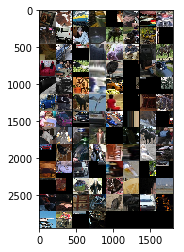

In [60]:
# Sanity check
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
train_dataiter = iter(train_loader)
train_images, train_labels, _ = train_dataiter.next()
print("Train images")
imshow(torchvision.utils.make_grid(train_images))

Test images


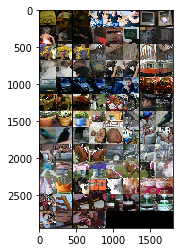

In [61]:
# another Sanity check
test_dataiter = iter(test_loader)
test_images, test_labels, _ = test_dataiter.next()
print("Test images")
imshow(torchvision.utils.make_grid(test_images))

### Fine-tuning
Litlefinger has brought you a pre-trained network. Fine-tune the network in the following section:

In [62]:
resnet18 = models.resnet18(pretrained=True)

resnet18.fc = nn.Linear(resnet18.fc.in_features, 21)

# Add code for using CUDA here
if(torch.cuda.is_available()):
    use_gpu = True
    resnet18.cuda()

In [63]:
criterion = nn.CrossEntropyLoss(weight=weights)
# Update if any errors occur
optimizer = optim.SGD(resnet18.parameters(), learning_rate, hyp_momentum)

In [64]:
loss_arr = []
def arya_train():
    # Begin
    for epoch in range(num_epochs):
        for i, (image, class_name, _) in enumerate(train_loader):  
            # Convert torch tensor to Variable
            images = Variable(image)
            names = Variable(class_name)
            if(use_gpu):
                images=images.cuda()
                names=names.cuda()
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = resnet18(images)
            loss = criterion(outputs, names)
            loss.backward()
            loss_arr.append(loss.data[0])
            optimizer.step()
            if (i+1) % batch_size == 0:
                print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
    plt.plot( np.array(range(1,len(loss_arr)+1)), np.array(loss_arr))
    plt.show()

Epoch [1/5], Step [100/206], Loss: 1.0005
Epoch [1/5], Step [200/206], Loss: 0.8391
Epoch [2/5], Step [100/206], Loss: 0.5180
Epoch [2/5], Step [200/206], Loss: 0.5763
Epoch [3/5], Step [100/206], Loss: 0.2850
Epoch [3/5], Step [200/206], Loss: 0.3117
Epoch [4/5], Step [100/206], Loss: 0.1266
Epoch [4/5], Step [200/206], Loss: 0.1963
Epoch [5/5], Step [100/206], Loss: 0.2364
Epoch [5/5], Step [200/206], Loss: 0.1925


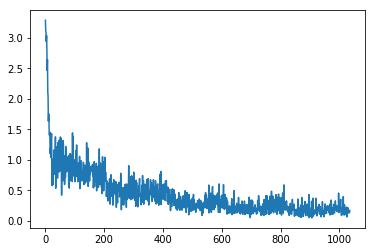

CPU times: user 25min 52s, sys: 43.3 s, total: 26min 35s
Wall time: 9min 6s


In [65]:
%time arya_train()
# torch.save(resnet18.state_dict(), 'assignment2_model.pkl')

In [19]:
# resnet18.load_state_dict(torch.load('assignment2_model.pkl'))

# Testing and Accuracy Calculation
Jorah then asks a question, how is this a detection task?<br/>
As everybody wonders, Theon Greyjoy suggests a slding window method to test the above trained trained network on the detection task:<br/>
"We take some windows of varying size and aspect ratios", he mumbled, "and slide it through the test image (considering some stride of pixels) from left to right, and top to bottom, detect the class scores for each of the window, and keep only those which are above a certain threshold value!". "He is right", says Samwell, "I read a similar approach in the paper -Faster RCNN by Ross Girshick in the library, where he uses three diferent scales/sizes and three different aspect ratios, making a total of nine windows per pixel to slide". You need to write the code and use it in testing code to find the predicted boxes and their classes.

In [71]:
# Testing the classification accuracy
def test_classification(model, image = None):
    # Write loops for testing the model on the test set
    # You should also print out the accuracy of the model
    correct = 0
    total = 0
    
    for images, labels, name in test_loader:
        images = Variable(images)
        
        if(use_gpu):
            images = images.cuda()
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        print(name)
        print(len(name))
        print(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu()).sum()
        print('Accuracy of the network on the ' + str(total) + ' test images: %d %%' % (100 * correct / total))
        
test_classification(resnet18)

('005906.jpg', '005906.jpg', '005906.jpg', '004213.jpg', '004213.jpg', '004213.jpg', '000059.jpg', '000059.jpg', '000059.jpg', '000059.jpg', '000059.jpg', '000059.jpg', '006141.jpg', '007219.jpg', '007219.jpg', '003260.jpg', '003260.jpg', '003260.jpg', '003260.jpg', '005629.jpg', '005629.jpg', '005629.jpg', '005629.jpg', '005629.jpg', '004438.jpg', '004438.jpg', '004438.jpg', '004438.jpg', '005152.jpg', '005152.jpg', '009827.jpg', '009827.jpg', '009827.jpg', '004844.jpg', '004844.jpg', '004844.jpg', '004844.jpg', '004844.jpg', '001125.jpg', '001125.jpg', '001125.jpg', '001125.jpg', '001125.jpg', '004267.jpg', '005871.jpg', '006802.jpg', '006802.jpg', '006802.jpg', '004486.jpg', '004486.jpg', '004486.jpg', '004486.jpg', '004486.jpg', '003254.jpg', '002144.jpg', '002144.jpg', '002144.jpg', '002144.jpg', '002144.jpg', '003995.jpg', '003995.jpg', '008580.jpg', '007187.jpg', '007187.jpg', '007187.jpg', '007187.jpg', '005513.jpg', '005513.jpg', '002804.jpg', '002804.jpg', '002804.jpg', '0028

('002235.jpg', '002235.jpg', '002235.jpg', '002235.jpg', '002235.jpg', '002235.jpg', '002235.jpg', '002235.jpg', '002235.jpg', '002235.jpg', '002985.jpg', '009223.jpg', '009223.jpg', '009223.jpg', '000348.jpg', '000348.jpg', '000348.jpg', '000348.jpg', '007587.jpg', '007587.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '002311.jpg', '008941.jpg', '008941.jpg', '008941.jpg', '008941.jpg', '004233.jpg', '004233.jpg', '004233.jpg', '003905.jpg', '008789.jpg', '002621.jpg', '002621.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '008105.jpg', '0081

('000652.jpg', '000652.jpg', '000652.jpg', '006179.jpg', '006179.jpg', '006179.jpg', '005236.jpg', '005236.jpg', '005236.jpg', '005236.jpg', '006655.jpg', '004342.jpg', '004342.jpg', '004342.jpg', '004342.jpg', '004342.jpg', '001704.jpg', '005451.jpg', '005451.jpg', '005451.jpg', '005451.jpg', '005451.jpg', '005451.jpg', '000031.jpg', '002458.jpg', '002458.jpg', '004899.jpg', '004899.jpg', '004899.jpg', '004899.jpg', '000418.jpg', '006329.jpg', '003511.jpg', '008673.jpg', '008673.jpg', '007602.jpg', '007602.jpg', '007602.jpg', '007602.jpg', '001436.jpg', '000229.jpg', '000229.jpg', '000229.jpg', '000229.jpg', '000229.jpg', '000229.jpg', '000229.jpg', '000229.jpg', '000229.jpg', '000229.jpg', '000229.jpg', '007747.jpg', '007747.jpg', '007747.jpg', '007747.jpg', '006413.jpg', '006413.jpg', '004567.jpg', '004567.jpg', '000987.jpg', '000987.jpg', '000987.jpg', '000987.jpg', '000987.jpg', '003270.jpg', '003270.jpg', '004459.jpg', '004459.jpg', '004459.jpg', '004459.jpg', '004459.jpg', '0044

('001129.jpg', '001129.jpg', '005802.jpg', '000621.jpg', '000621.jpg', '000621.jpg', '000621.jpg', '000621.jpg', '006931.jpg', '006931.jpg', '006931.jpg', '006931.jpg', '006931.jpg', '006931.jpg', '006931.jpg', '006931.jpg', '006931.jpg', '006931.jpg', '006931.jpg', '006931.jpg', '006931.jpg', '000434.jpg', '000434.jpg', '006124.jpg', '007837.jpg', '007837.jpg', '001959.jpg', '000354.jpg', '000857.jpg', '001172.jpg', '004633.jpg', '005133.jpg', '005133.jpg', '006669.jpg', '006669.jpg', '006669.jpg', '006664.jpg', '006664.jpg', '007162.jpg', '006254.jpg', '006342.jpg', '003248.jpg', '000568.jpg', '005237.jpg', '005237.jpg', '005532.jpg', '005532.jpg', '005532.jpg', '005532.jpg', '005532.jpg', '005532.jpg', '005532.jpg', '005532.jpg', '005622.jpg', '005622.jpg', '005622.jpg', '005622.jpg', '005622.jpg', '005622.jpg', '005622.jpg', '005622.jpg', '005622.jpg', '005622.jpg', '005622.jpg', '005574.jpg', '005574.jpg', '001614.jpg', '001614.jpg', '001614.jpg', '001614.jpg', '003864.jpg', '0077

('001325.jpg', '001325.jpg', '001325.jpg', '001325.jpg', '001325.jpg', '001325.jpg', '005681.jpg', '009913.jpg', '001930.jpg', '001930.jpg', '001930.jpg', '008541.jpg', '008541.jpg', '008541.jpg', '008541.jpg', '008541.jpg', '005337.jpg', '005664.jpg', '005664.jpg', '005664.jpg', '005664.jpg', '008185.jpg', '009858.jpg', '004932.jpg', '004932.jpg', '000102.jpg', '000102.jpg', '004240.jpg', '004240.jpg', '009635.jpg', '009635.jpg', '000019.jpg', '000019.jpg', '006553.jpg', '000290.jpg', '002551.jpg', '002551.jpg', '002551.jpg', '002551.jpg', '002551.jpg', '002551.jpg', '000137.jpg', '000137.jpg', '000137.jpg', '001743.jpg', '001743.jpg', '007539.jpg', '001664.jpg', '006082.jpg', '006082.jpg', '006082.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '008751.jpg', '006008.jpg', '007612.jpg', '008157.jpg', '008157.jpg', '008157.jpg', '0055

('009265.jpg', '001094.jpg', '003110.jpg', '003110.jpg', '005489.jpg', '005489.jpg', '008547.jpg', '008547.jpg', '008547.jpg', '008547.jpg', '006153.jpg', '007660.jpg', '007660.jpg', '007660.jpg', '007660.jpg', '007660.jpg', '007660.jpg', '007660.jpg', '007660.jpg', '003645.jpg', '003645.jpg', '003645.jpg', '003645.jpg', '005017.jpg', '005017.jpg', '005017.jpg', '005017.jpg', '005017.jpg', '005017.jpg', '005017.jpg', '005017.jpg', '005017.jpg', '000263.jpg', '000263.jpg', '008869.jpg', '008869.jpg', '008869.jpg', '008869.jpg', '008869.jpg', '008869.jpg', '008869.jpg', '001912.jpg', '009806.jpg', '009806.jpg', '009806.jpg', '009806.jpg', '009806.jpg', '009806.jpg', '009806.jpg', '009806.jpg', '000206.jpg', '000206.jpg', '000206.jpg', '000206.jpg', '003197.jpg', '003197.jpg', '002756.jpg', '002756.jpg', '007647.jpg', '007647.jpg', '007647.jpg', '003752.jpg', '003752.jpg', '003752.jpg', '001275.jpg', '001275.jpg', '001275.jpg', '001275.jpg', '001275.jpg', '001275.jpg', '001275.jpg', '0012

('004577.jpg', '008407.jpg', '008407.jpg', '008407.jpg', '008407.jpg', '008407.jpg', '008407.jpg', '008407.jpg', '004516.jpg', '004516.jpg', '004516.jpg', '004516.jpg', '006755.jpg', '006755.jpg', '006755.jpg', '006755.jpg', '006755.jpg', '005497.jpg', '001450.jpg', '001450.jpg', '006842.jpg', '006842.jpg', '005662.jpg', '005662.jpg', '005662.jpg', '005662.jpg', '005662.jpg', '005662.jpg', '005662.jpg', '005662.jpg', '005662.jpg', '005662.jpg', '005662.jpg', '005662.jpg', '005662.jpg', '008852.jpg', '008852.jpg', '001706.jpg', '001706.jpg', '009844.jpg', '009844.jpg', '009844.jpg', '009844.jpg', '001102.jpg', '001102.jpg', '001102.jpg', '009045.jpg', '009045.jpg', '009045.jpg', '009045.jpg', '009045.jpg', '009045.jpg', '009045.jpg', '009045.jpg', '008790.jpg', '008889.jpg', '005058.jpg', '005058.jpg', '004645.jpg', '009012.jpg', '009012.jpg', '009012.jpg', '009012.jpg', '000630.jpg', '000630.jpg', '003863.jpg', '003863.jpg', '006005.jpg', '006005.jpg', '006005.jpg', '000989.jpg', '0004

('005243.jpg', '003128.jpg', '001029.jpg', '008001.jpg', '008001.jpg', '008001.jpg', '008001.jpg', '005383.jpg', '003568.jpg', '003568.jpg', '003816.jpg', '002027.jpg', '002027.jpg', '006964.jpg', '006964.jpg', '006964.jpg', '006964.jpg', '006964.jpg', '006964.jpg', '006964.jpg', '006964.jpg', '003341.jpg', '003341.jpg', '003341.jpg', '003341.jpg', '003341.jpg', '003341.jpg', '003341.jpg', '003341.jpg', '003341.jpg', '005432.jpg', '009906.jpg', '009906.jpg', '009906.jpg', '009906.jpg', '009488.jpg', '003455.jpg', '003455.jpg', '008493.jpg', '008493.jpg', '008493.jpg', '008493.jpg', '008493.jpg', '008493.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '002572.jpg', '007942.jpg', '007942.jpg', '007942.jpg', '007942.jpg', '007464.jpg', '007464.jpg', '001395.jpg', '002413.jpg', '000407.jpg', '000407.jpg', '006689.jpg', '006689.jpg', '0066

('001678.jpg', '001678.jpg', '001678.jpg', '001678.jpg', '007085.jpg', '007085.jpg', '006956.jpg', '006956.jpg', '006956.jpg', '006956.jpg', '006942.jpg', '006609.jpg', '006609.jpg', '000669.jpg', '000669.jpg', '000669.jpg', '001914.jpg', '001914.jpg', '001914.jpg', '001914.jpg', '001914.jpg', '008885.jpg', '006003.jpg', '006003.jpg', '004558.jpg', '004558.jpg', '004558.jpg', '004558.jpg', '006692.jpg', '005865.jpg', '005865.jpg', '005865.jpg', '005865.jpg', '005865.jpg', '005865.jpg', '005865.jpg', '005865.jpg', '005865.jpg', '001771.jpg', '001771.jpg', '001771.jpg', '006010.jpg', '006010.jpg', '006010.jpg', '006010.jpg', '006010.jpg', '006010.jpg', '006010.jpg', '006010.jpg', '006010.jpg', '006010.jpg', '006010.jpg', '006010.jpg', '005068.jpg', '005068.jpg', '003437.jpg', '007840.jpg', '008775.jpg', '008775.jpg', '008775.jpg', '008775.jpg', '008775.jpg', '008775.jpg', '008775.jpg', '008775.jpg', '008775.jpg', '008775.jpg', '008775.jpg', '008775.jpg', '000912.jpg', '004687.jpg', '0046

('003073.jpg', '001268.jpg', '001268.jpg', '002720.jpg', '005302.jpg', '005302.jpg', '005302.jpg', '005302.jpg', '005302.jpg', '005302.jpg', '005302.jpg', '005302.jpg', '005302.jpg', '005302.jpg', '005302.jpg', '005302.jpg', '005302.jpg', '009291.jpg', '009291.jpg', '009291.jpg', '009291.jpg', '009291.jpg', '001787.jpg', '004044.jpg', '006801.jpg', '007229.jpg', '006444.jpg', '006444.jpg', '007208.jpg', '007208.jpg', '007208.jpg', '007397.jpg', '007397.jpg', '007397.jpg', '007397.jpg', '007397.jpg', '003633.jpg', '003633.jpg', '003633.jpg', '003633.jpg', '003633.jpg', '004125.jpg', '004125.jpg', '006896.jpg', '006896.jpg', '006896.jpg', '006896.jpg', '006896.jpg', '002078.jpg', '005092.jpg', '005092.jpg', '005092.jpg', '005092.jpg', '005092.jpg', '005092.jpg', '005995.jpg', '005995.jpg', '003957.jpg', '003061.jpg', '003061.jpg', '003061.jpg', '004225.jpg', '004225.jpg', '004225.jpg', '006925.jpg', '006925.jpg', '006925.jpg', '006925.jpg', '006925.jpg', '006099.jpg', '003749.jpg', '0000

('006637.jpg', '006637.jpg', '002972.jpg', '002972.jpg', '001898.jpg', '001898.jpg', '001898.jpg', '001095.jpg', '001095.jpg', '001095.jpg', '001095.jpg', '001848.jpg', '000338.jpg', '000338.jpg', '006378.jpg', '006378.jpg', '006378.jpg', '006378.jpg', '006378.jpg', '007836.jpg', '007836.jpg', '007836.jpg', '007836.jpg', '007836.jpg', '007836.jpg', '005115.jpg', '009279.jpg', '009279.jpg', '009279.jpg', '009279.jpg', '001956.jpg', '004822.jpg', '004822.jpg', '008098.jpg', '008098.jpg', '008098.jpg', '008098.jpg', '008098.jpg', '008098.jpg', '003466.jpg', '003466.jpg', '003466.jpg', '005061.jpg', '005061.jpg', '005061.jpg', '005061.jpg', '005061.jpg', '008777.jpg', '000929.jpg', '000929.jpg', '000929.jpg', '000929.jpg', '000929.jpg', '000929.jpg', '000154.jpg', '000154.jpg', '000302.jpg', '000302.jpg', '000302.jpg', '000302.jpg', '000302.jpg', '000302.jpg', '000302.jpg', '004179.jpg', '004179.jpg', '004179.jpg', '004179.jpg', '004179.jpg', '001492.jpg', '001492.jpg', '001492.jpg', '0014

('009219.jpg', '009219.jpg', '009219.jpg', '001966.jpg', '001966.jpg', '007150.jpg', '007150.jpg', '007150.jpg', '007150.jpg', '002656.jpg', '002656.jpg', '002656.jpg', '002656.jpg', '001789.jpg', '001789.jpg', '001789.jpg', '001789.jpg', '001789.jpg', '004138.jpg', '004138.jpg', '005022.jpg', '007490.jpg', '007490.jpg', '004422.jpg', '004422.jpg', '004422.jpg', '004422.jpg', '004422.jpg', '004422.jpg', '004422.jpg', '004422.jpg', '004422.jpg', '004422.jpg', '002062.jpg', '002062.jpg', '002062.jpg', '008684.jpg', '001118.jpg', '001118.jpg', '001118.jpg', '001118.jpg', '001118.jpg', '007036.jpg', '007036.jpg', '007036.jpg', '007036.jpg', '005642.jpg', '004373.jpg', '004373.jpg', '004373.jpg', '004373.jpg', '004373.jpg', '004373.jpg', '003831.jpg', '003831.jpg', '008620.jpg', '007794.jpg', '007792.jpg', '007792.jpg', '007792.jpg', '009466.jpg', '002540.jpg', '002540.jpg', '002540.jpg', '005379.jpg', '005079.jpg', '009019.jpg', '009019.jpg', '007326.jpg', '008198.jpg', '008198.jpg', '0011

('006128.jpg', '006128.jpg', '006128.jpg', '006128.jpg', '006128.jpg', '006128.jpg', '006128.jpg', '006128.jpg', '006128.jpg', '006128.jpg', '006128.jpg', '006128.jpg', '002251.jpg', '009379.jpg', '009379.jpg', '009379.jpg', '004757.jpg', '004757.jpg', '009776.jpg', '009776.jpg', '009776.jpg', '008452.jpg', '008452.jpg', '008604.jpg', '008604.jpg', '008604.jpg', '008604.jpg', '008604.jpg', '008604.jpg', '008604.jpg', '008604.jpg', '007634.jpg', '007634.jpg', '007634.jpg', '007634.jpg', '007634.jpg', '007634.jpg', '007634.jpg', '007634.jpg', '007634.jpg', '007634.jpg', '007634.jpg', '007634.jpg', '007634.jpg', '007634.jpg', '002562.jpg', '002562.jpg', '002562.jpg', '004151.jpg', '007997.jpg', '007997.jpg', '002601.jpg', '009305.jpg', '004331.jpg', '005024.jpg', '005024.jpg', '007416.jpg', '007416.jpg', '002184.jpg', '002184.jpg', '004751.jpg', '004751.jpg', '001932.jpg', '001932.jpg', '001932.jpg', '005479.jpg', '005479.jpg', '004262.jpg', '007027.jpg', '001446.jpg', '001446.jpg', '0069

('000017.jpg', '000017.jpg', '004925.jpg', '004925.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '004953.jpg', '009560.jpg', '009321.jpg', '004975.jpg', '009625.jpg', '000831.jpg', '009543.jpg', '009543.jpg', '009543.jpg', '009543.jpg', '009543.jpg', '009543.jpg', '005342.jpg', '005342.jpg', '005342.jpg', '005342.jpg', '005342.jpg', '005342.jpg', '005896.jpg', '000629.jpg', '000629.jpg', '003919.jpg', '003919.jpg', '003919.jpg', '003919.jpg', '003919.jpg', '003919.jpg', '003919.jpg', '003919.jpg', '003919.jpg', '003919.jpg', '006214.jpg', '007593.jpg', '007593.jpg', '007593.jpg', '007593.jpg', '007593.jpg', '007593.jpg', '007593.jpg', '003569.jpg', '003569.jpg', '003519.jpg', '009890.jpg', '009890.jpg', '001877.jpg', '007701.jpg', '007701.jpg', '007701.jpg', '007701.jpg', '007701.jpg', '0006

('005847.jpg', '006543.jpg', '002076.jpg', '004264.jpg', '004448.jpg', '004448.jpg', '004448.jpg', '004715.jpg', '004715.jpg', '004110.jpg', '004110.jpg', '008328.jpg', '003898.jpg', '003898.jpg', '001560.jpg', '008761.jpg', '008761.jpg', '008761.jpg', '008427.jpg', '001603.jpg', '001603.jpg', '001603.jpg', '001603.jpg', '001603.jpg', '001603.jpg', '001374.jpg', '007114.jpg', '007114.jpg', '007114.jpg', '006895.jpg', '006895.jpg', '001230.jpg', '004554.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '002674.jpg', '000337.jpg', '000337.jpg', '000337.jpg', '000337.jpg', '000337.jpg', '000337.jpg', '000337.jpg', '000337.jpg', '000337.jpg', '000337.jpg', '000105.jpg', '000105.jpg', '000105.jpg', '000623.jpg', '000623.jpg', '004021.jpg', '000289.jpg', '004661.jpg', '004661.jpg', '004661.jpg', '004661.jpg', '006585.jpg', '0065

('006721.jpg', '006721.jpg', '006721.jpg', '006721.jpg', '006721.jpg', '006721.jpg', '005941.jpg', '005941.jpg', '005941.jpg', '005941.jpg', '005941.jpg', '005941.jpg', '007531.jpg', '007531.jpg', '007531.jpg', '003908.jpg', '006174.jpg', '006174.jpg', '009714.jpg', '009714.jpg', '002993.jpg', '002993.jpg', '001452.jpg', '001452.jpg', '000501.jpg', '008882.jpg', '008882.jpg', '008075.jpg', '000785.jpg', '002490.jpg', '002490.jpg', '002490.jpg', '002490.jpg', '002490.jpg', '000670.jpg', '000670.jpg', '007071.jpg', '005087.jpg', '005087.jpg', '008720.jpg', '008118.jpg', '008118.jpg', '002842.jpg', '002842.jpg', '004451.jpg', '004451.jpg', '004451.jpg', '004451.jpg', '004451.jpg', '004451.jpg', '004451.jpg', '004451.jpg', '004451.jpg', '004451.jpg', '007666.jpg', '000520.jpg', '009063.jpg', '009063.jpg', '002254.jpg', '002254.jpg', '002254.jpg', '002254.jpg', '007954.jpg', '001660.jpg', '009780.jpg', '009780.jpg', '009780.jpg', '000988.jpg', '001800.jpg', '001800.jpg', '005576.jpg', '0028

('007176.jpg', '007176.jpg', '002792.jpg', '002792.jpg', '002792.jpg', '002792.jpg', '002792.jpg', '009853.jpg', '009853.jpg', '009853.jpg', '009853.jpg', '009853.jpg', '009853.jpg', '000180.jpg', '002593.jpg', '007993.jpg', '007993.jpg', '006832.jpg', '005232.jpg', '005232.jpg', '002061.jpg', '002061.jpg', '002061.jpg', '002061.jpg', '002061.jpg', '003228.jpg', '003228.jpg', '003228.jpg', '003228.jpg', '003228.jpg', '003228.jpg', '003228.jpg', '003228.jpg', '005773.jpg', '005773.jpg', '005773.jpg', '005773.jpg', '005773.jpg', '005773.jpg', '005773.jpg', '009334.jpg', '001788.jpg', '003727.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '005233.jpg', '002901.jpg', '002901.jpg', '002901.jpg', '003679.jpg', '003133.jpg', '008422.jpg', '008422.jpg', '008422.jpg', '006131.jpg', '006131.jpg', '006131.jpg', '002709.jpg', '006548.jpg', '0065

('004037.jpg', '007216.jpg', '007216.jpg', '000681.jpg', '006661.jpg', '006661.jpg', '006661.jpg', '006661.jpg', '006661.jpg', '006661.jpg', '006661.jpg', '006661.jpg', '006661.jpg', '006661.jpg', '006661.jpg', '006661.jpg', '007270.jpg', '007270.jpg', '007270.jpg', '003264.jpg', '003264.jpg', '003264.jpg', '004136.jpg', '004136.jpg', '004136.jpg', '004136.jpg', '004136.jpg', '004136.jpg', '004136.jpg', '004136.jpg', '004136.jpg', '004136.jpg', '000246.jpg', '009107.jpg', '005581.jpg', '005581.jpg', '002757.jpg', '002467.jpg', '002467.jpg', '002467.jpg', '002467.jpg', '000868.jpg', '000868.jpg', '005667.jpg', '005667.jpg', '005667.jpg', '005667.jpg', '005667.jpg', '005667.jpg', '005667.jpg', '005667.jpg', '005667.jpg', '005667.jpg', '008029.jpg', '008121.jpg', '004809.jpg', '008450.jpg', '002373.jpg', '002373.jpg', '000151.jpg', '000151.jpg', '004619.jpg', '005069.jpg', '005069.jpg', '003371.jpg', '003371.jpg', '003378.jpg', '003378.jpg', '003378.jpg', '003378.jpg', '002956.jpg', '0020

('006351.jpg', '006351.jpg', '006351.jpg', '006846.jpg', '001476.jpg', '001476.jpg', '001476.jpg', '001476.jpg', '001476.jpg', '001476.jpg', '001476.jpg', '001476.jpg', '001476.jpg', '001476.jpg', '001476.jpg', '001476.jpg', '001476.jpg', '003983.jpg', '003079.jpg', '004538.jpg', '004538.jpg', '008229.jpg', '008229.jpg', '001390.jpg', '001390.jpg', '001390.jpg', '001390.jpg', '001390.jpg', '001152.jpg', '001152.jpg', '001152.jpg', '001152.jpg', '002366.jpg', '002366.jpg', '001220.jpg', '001220.jpg', '001220.jpg', '001891.jpg', '001891.jpg', '001891.jpg', '004495.jpg', '004495.jpg', '004495.jpg', '004495.jpg', '004667.jpg', '004667.jpg', '004667.jpg', '004667.jpg', '002752.jpg', '002752.jpg', '002752.jpg', '002752.jpg', '002752.jpg', '009581.jpg', '009581.jpg', '009581.jpg', '009581.jpg', '009676.jpg', '009676.jpg', '009676.jpg', '006853.jpg', '007823.jpg', '002781.jpg', '002781.jpg', '002781.jpg', '002781.jpg', '002781.jpg', '002781.jpg', '002781.jpg', '002781.jpg', '002781.jpg', '0027

('001627.jpg', '004043.jpg', '004043.jpg', '002543.jpg', '002543.jpg', '002543.jpg', '002543.jpg', '002543.jpg', '002543.jpg', '009011.jpg', '006891.jpg', '006891.jpg', '003796.jpg', '000042.jpg', '000042.jpg', '004003.jpg', '000786.jpg', '000786.jpg', '000786.jpg', '007787.jpg', '000119.jpg', '005971.jpg', '006525.jpg', '001041.jpg', '005890.jpg', '005890.jpg', '001939.jpg', '002007.jpg', '007670.jpg', '007670.jpg', '000759.jpg', '001465.jpg', '001465.jpg', '001465.jpg', '001465.jpg', '001465.jpg', '001465.jpg', '001465.jpg', '001465.jpg', '000921.jpg', '000921.jpg', '000921.jpg', '004552.jpg', '007856.jpg', '007856.jpg', '007856.jpg', '007856.jpg', '007856.jpg', '007856.jpg', '007856.jpg', '007856.jpg', '007856.jpg', '007856.jpg', '007856.jpg', '007856.jpg', '003486.jpg', '003486.jpg', '003486.jpg', '003486.jpg', '003486.jpg', '003486.jpg', '003486.jpg', '003486.jpg', '003486.jpg', '003486.jpg', '003486.jpg', '005202.jpg', '002071.jpg', '002071.jpg', '002071.jpg', '002071.jpg', '0020

('005706.jpg', '002897.jpg', '002897.jpg', '002897.jpg', '002897.jpg', '002897.jpg', '002897.jpg', '002897.jpg', '002897.jpg', '002897.jpg', '002897.jpg', '002897.jpg', '002897.jpg', '002897.jpg', '002897.jpg', '004815.jpg', '004815.jpg', '001500.jpg', '009050.jpg', '009050.jpg', '005382.jpg', '000854.jpg', '000854.jpg', '000854.jpg', '000854.jpg', '000854.jpg', '000854.jpg', '000854.jpg', '000854.jpg', '004104.jpg', '004104.jpg', '005851.jpg', '004227.jpg', '004227.jpg', '004227.jpg', '008904.jpg', '003724.jpg', '009606.jpg', '009606.jpg', '009606.jpg', '009606.jpg', '009606.jpg', '009606.jpg', '009606.jpg', '003122.jpg', '003122.jpg', '003122.jpg', '003122.jpg', '003122.jpg', '002167.jpg', '002167.jpg', '002167.jpg', '002167.jpg', '003446.jpg', '003446.jpg', '007686.jpg', '000433.jpg', '000433.jpg', '006297.jpg', '006297.jpg', '006297.jpg', '006297.jpg', '002204.jpg', '002204.jpg', '004219.jpg', '004219.jpg', '004219.jpg', '004219.jpg', '004219.jpg', '004219.jpg', '004219.jpg', '0007

('001508.jpg', '001508.jpg', '001508.jpg', '001508.jpg', '001508.jpg', '001508.jpg', '001508.jpg', '001508.jpg', '008926.jpg', '000014.jpg', '000014.jpg', '000014.jpg', '000014.jpg', '000014.jpg', '000014.jpg', '000014.jpg', '006670.jpg', '006670.jpg', '006670.jpg', '009186.jpg', '009186.jpg', '000270.jpg', '005803.jpg', '004533.jpg', '002729.jpg', '002729.jpg', '002729.jpg', '000046.jpg', '001068.jpg', '005158.jpg', '003745.jpg', '001030.jpg', '005830.jpg', '006690.jpg', '006690.jpg', '006690.jpg', '006690.jpg', '005621.jpg', '005621.jpg', '002307.jpg', '002307.jpg', '002484.jpg', '002484.jpg', '002484.jpg', '002484.jpg', '002484.jpg', '002484.jpg', '003234.jpg', '003234.jpg', '003234.jpg', '003234.jpg', '003234.jpg', '003234.jpg', '003234.jpg', '007264.jpg', '007264.jpg', '001804.jpg', '004733.jpg', '000818.jpg', '000818.jpg', '009061.jpg', '000804.jpg', '000804.jpg', '000804.jpg', '001209.jpg', '002174.jpg', '002174.jpg', '002174.jpg', '002174.jpg', '002174.jpg', '002174.jpg', '0021

('004779.jpg', '009798.jpg', '009798.jpg', '009798.jpg', '009798.jpg', '009798.jpg', '009798.jpg', '009798.jpg', '009798.jpg', '009798.jpg', '009798.jpg', '009798.jpg', '008518.jpg', '004401.jpg', '009165.jpg', '009165.jpg', '009165.jpg', '009165.jpg', '009165.jpg', '009165.jpg', '009165.jpg', '009165.jpg', '009434.jpg', '009434.jpg', '009434.jpg', '009434.jpg', '009434.jpg', '009647.jpg', '009647.jpg', '009647.jpg', '009647.jpg', '009647.jpg', '009647.jpg', '009647.jpg', '009647.jpg', '009647.jpg', '007625.jpg', '007625.jpg', '007625.jpg', '007625.jpg', '000674.jpg', '007599.jpg', '007599.jpg', '004206.jpg', '008529.jpg', '008529.jpg', '008529.jpg', '008529.jpg', '008529.jpg', '008529.jpg', '008529.jpg', '008529.jpg', '008529.jpg', '008529.jpg', '008529.jpg', '009492.jpg', '005556.jpg', '005556.jpg', '005556.jpg', '005556.jpg', '005556.jpg', '006158.jpg', '006158.jpg', '006158.jpg', '000475.jpg', '000475.jpg', '000475.jpg', '000475.jpg', '003188.jpg', '003188.jpg', '003473.jpg', '0034

('006731.jpg', '004919.jpg', '005040.jpg', '005040.jpg', '005040.jpg', '005613.jpg', '005613.jpg', '000022.jpg', '000022.jpg', '001038.jpg', '008849.jpg', '008849.jpg', '009957.jpg', '009957.jpg', '009775.jpg', '003408.jpg', '003408.jpg', '003051.jpg', '006665.jpg', '006665.jpg', '009193.jpg', '009193.jpg', '009193.jpg', '009193.jpg', '009648.jpg', '009082.jpg', '007667.jpg', '006994.jpg', '007434.jpg', '001976.jpg', '001976.jpg', '007454.jpg', '007454.jpg', '008264.jpg', '008264.jpg', '008264.jpg', '008264.jpg', '004961.jpg', '006266.jpg', '006266.jpg', '006266.jpg', '006266.jpg', '006266.jpg', '004366.jpg', '004366.jpg', '004366.jpg', '004366.jpg', '008688.jpg', '002803.jpg', '002803.jpg', '002803.jpg', '002803.jpg', '002803.jpg', '002803.jpg', '002803.jpg', '001110.jpg', '001110.jpg', '000216.jpg', '002726.jpg', '002726.jpg', '002726.jpg', '002726.jpg', '002726.jpg', '003125.jpg', '007476.jpg', '007476.jpg', '009562.jpg', '001252.jpg', '007398.jpg', '007398.jpg', '006835.jpg', '0068

('004093.jpg', '004093.jpg', '008294.jpg', '008294.jpg', '008294.jpg', '008294.jpg', '008294.jpg', '009716.jpg', '003878.jpg', '007406.jpg', '007406.jpg', '007406.jpg', '007406.jpg', '007406.jpg', '007406.jpg', '007406.jpg', '007406.jpg', '007406.jpg', '007406.jpg', '007406.jpg', '007406.jpg', '005831.jpg', '002741.jpg', '002741.jpg', '002741.jpg', '002741.jpg', '002741.jpg', '001828.jpg', '001828.jpg', '001828.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '000613.jpg', '006512.jpg', '009093.jpg', '003181.jpg', '003181.jpg', '003181.jpg', '003181.jpg', '000799.jpg', '000799.jpg', '004629.jpg', '004629.jpg', '004629.jpg', '004629.jpg', '004629.jpg', '004629.jpg', '004629.jpg', '004629.jpg', '000791.jpg', '001591.jpg', '001009.jpg', '001009.jpg', '003019.jpg', '002691.jpg', '002691.jpg', '002691.jpg', '0026

('009294.jpg', '003553.jpg', '003553.jpg', '003553.jpg', '003553.jpg', '002423.jpg', '001824.jpg', '001824.jpg', '001863.jpg', '004908.jpg', '004908.jpg', '009540.jpg', '009540.jpg', '004105.jpg', '004105.jpg', '004105.jpg', '004105.jpg', '004105.jpg', '004105.jpg', '004105.jpg', '004105.jpg', '000310.jpg', '000310.jpg', '000310.jpg', '000310.jpg', '006288.jpg', '006288.jpg', '006288.jpg', '006288.jpg', '000422.jpg', '000422.jpg', '000422.jpg', '000422.jpg', '008338.jpg', '008664.jpg', '006798.jpg', '006798.jpg', '004157.jpg', '007011.jpg', '004431.jpg', '004299.jpg', '004299.jpg', '004299.jpg', '004299.jpg', '009867.jpg', '009867.jpg', '009867.jpg', '004743.jpg', '006862.jpg', '006862.jpg', '006862.jpg', '006862.jpg', '006862.jpg', '006862.jpg', '006862.jpg', '004748.jpg', '004748.jpg', '004748.jpg', '004748.jpg', '001161.jpg', '005498.jpg', '005498.jpg', '005498.jpg', '005413.jpg', '005413.jpg', '005483.jpg', '005483.jpg', '000595.jpg', '000595.jpg', '000595.jpg', '000595.jpg', '0005

('007859.jpg', '008557.jpg', '008557.jpg', '008557.jpg', '008557.jpg', '008557.jpg', '008557.jpg', '008557.jpg', '008557.jpg', '008557.jpg', '008557.jpg', '007538.jpg', '007128.jpg', '007128.jpg', '007128.jpg', '007128.jpg', '007128.jpg', '001217.jpg', '001217.jpg', '001217.jpg', '001217.jpg', '001217.jpg', '006055.jpg', '006055.jpg', '006055.jpg', '006055.jpg', '006055.jpg', '006427.jpg', '006427.jpg', '006427.jpg', '002243.jpg', '006530.jpg', '006530.jpg', '006530.jpg', '006530.jpg', '006530.jpg', '006530.jpg', '005836.jpg', '005836.jpg', '003352.jpg', '003352.jpg', '003352.jpg', '007848.jpg', '000462.jpg', '003213.jpg', '003213.jpg', '003213.jpg', '000020.jpg', '004652.jpg', '002023.jpg', '001354.jpg', '001354.jpg', '001354.jpg', '001354.jpg', '001354.jpg', '001354.jpg', '001354.jpg', '007642.jpg', '001835.jpg', '004714.jpg', '004714.jpg', '004714.jpg', '004714.jpg', '004714.jpg', '004714.jpg', '005690.jpg', '005594.jpg', '002183.jpg', '002183.jpg', '005249.jpg', '006143.jpg', '0061

('004704.jpg', '004704.jpg', '008583.jpg', '008583.jpg', '008583.jpg', '008583.jpg', '008583.jpg', '000793.jpg', '000793.jpg', '000793.jpg', '000793.jpg', '000793.jpg', '000793.jpg', '000793.jpg', '000793.jpg', '000793.jpg', '000793.jpg', '005602.jpg', '005602.jpg', '002052.jpg', '005834.jpg', '009911.jpg', '000954.jpg', '000954.jpg', '001913.jpg', '005074.jpg', '005074.jpg', '005074.jpg', '005074.jpg', '005074.jpg', '005074.jpg', '005074.jpg', '005074.jpg', '003825.jpg', '003825.jpg', '003825.jpg', '003910.jpg', '003910.jpg', '001745.jpg', '001745.jpg', '001745.jpg', '001745.jpg', '001745.jpg', '001745.jpg', '001745.jpg', '001745.jpg', '008891.jpg', '008891.jpg', '009049.jpg', '009049.jpg', '009049.jpg', '009049.jpg', '003978.jpg', '003978.jpg', '000049.jpg', '000514.jpg', '008463.jpg', '008463.jpg', '008463.jpg', '008215.jpg', '008215.jpg', '008215.jpg', '008215.jpg', '008215.jpg', '000675.jpg', '000675.jpg', '000675.jpg', '007677.jpg', '005106.jpg', '005106.jpg', '008567.jpg', '0062

('003436.jpg', '003436.jpg', '003436.jpg', '002474.jpg', '002474.jpg', '002474.jpg', '008906.jpg', '008906.jpg', '002969.jpg', '003695.jpg', '004210.jpg', '004210.jpg', '009397.jpg', '009397.jpg', '009397.jpg', '005366.jpg', '005366.jpg', '005366.jpg', '005366.jpg', '003906.jpg', '003906.jpg', '001602.jpg', '001602.jpg', '009934.jpg', '007369.jpg', '007369.jpg', '007369.jpg', '007369.jpg', '001570.jpg', '006504.jpg', '006504.jpg', '008285.jpg', '008285.jpg', '000570.jpg', '000570.jpg', '008922.jpg', '008922.jpg', '008922.jpg', '008922.jpg', '008922.jpg', '008922.jpg', '005266.jpg', '005266.jpg', '005266.jpg', '005266.jpg', '005266.jpg', '006430.jpg', '004017.jpg', '004017.jpg', '000763.jpg', '000980.jpg', '000121.jpg', '000121.jpg', '004674.jpg', '002112.jpg', '005446.jpg', '005050.jpg', '005050.jpg', '000847.jpg', '000847.jpg', '004306.jpg', '004306.jpg', '007499.jpg', '007499.jpg', '003763.jpg', '007815.jpg', '007815.jpg', '007815.jpg', '009393.jpg', '009393.jpg', '009393.jpg', '0093

('000809.jpg', '000809.jpg', '006947.jpg', '000089.jpg', '000089.jpg', '000089.jpg', '000089.jpg', '003439.jpg', '003439.jpg', '005689.jpg', '004583.jpg', '005285.jpg', '005285.jpg', '008745.jpg', '008745.jpg', '008745.jpg', '008745.jpg', '007322.jpg', '003610.jpg', '007971.jpg', '007971.jpg', '007049.jpg', '007049.jpg', '007049.jpg', '000123.jpg', '009443.jpg', '009443.jpg', '009443.jpg', '006937.jpg', '006937.jpg', '002237.jpg', '003669.jpg', '003669.jpg', '003669.jpg', '003669.jpg', '003669.jpg', '003669.jpg', '002491.jpg', '002491.jpg', '001862.jpg', '001862.jpg', '004669.jpg', '004669.jpg', '003151.jpg', '003151.jpg', '003151.jpg', '008757.jpg', '004513.jpg', '004008.jpg', '004008.jpg', '006851.jpg', '006851.jpg', '004344.jpg', '004344.jpg', '006227.jpg', '005843.jpg', '007331.jpg', '001285.jpg', '001285.jpg', '002223.jpg', '002223.jpg', '002223.jpg', '002223.jpg', '002223.jpg', '002223.jpg', '002223.jpg', '002223.jpg', '007051.jpg', '007051.jpg', '002574.jpg', '002574.jpg', '0049

('000398.jpg', '001348.jpg', '001562.jpg', '000387.jpg', '004651.jpg', '007509.jpg', '007509.jpg', '009533.jpg', '009533.jpg', '001801.jpg', '001801.jpg', '001801.jpg', '001801.jpg', '001801.jpg', '001801.jpg', '001801.jpg', '001801.jpg', '001801.jpg', '001801.jpg', '001801.jpg', '001801.jpg', '001801.jpg', '001801.jpg', '009701.jpg', '005580.jpg', '007158.jpg', '004829.jpg', '008406.jpg', '008406.jpg', '008406.jpg', '002059.jpg', '003657.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '001472.jpg', '005132.jpg', '005132.jpg', '004338.jpg', '005016.jpg', '005016.jpg', '000218.jpg', '000218.jpg', '000218.jpg', '003175.jpg', '003175.jpg', '007077.jpg', '007077.jpg', '007077.jpg', '007077.jpg', '006741.jpg', '008854.jpg', '003483.jpg', '003483.jpg', '003483.jpg', '003483.jpg', '0035

('009684.jpg', '003087.jpg', '003087.jpg', '003087.jpg', '001951.jpg', '006822.jpg', '006822.jpg', '009910.jpg', '009910.jpg', '009592.jpg', '009592.jpg', '004061.jpg', '004061.jpg', '006952.jpg', '006978.jpg', '005599.jpg', '005599.jpg', '005599.jpg', '005599.jpg', '002614.jpg', '002614.jpg', '002614.jpg', '002614.jpg', '002614.jpg', '002614.jpg', '002614.jpg', '002614.jpg', '002614.jpg', '002614.jpg', '002614.jpg', '002614.jpg', '009759.jpg', '004641.jpg', '004641.jpg', '004641.jpg', '009203.jpg', '004749.jpg', '004749.jpg', '008268.jpg', '008268.jpg', '008268.jpg', '002609.jpg', '008059.jpg', '008059.jpg', '008059.jpg', '008059.jpg', '007072.jpg', '008173.jpg', '009891.jpg', '002509.jpg', '007517.jpg', '004294.jpg', '004294.jpg', '008367.jpg', '008367.jpg', '008367.jpg', '008367.jpg', '008367.jpg', '008367.jpg', '008367.jpg', '007606.jpg', '002152.jpg', '004879.jpg', '004879.jpg', '004879.jpg', '006890.jpg', '007655.jpg', '001673.jpg', '001673.jpg', '000542.jpg', '008927.jpg', '0038

('000539.jpg', '005767.jpg', '005767.jpg', '006803.jpg', '006803.jpg', '006803.jpg', '005976.jpg', '005976.jpg', '005976.jpg', '005976.jpg', '005377.jpg', '005377.jpg', '005377.jpg', '005377.jpg', '005675.jpg', '005675.jpg', '005675.jpg', '009277.jpg', '009277.jpg', '005303.jpg', '005303.jpg', '002380.jpg', '002664.jpg', '002664.jpg', '002664.jpg', '002664.jpg', '002664.jpg', '002664.jpg', '002664.jpg', '005408.jpg', '006298.jpg', '005375.jpg', '005375.jpg', '001384.jpg', '001384.jpg', '001384.jpg', '001384.jpg', '001384.jpg', '009639.jpg', '002862.jpg', '002862.jpg', '002862.jpg', '002862.jpg', '002862.jpg', '002862.jpg', '003531.jpg', '003531.jpg', '000386.jpg', '000386.jpg', '000386.jpg', '000170.jpg', '000170.jpg', '000170.jpg', '000170.jpg', '000170.jpg', '000170.jpg', '000446.jpg', '000446.jpg', '008031.jpg', '004693.jpg', '004693.jpg', '004693.jpg', '002751.jpg', '002751.jpg', '002751.jpg', '002751.jpg', '002751.jpg', '006734.jpg', '001735.jpg', '001735.jpg', '006130.jpg', '0061

('004423.jpg', '004423.jpg', '004423.jpg', '006451.jpg', '006451.jpg', '007896.jpg', '007896.jpg', '007896.jpg', '007896.jpg', '007896.jpg', '007896.jpg', '007896.jpg', '007896.jpg', '007896.jpg', '007896.jpg', '007896.jpg', '007896.jpg', '007896.jpg', '004345.jpg', '000402.jpg', '000402.jpg', '000402.jpg', '000707.jpg', '000707.jpg', '000707.jpg', '007824.jpg', '002760.jpg', '002760.jpg', '006869.jpg', '003057.jpg', '003057.jpg', '003057.jpg', '008585.jpg', '005607.jpg', '001226.jpg', '008848.jpg', '008848.jpg', '008848.jpg', '008848.jpg', '008735.jpg', '008735.jpg', '000260.jpg', '000260.jpg', '007673.jpg', '007673.jpg', '007673.jpg', '002447.jpg', '000653.jpg', '000653.jpg', '000653.jpg', '000653.jpg', '000653.jpg', '000653.jpg', '000716.jpg', '008284.jpg', '008284.jpg', '008284.jpg', '002156.jpg', '002156.jpg', '002156.jpg', '002156.jpg', '002156.jpg', '002156.jpg', '002156.jpg', '002872.jpg', '002872.jpg', '004951.jpg', '004951.jpg', '009609.jpg', '009609.jpg', '001884.jpg', '0018

('005192.jpg', '005192.jpg', '005192.jpg', '008964.jpg', '008964.jpg', '008964.jpg', '004325.jpg', '004252.jpg', '004252.jpg', '004252.jpg', '002749.jpg', '002749.jpg', '005886.jpg', '006355.jpg', '006355.jpg', '006355.jpg', '007263.jpg', '007263.jpg', '007263.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '004686.jpg', '005596.jpg', '005596.jpg', '005596.jpg', '005596.jpg', '005596.jpg', '005596.jpg', '005596.jpg', '001520.jpg', '006765.jpg', '006765.jpg', '006765.jpg', '006765.jpg', '006765.jpg', '008701.jpg', '008701.jpg', '008701.jpg', '003579.jpg', '003579.jpg', '006424.jpg', '006424.jpg', '008832.jpg', '002537.jpg', '001499.jpg', '001499.jpg', '001499.jpg', '004599.jpg', '004599.jpg', '004599.jpg', '004599.jpg', '007811.jpg', '007811.jpg', '007811.jpg', '009713.jpg', '009713.jpg', '009713.jpg', '009713.jpg', '0061

('007242.jpg', '007242.jpg', '006700.jpg', '007607.jpg', '000573.jpg', '000573.jpg', '009133.jpg', '006517.jpg', '006517.jpg', '006517.jpg', '006517.jpg', '006517.jpg', '006517.jpg', '006517.jpg', '006517.jpg', '008939.jpg', '004216.jpg', '002217.jpg', '002217.jpg', '002217.jpg', '002217.jpg', '002217.jpg', '002217.jpg', '003950.jpg', '003950.jpg', '003950.jpg', '003950.jpg', '003950.jpg', '003950.jpg', '000490.jpg', '000490.jpg', '000490.jpg', '000490.jpg', '000490.jpg', '000490.jpg', '001277.jpg', '001613.jpg', '001613.jpg', '009243.jpg', '009386.jpg', '009386.jpg', '003540.jpg', '005635.jpg', '005635.jpg', '005635.jpg', '005635.jpg', '005635.jpg', '005635.jpg', '005635.jpg', '005635.jpg', '005635.jpg', '005635.jpg', '005635.jpg', '005264.jpg', '005264.jpg', '002077.jpg', '002077.jpg', '005788.jpg', '005788.jpg', '002785.jpg', '009940.jpg', '009940.jpg', '005384.jpg', '005384.jpg', '002984.jpg', '002984.jpg', '002984.jpg', '009912.jpg', '002795.jpg', '002795.jpg', '002795.jpg', '0027

('006546.jpg', '004555.jpg', '008061.jpg', '008061.jpg', '008061.jpg', '008061.jpg', '008061.jpg', '001382.jpg', '001382.jpg', '001382.jpg', '001382.jpg', '001382.jpg', '001382.jpg', '001382.jpg', '001382.jpg', '001382.jpg', '002684.jpg', '001418.jpg', '000584.jpg', '000584.jpg', '004650.jpg', '004650.jpg', '004650.jpg', '008447.jpg', '008447.jpg', '008447.jpg', '009907.jpg', '007721.jpg', '007721.jpg', '007721.jpg', '007721.jpg', '005403.jpg', '005654.jpg', '003748.jpg', '003126.jpg', '002610.jpg', '002610.jpg', '002610.jpg', '002610.jpg', '001076.jpg', '001076.jpg', '001076.jpg', '004776.jpg', '008884.jpg', '008884.jpg', '008884.jpg', '008167.jpg', '008167.jpg', '006726.jpg', '008034.jpg', '008034.jpg', '008034.jpg', '008034.jpg', '006400.jpg', '006400.jpg', '006400.jpg', '008822.jpg', '000676.jpg', '005211.jpg', '002702.jpg', '002702.jpg', '002702.jpg', '004632.jpg', '004632.jpg', '002260.jpg', '009359.jpg', '009359.jpg', '004242.jpg', '000160.jpg', '006436.jpg', '000108.jpg', '0001

('004301.jpg', '000461.jpg', '009888.jpg', '001495.jpg', '004063.jpg', '004063.jpg', '004063.jpg', '006485.jpg', '002994.jpg', '002994.jpg', '000358.jpg', '000358.jpg', '008871.jpg', '007671.jpg', '005724.jpg', '005724.jpg', '003875.jpg', '003875.jpg', '003875.jpg', '003875.jpg', '006706.jpg', '006706.jpg', '006706.jpg', '001271.jpg', '001271.jpg', '001271.jpg', '001271.jpg', '001271.jpg', '001271.jpg', '001271.jpg', '008867.jpg', '008867.jpg', '004276.jpg', '004276.jpg', '004276.jpg', '004276.jpg', '004276.jpg', '004276.jpg', '002208.jpg', '002208.jpg', '008445.jpg', '008445.jpg', '001631.jpg', '001631.jpg', '003202.jpg', '003202.jpg', '003202.jpg', '003202.jpg', '003202.jpg', '008275.jpg', '000467.jpg', '000467.jpg', '000467.jpg', '000467.jpg', '000467.jpg', '000467.jpg', '000467.jpg', '000467.jpg', '000467.jpg', '000467.jpg', '000467.jpg', '002213.jpg', '002213.jpg', '006537.jpg', '009388.jpg', '009388.jpg', '009388.jpg', '009388.jpg', '009388.jpg', '003311.jpg', '003311.jpg', '0033

('002965.jpg', '002965.jpg', '002965.jpg', '002965.jpg', '002965.jpg', '002965.jpg', '002965.jpg', '002965.jpg', '002965.jpg', '002965.jpg', '002965.jpg', '002965.jpg', '002965.jpg', '002965.jpg', '002965.jpg', '000947.jpg', '005475.jpg', '005475.jpg', '005475.jpg', '005475.jpg', '005475.jpg', '005475.jpg', '001303.jpg', '009848.jpg', '009848.jpg', '009848.jpg', '007197.jpg', '000986.jpg', '000986.jpg', '000986.jpg', '000986.jpg', '000986.jpg', '000986.jpg', '000986.jpg', '000986.jpg', '005246.jpg', '000559.jpg', '000559.jpg', '000254.jpg', '000254.jpg', '000254.jpg', '000254.jpg', '000254.jpg', '007979.jpg', '007979.jpg', '007979.jpg', '008719.jpg', '008719.jpg', '008719.jpg', '002016.jpg', '002016.jpg', '001755.jpg', '001755.jpg', '001166.jpg', '000192.jpg', '000192.jpg', '006617.jpg', '006617.jpg', '008515.jpg', '007507.jpg', '007507.jpg', '007507.jpg', '004439.jpg', '004439.jpg', '004439.jpg', '004439.jpg', '000179.jpg', '000179.jpg', '000179.jpg', '000179.jpg', '000179.jpg', '0077

('007147.jpg', '006514.jpg', '006514.jpg', '006675.jpg', '005537.jpg', '005595.jpg', '005595.jpg', '008282.jpg', '008282.jpg', '008282.jpg', '001339.jpg', '006921.jpg', '006921.jpg', '006921.jpg', '006921.jpg', '006921.jpg', '006921.jpg', '006921.jpg', '006921.jpg', '007062.jpg', '008256.jpg', '008256.jpg', '003872.jpg', '004942.jpg', '004991.jpg', '004991.jpg', '004991.jpg', '004991.jpg', '004991.jpg', '004991.jpg', '005764.jpg', '007966.jpg', '007966.jpg', '004195.jpg', '004195.jpg', '004195.jpg', '001466.jpg', '002627.jpg', '002627.jpg', '002627.jpg', '002627.jpg', '002627.jpg', '002627.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '007373.jpg', '003839.jpg', '003839.jpg', '003839.jpg', '002179.jpg', '009422.jpg', '000602.jpg', '0006

('004435.jpg', '004435.jpg', '007056.jpg', '008408.jpg', '006274.jpg', '006274.jpg', '006274.jpg', '006274.jpg', '006274.jpg', '006274.jpg', '006274.jpg', '007178.jpg', '007178.jpg', '007178.jpg', '008491.jpg', '008491.jpg', '000779.jpg', '006095.jpg', '006095.jpg', '006095.jpg', '003938.jpg', '002352.jpg', '002352.jpg', '002740.jpg', '002740.jpg', '009767.jpg', '009767.jpg', '000604.jpg', '000604.jpg', '001043.jpg', '005736.jpg', '005736.jpg', '006948.jpg', '006948.jpg', '006948.jpg', '006948.jpg', '006948.jpg', '005557.jpg', '003658.jpg', '009653.jpg', '009653.jpg', '009653.jpg', '000668.jpg', '001705.jpg', '001705.jpg', '001705.jpg', '009340.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '007569.jpg', '0075

('003307.jpg', '001407.jpg', '001407.jpg', '001407.jpg', '001407.jpg', '001407.jpg', '001407.jpg', '001407.jpg', '001407.jpg', '001052.jpg', '003567.jpg', '003567.jpg', '003567.jpg', '003567.jpg', '003567.jpg', '003567.jpg', '003567.jpg', '003567.jpg', '004040.jpg', '004040.jpg', '004040.jpg', '006928.jpg', '006967.jpg', '005789.jpg', '005789.jpg', '005789.jpg', '004278.jpg', '000827.jpg', '000827.jpg', '007926.jpg', '009004.jpg', '009004.jpg', '009004.jpg', '009004.jpg', '006565.jpg', '001316.jpg', '003626.jpg', '003626.jpg', '003626.jpg', '009023.jpg', '009023.jpg', '009023.jpg', '009023.jpg', '009023.jpg', '009023.jpg', '001672.jpg', '002571.jpg', '003068.jpg', '005627.jpg', '005627.jpg', '005627.jpg', '005627.jpg', '005627.jpg', '005627.jpg', '005627.jpg', '004059.jpg', '004059.jpg', '004059.jpg', '004059.jpg', '004059.jpg', '004059.jpg', '004059.jpg', '004059.jpg', '004059.jpg', '001726.jpg', '001726.jpg', '001726.jpg', '001726.jpg', '006946.jpg', '006580.jpg', '006580.jpg', '0065

('004989.jpg', '004989.jpg', '006768.jpg', '006768.jpg', '006768.jpg', '006768.jpg', '005636.jpg', '005636.jpg', '009757.jpg', '003888.jpg', '001942.jpg', '001942.jpg', '001942.jpg', '001942.jpg', '001942.jpg', '004782.jpg', '004782.jpg', '004124.jpg', '004124.jpg', '001920.jpg', '001920.jpg', '001920.jpg', '001920.jpg', '005395.jpg', '005395.jpg', '005395.jpg', '005395.jpg', '005395.jpg', '005395.jpg', '005395.jpg', '005395.jpg', '005395.jpg', '005395.jpg', '007417.jpg', '007417.jpg', '007417.jpg', '005433.jpg', '005433.jpg', '004622.jpg', '004622.jpg', '002417.jpg', '005826.jpg', '006390.jpg', '006390.jpg', '006390.jpg', '006390.jpg', '003981.jpg', '003981.jpg', '009584.jpg', '009584.jpg', '009584.jpg', '006461.jpg', '006461.jpg', '006461.jpg', '006461.jpg', '006461.jpg', '006461.jpg', '006461.jpg', '006461.jpg', '000036.jpg', '003312.jpg', '006806.jpg', '006806.jpg', '006806.jpg', '006806.jpg', '007313.jpg', '009016.jpg', '008930.jpg', '007925.jpg', '007925.jpg', '007925.jpg', '0079

('009694.jpg', '009694.jpg', '009694.jpg', '004930.jpg', '004930.jpg', '008414.jpg', '008414.jpg', '002128.jpg', '006694.jpg', '000317.jpg', '008692.jpg', '008692.jpg', '008692.jpg', '008692.jpg', '008692.jpg', '002953.jpg', '002953.jpg', '002953.jpg', '002953.jpg', '002953.jpg', '004949.jpg', '004949.jpg', '004949.jpg', '004949.jpg', '004949.jpg', '007542.jpg', '007894.jpg', '007894.jpg', '007894.jpg', '007894.jpg', '007894.jpg', '007894.jpg', '008614.jpg', '008614.jpg', '008614.jpg', '003530.jpg', '003530.jpg', '008511.jpg', '007015.jpg', '000352.jpg', '000352.jpg', '000352.jpg', '000352.jpg', '000352.jpg', '008036.jpg', '006622.jpg', '006622.jpg', '006622.jpg', '007459.jpg', '008712.jpg', '000238.jpg', '000238.jpg', '004164.jpg', '004164.jpg', '004164.jpg', '009728.jpg', '009728.jpg', '004613.jpg', '009164.jpg', '009164.jpg', '009164.jpg', '009164.jpg', '009164.jpg', '001315.jpg', '001315.jpg', '008641.jpg', '008641.jpg', '003224.jpg', '003224.jpg', '003224.jpg', '000400.jpg', '0076

('007803.jpg', '004968.jpg', '004968.jpg', '008718.jpg', '008718.jpg', '008718.jpg', '008718.jpg', '002960.jpg', '001674.jpg', '001674.jpg', '001674.jpg', '001674.jpg', '001674.jpg', '002301.jpg', '002301.jpg', '002301.jpg', '002301.jpg', '002301.jpg', '002301.jpg', '002301.jpg', '002301.jpg', '002301.jpg', '002301.jpg', '002301.jpg', '002301.jpg', '002301.jpg', '008999.jpg', '008999.jpg', '008999.jpg', '008999.jpg', '008999.jpg', '008999.jpg', '008999.jpg', '009118.jpg', '009118.jpg', '003349.jpg', '006474.jpg', '003241.jpg', '006813.jpg', '006813.jpg', '009669.jpg', '002195.jpg', '002195.jpg', '007652.jpg', '007652.jpg', '007652.jpg', '000511.jpg', '004121.jpg', '004121.jpg', '004121.jpg', '003646.jpg', '005119.jpg', '005119.jpg', '006620.jpg', '006620.jpg', '006046.jpg', '006046.jpg', '006046.jpg', '002190.jpg', '002190.jpg', '002190.jpg', '002190.jpg', '002190.jpg', '002190.jpg', '002190.jpg', '002190.jpg', '001473.jpg', '001473.jpg', '008189.jpg', '008189.jpg', '002073.jpg', '0037

('007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007644.jpg', '007518.jpg', '007518.jpg', '007518.jpg', '007518.jpg', '007518.jpg', '007518.jpg', '007518.jpg', '007343.jpg', '007387.jpg', '002290.jpg', '002290.jpg', '002290.jpg', '002290.jpg', '002290.jpg', '002290.jpg', '002290.jpg', '002290.jpg', '002290.jpg', '002290.jpg', '002290.jpg', '002290.jpg', '002290.jpg', '002290.jpg', '005394.jpg', '002605.jpg', '002605.jpg', '002605.jpg', '002605.jpg', '002605.jpg', '002605.jpg', '001713.jpg', '007424.jpg', '000639.jpg', '005833.jpg', '005833.jpg', '006976.jpg', '006976.jpg', '006976.jpg', '009143.jpg', '009143.jpg', '009143.jpg', '008937.jpg', '008937.jpg', '008937.jpg', '008937.jpg', '008451.jpg', '008451.jpg', '008451.jpg', '000097.jpg', '000097.jpg', '0000

('007497.jpg', '007497.jpg', '007617.jpg', '007617.jpg', '004341.jpg', '004903.jpg', '004903.jpg', '004903.jpg', '004903.jpg', '002169.jpg', '000134.jpg', '002915.jpg', '002915.jpg', '002915.jpg', '003788.jpg', '003788.jpg', '007493.jpg', '007493.jpg', '007493.jpg', '007493.jpg', '006011.jpg', '006011.jpg', '006011.jpg', '006011.jpg', '003755.jpg', '003755.jpg', '003755.jpg', '004086.jpg', '004086.jpg', '007463.jpg', '002999.jpg', '002999.jpg', '002999.jpg', '002999.jpg', '002999.jpg', '002999.jpg', '002999.jpg', '008159.jpg', '008159.jpg', '004019.jpg', '004019.jpg', '004019.jpg', '004019.jpg', '004019.jpg', '004019.jpg', '004019.jpg', '003944.jpg', '003944.jpg', '003944.jpg', '002154.jpg', '002154.jpg', '002154.jpg', '002154.jpg', '002154.jpg', '002154.jpg', '002154.jpg', '002154.jpg', '002154.jpg', '005145.jpg', '005145.jpg', '008613.jpg', '003461.jpg', '003461.jpg', '003461.jpg', '003461.jpg', '003461.jpg', '003461.jpg', '003461.jpg', '003461.jpg', '003461.jpg', '003461.jpg', '0034

('008900.jpg', '008900.jpg', '008900.jpg', '004255.jpg', '004255.jpg', '004255.jpg', '004255.jpg', '004255.jpg', '004255.jpg', '007558.jpg', '007558.jpg', '007558.jpg', '007558.jpg', '007558.jpg', '007558.jpg', '006608.jpg', '006608.jpg', '006608.jpg', '006608.jpg', '006608.jpg', '002420.jpg', '006222.jpg', '006222.jpg', '009290.jpg', '009290.jpg', '009290.jpg', '009290.jpg', '000132.jpg', '000821.jpg', '009354.jpg', '005984.jpg', '005984.jpg', '005984.jpg', '005984.jpg', '004020.jpg', '004020.jpg', '004020.jpg', '006930.jpg', '005323.jpg', '005323.jpg', '006250.jpg', '002160.jpg', '002160.jpg', '008453.jpg', '008453.jpg', '008453.jpg', '009756.jpg', '009756.jpg', '008532.jpg', '005822.jpg', '005822.jpg', '009103.jpg', '009103.jpg', '009339.jpg', '009339.jpg', '005808.jpg', '005808.jpg', '005808.jpg', '005808.jpg', '009106.jpg', '001778.jpg', '003648.jpg', '003648.jpg', '003648.jpg', '005711.jpg', '005711.jpg', '005711.jpg', '005711.jpg', '005711.jpg', '009437.jpg', '009437.jpg', '0094

('007154.jpg', '000393.jpg', '000393.jpg', '006520.jpg', '005573.jpg', '005573.jpg', '007938.jpg', '007938.jpg', '009172.jpg', '009172.jpg', '009172.jpg', '009172.jpg', '009172.jpg', '009172.jpg', '009172.jpg', '009172.jpg', '009172.jpg', '002068.jpg', '006730.jpg', '006686.jpg', '006686.jpg', '006686.jpg', '006686.jpg', '006686.jpg', '003165.jpg', '003246.jpg', '008228.jpg', '007407.jpg', '007929.jpg', '007929.jpg', '007929.jpg', '007929.jpg', '007929.jpg', '007929.jpg', '005714.jpg', '005714.jpg', '005714.jpg', '005670.jpg', '005670.jpg', '005670.jpg', '005670.jpg', '005670.jpg', '005670.jpg', '007101.jpg', '004007.jpg', '002031.jpg', '002031.jpg', '002719.jpg', '002719.jpg', '002719.jpg', '002719.jpg', '002719.jpg', '009181.jpg', '000911.jpg', '000911.jpg', '000911.jpg', '000911.jpg', '000768.jpg', '000768.jpg', '003799.jpg', '003799.jpg', '008178.jpg', '008178.jpg', '008178.jpg', '009497.jpg', '009497.jpg', '009497.jpg', '009497.jpg', '009960.jpg', '009960.jpg', '004149.jpg', '0041

('006974.jpg', '005270.jpg', '008948.jpg', '008948.jpg', '008948.jpg', '001580.jpg', '001580.jpg', '001580.jpg', '001580.jpg', '001580.jpg', '001580.jpg', '001952.jpg', '004778.jpg', '007325.jpg', '007325.jpg', '007325.jpg', '007325.jpg', '007325.jpg', '007325.jpg', '007325.jpg', '007325.jpg', '007325.jpg', '007325.jpg', '007325.jpg', '007325.jpg', '006262.jpg', '003521.jpg', '003521.jpg', '003521.jpg', '003521.jpg', '003521.jpg', '006462.jpg', '003064.jpg', '004158.jpg', '004158.jpg', '004158.jpg', '004158.jpg', '004158.jpg', '004158.jpg', '002294.jpg', '002294.jpg', '002294.jpg', '002294.jpg', '002294.jpg', '002294.jpg', '001707.jpg', '000050.jpg', '000050.jpg', '000050.jpg', '000050.jpg', '000050.jpg', '000050.jpg', '000050.jpg', '000050.jpg', '000050.jpg', '000050.jpg', '009429.jpg', '003348.jpg', '003348.jpg', '003348.jpg', '003348.jpg', '001819.jpg', '001819.jpg', '000744.jpg', '000744.jpg', '000744.jpg', '000744.jpg', '000744.jpg', '000744.jpg', '000744.jpg', '000744.jpg', '0007

('006920.jpg', '006920.jpg', '006920.jpg', '006920.jpg', '006920.jpg', '009184.jpg', '009184.jpg', '009184.jpg', '006633.jpg', '006633.jpg', '006633.jpg', '006633.jpg', '007078.jpg', '007078.jpg', '007078.jpg', '007078.jpg', '005671.jpg', '005916.jpg', '005916.jpg', '005916.jpg', '008727.jpg', '004897.jpg', '004897.jpg', '004897.jpg', '000703.jpg', '007086.jpg', '006943.jpg', '006943.jpg', '006943.jpg', '006943.jpg', '008841.jpg', '008841.jpg', '008841.jpg', '008841.jpg', '008841.jpg', '008841.jpg', '003247.jpg', '003247.jpg', '003247.jpg', '003247.jpg', '003247.jpg', '003247.jpg', '003247.jpg', '000023.jpg', '000023.jpg', '000023.jpg', '000023.jpg', '000023.jpg', '000023.jpg', '006137.jpg', '006137.jpg', '006137.jpg', '000599.jpg', '000599.jpg', '002469.jpg', '002469.jpg', '009179.jpg', '009179.jpg', '009179.jpg', '009179.jpg', '004297.jpg', '004297.jpg', '005559.jpg', '004480.jpg', '004480.jpg', '003668.jpg', '008851.jpg', '003967.jpg', '003967.jpg', '003967.jpg', '003967.jpg', '0039

('008596.jpg', '008596.jpg', '007375.jpg', '007375.jpg', '007375.jpg', '007375.jpg', '003190.jpg', '003190.jpg', '003190.jpg', '003190.jpg', '004602.jpg', '001938.jpg', '002592.jpg', '009302.jpg', '009302.jpg', '000034.jpg', '000034.jpg', '005494.jpg', '005494.jpg', '004228.jpg', '004228.jpg', '004228.jpg', '006594.jpg', '006594.jpg', '006594.jpg', '006594.jpg', '006594.jpg', '006594.jpg', '006594.jpg', '000645.jpg', '000645.jpg', '000161.jpg', '000161.jpg', '002885.jpg', '002885.jpg', '002885.jpg', '002885.jpg', '003522.jpg', '007724.jpg', '001084.jpg', '001084.jpg', '008597.jpg', '008597.jpg', '009823.jpg', '006410.jpg', '006410.jpg', '006465.jpg', '006465.jpg', '006465.jpg', '006465.jpg', '006465.jpg', '006465.jpg', '006465.jpg', '006465.jpg', '006744.jpg', '006744.jpg', '009381.jpg', '009381.jpg', '004087.jpg', '004087.jpg', '008194.jpg', '008779.jpg', '002170.jpg', '002170.jpg', '002170.jpg', '002170.jpg', '003474.jpg', '008243.jpg', '005247.jpg', '008660.jpg', '009258.jpg', '0092

('005191.jpg', '005191.jpg', '005191.jpg', '006632.jpg', '006632.jpg', '002977.jpg', '002977.jpg', '004672.jpg', '004672.jpg', '001605.jpg', '001605.jpg', '001605.jpg', '001605.jpg', '009373.jpg', '009373.jpg', '006319.jpg', '006319.jpg', '005902.jpg', '005902.jpg', '005902.jpg', '000960.jpg', '000960.jpg', '000960.jpg', '000960.jpg', '000960.jpg', '000960.jpg', '000960.jpg', '000960.jpg', '005952.jpg', '005952.jpg', '002995.jpg', '007554.jpg', '007554.jpg', '007554.jpg', '007554.jpg', '007554.jpg', '007554.jpg', '007554.jpg', '007554.jpg', '007554.jpg', '006140.jpg', '006140.jpg', '006140.jpg', '006140.jpg', '006140.jpg', '006140.jpg', '006140.jpg', '007448.jpg', '007448.jpg', '001910.jpg', '008657.jpg', '002975.jpg', '002975.jpg', '006175.jpg', '007944.jpg', '007944.jpg', '007944.jpg', '001962.jpg', '001962.jpg', '007719.jpg', '007719.jpg', '007719.jpg', '007396.jpg', '007396.jpg', '007396.jpg', '007396.jpg', '007396.jpg', '007396.jpg', '003370.jpg', '005828.jpg', '009789.jpg', '0097

('005101.jpg', '005101.jpg', '000251.jpg', '000251.jpg', '000251.jpg', '000251.jpg', '000251.jpg', '000251.jpg', '000251.jpg', '001000.jpg', '003135.jpg', '002866.jpg', '002866.jpg', '002866.jpg', '002866.jpg', '003301.jpg', '003301.jpg', '003301.jpg', '003301.jpg', '001867.jpg', '001867.jpg', '001867.jpg', '001867.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003220.jpg', '003360.jpg', '003360.jpg', '003360.jpg', '001763.jpg', '001763.jpg', '001763.jpg', '001763.jpg', '002712.jpg', '002712.jpg', '000028.jpg', '009931.jpg', '009931.jpg', '009931.jpg', '009931.jpg', '009931.jpg', '007914.jpg', '000879.jpg', '000879.jpg', '006058.jpg', '003142.jpg', '005470.jpg', '003388.jpg', '003388.jpg', '003388.jpg', '003388.jpg', '003388.jpg', '003388.jpg', '003388.jpg', '003388.jpg', '003388.jpg', '003388.jpg', '0033

('009188.jpg', '001576.jpg', '004777.jpg', '009815.jpg', '009815.jpg', '009815.jpg', '009815.jpg', '009815.jpg', '009815.jpg', '009815.jpg', '002393.jpg', '002393.jpg', '002393.jpg', '002393.jpg', '002393.jpg', '005011.jpg', '001078.jpg', '004346.jpg', '004346.jpg', '004346.jpg', '004346.jpg', '004346.jpg', '004346.jpg', '004346.jpg', '004346.jpg', '004346.jpg', '006247.jpg', '007358.jpg', '007358.jpg', '007358.jpg', '008122.jpg', '008122.jpg', '008122.jpg', '008122.jpg', '008122.jpg', '008122.jpg', '005122.jpg', '005122.jpg', '005122.jpg', '005122.jpg', '005122.jpg', '005122.jpg', '000858.jpg', '000858.jpg', '000858.jpg', '000858.jpg', '000858.jpg', '008952.jpg', '008952.jpg', '004655.jpg', '004655.jpg', '004655.jpg', '004655.jpg', '004655.jpg', '004655.jpg', '004655.jpg', '004655.jpg', '004655.jpg', '004655.jpg', '004655.jpg', '003536.jpg', '003536.jpg', '001648.jpg', '001648.jpg', '001648.jpg', '001648.jpg', '005208.jpg', '007595.jpg', '000357.jpg', '002728.jpg', '002728.jpg', '0027

('008786.jpg', '008786.jpg', '008786.jpg', '008786.jpg', '006020.jpg', '006020.jpg', '000959.jpg', '000959.jpg', '000959.jpg', '000959.jpg', '000959.jpg', '000959.jpg', '005550.jpg', '005550.jpg', '000210.jpg', '000210.jpg', '000210.jpg', '000210.jpg', '000414.jpg', '000414.jpg', '000414.jpg', '003624.jpg', '000890.jpg', '000890.jpg', '000890.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '002986.jpg', '005977.jpg', '005977.jpg', '002876.jpg', '006708.jpg', '006708.jpg', '006708.jpg', '009371.jpg', '005205.jpg', '005205.jpg', '005205.jpg', '005205.jpg', '005205.jpg', '005205.jpg', '005205.jpg', '005205.jpg', '005205.jpg', '005205.jpg', '001463.jpg', '001463.jpg', '007134.jpg', '007134.jpg', '007134.jpg', '007134.jpg', '007134.jpg', '007134.jpg', '003442.jpg', '003442.jpg', '003442.jpg', '000009.jpg', '000009.jpg', '000009.jpg', '0000

('000663.jpg', '000663.jpg', '000663.jpg', '000663.jpg', '000968.jpg', '003184.jpg', '003184.jpg', '003996.jpg', '003996.jpg', '002797.jpg', '002797.jpg', '000375.jpg', '001808.jpg', '001808.jpg', '001808.jpg', '001808.jpg', '002900.jpg', '008391.jpg', '008391.jpg', '008391.jpg', '005242.jpg', '005242.jpg', '005242.jpg', '005242.jpg', '005242.jpg', '009215.jpg', '009215.jpg', '008560.jpg', '008560.jpg', '008560.jpg', '008560.jpg', '008560.jpg', '008560.jpg', '000957.jpg', '000957.jpg', '001485.jpg', '001485.jpg', '001485.jpg', '003104.jpg', '009098.jpg', '009098.jpg', '003937.jpg', '008165.jpg', '008165.jpg', '003407.jpg', '003407.jpg', '003407.jpg', '003407.jpg', '003407.jpg', '003407.jpg', '003407.jpg', '003407.jpg', '003407.jpg', '003407.jpg', '000991.jpg', '000991.jpg', '004964.jpg', '004964.jpg', '004964.jpg', '006732.jpg', '006732.jpg', '006732.jpg', '005592.jpg', '000342.jpg', '000342.jpg', '003414.jpg', '003414.jpg', '003414.jpg', '003414.jpg', '003414.jpg', '003414.jpg', '0071

('009601.jpg', '009601.jpg', '009601.jpg', '009601.jpg', '009601.jpg', '009601.jpg', '009601.jpg', '009601.jpg', '009601.jpg', '009601.jpg', '001111.jpg', '001111.jpg', '001111.jpg', '001111.jpg', '006929.jpg', '003172.jpg', '003172.jpg', '003172.jpg', '003172.jpg', '003259.jpg', '003259.jpg', '003259.jpg', '003259.jpg', '003259.jpg', '003259.jpg', '006870.jpg', '005159.jpg', '005159.jpg', '005159.jpg', '000898.jpg', '000898.jpg', '007202.jpg', '007202.jpg', '007202.jpg', '007202.jpg', '007202.jpg', '007202.jpg', '007202.jpg', '007202.jpg', '007202.jpg', '008707.jpg', '008707.jpg', '008707.jpg', '007426.jpg', '007426.jpg', '003943.jpg', '003943.jpg', '003943.jpg', '003943.jpg', '003943.jpg', '003943.jpg', '003943.jpg', '003943.jpg', '003943.jpg', '003943.jpg', '003943.jpg', '003943.jpg', '003943.jpg', '002869.jpg', '003623.jpg', '001858.jpg', '005838.jpg', '000774.jpg', '003776.jpg', '003776.jpg', '003776.jpg', '004970.jpg', '003588.jpg', '003588.jpg', '007232.jpg', '007232.jpg', '0093

('007294.jpg', '007130.jpg', '007130.jpg', '007130.jpg', '007662.jpg', '008625.jpg', '008625.jpg', '008625.jpg', '007155.jpg', '000575.jpg', '000575.jpg', '000575.jpg', '009544.jpg', '002770.jpg', '000534.jpg', '008888.jpg', '008888.jpg', '008888.jpg', '009035.jpg', '003951.jpg', '003951.jpg', '006261.jpg', '006261.jpg', '006261.jpg', '003397.jpg', '003397.jpg', '003806.jpg', '003806.jpg', '005792.jpg', '005792.jpg', '001411.jpg', '001411.jpg', '001411.jpg', '001411.jpg', '001797.jpg', '001797.jpg', '001797.jpg', '009075.jpg', '009075.jpg', '009075.jpg', '009075.jpg', '009075.jpg', '009075.jpg', '009075.jpg', '009075.jpg', '009075.jpg', '002230.jpg', '002230.jpg', '002230.jpg', '000374.jpg', '000374.jpg', '000374.jpg', '000374.jpg', '000374.jpg', '000374.jpg', '000374.jpg', '000374.jpg', '000374.jpg', '000374.jpg', '006957.jpg', '006957.jpg', '006957.jpg', '006957.jpg', '004595.jpg', '004595.jpg', '005416.jpg', '006509.jpg', '006509.jpg', '006509.jpg', '009158.jpg', '005330.jpg', '0068

('005908.jpg', '000250.jpg', '000250.jpg', '006207.jpg', '006207.jpg', '000305.jpg', '000305.jpg', '007419.jpg', '003450.jpg', '003450.jpg', '003450.jpg', '003450.jpg', '003450.jpg', '004596.jpg', '006816.jpg', '006816.jpg', '009024.jpg', '009024.jpg', '007765.jpg', '001292.jpg', '001292.jpg', '001292.jpg', '001292.jpg', '001292.jpg', '003395.jpg', '003395.jpg', '003395.jpg', '001526.jpg', '001526.jpg', '001526.jpg', '001526.jpg', '001526.jpg', '007483.jpg', '001243.jpg', '000330.jpg', '000330.jpg', '004767.jpg', '001003.jpg', '008713.jpg', '004385.jpg', '000970.jpg', '000970.jpg', '006550.jpg', '006550.jpg', '006550.jpg', '006550.jpg', '006550.jpg', '006550.jpg', '006550.jpg', '006820.jpg', '007119.jpg', '002341.jpg', '002341.jpg', '002341.jpg', '002341.jpg', '002810.jpg', '000312.jpg', '007756.jpg', '007756.jpg', '007756.jpg', '007053.jpg', '007053.jpg', '007053.jpg', '007053.jpg', '007053.jpg', '007053.jpg', '007053.jpg', '007053.jpg', '002485.jpg', '002485.jpg', '002946.jpg', '0046

('006388.jpg', '002459.jpg', '001088.jpg', '006209.jpg', '006209.jpg', '005903.jpg', '005903.jpg', '005903.jpg', '007628.jpg', '007628.jpg', '007628.jpg', '001055.jpg', '001055.jpg', '007257.jpg', '003049.jpg', '003049.jpg', '003049.jpg', '003049.jpg', '003049.jpg', '003049.jpg', '003049.jpg', '003049.jpg', '003049.jpg', '003049.jpg', '004799.jpg', '006898.jpg', '006898.jpg', '000421.jpg', '000421.jpg', '006985.jpg', '004638.jpg', '008094.jpg', '008094.jpg', '008094.jpg', '009077.jpg', '009077.jpg', '009077.jpg', '009077.jpg', '009077.jpg', '009077.jpg', '009077.jpg', '009077.jpg', '009077.jpg', '009077.jpg', '009077.jpg', '000444.jpg', '000444.jpg', '008259.jpg', '008259.jpg', '008259.jpg', '008259.jpg', '008259.jpg', '008259.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '007799.jpg', '008296.jpg', '008296.jpg', '0082

('002089.jpg', '006057.jpg', '006057.jpg', '006057.jpg', '006057.jpg', '006057.jpg', '006057.jpg', '005175.jpg', '005175.jpg', '005175.jpg', '005175.jpg', '005175.jpg', '001734.jpg', '003289.jpg', '003289.jpg', '003289.jpg', '003289.jpg', '003289.jpg', '003289.jpg', '003289.jpg', '000880.jpg', '000880.jpg', '000880.jpg', '000880.jpg', '000880.jpg', '003322.jpg', '003322.jpg', '005051.jpg', '005051.jpg', '006627.jpg', '006627.jpg', '006627.jpg', '006627.jpg', '005918.jpg', '005918.jpg', '005918.jpg', '005918.jpg', '005918.jpg', '005746.jpg', '005746.jpg', '005746.jpg', '005746.jpg', '004218.jpg', '004218.jpg', '004218.jpg', '004218.jpg', '004218.jpg', '004218.jpg', '004218.jpg', '004218.jpg', '004218.jpg', '002080.jpg', '008249.jpg', '008249.jpg', '008249.jpg', '002468.jpg', '002468.jpg', '009256.jpg', '008801.jpg', '008801.jpg', '008801.jpg', '008801.jpg', '008801.jpg', '004096.jpg', '002460.jpg', '002460.jpg', '008021.jpg', '002860.jpg', '002860.jpg', '002860.jpg', '007991.jpg', '0087

In [69]:
def theon_sliding_window(img,resnet18):
    W,H = img.size
#     print(W,H)
    windows = [128]
    arat = [1.33]
    stride = 10
    thresh = 0
    boxes = []
    lab = []
#     composed_transform = transforms.Compose([transforms.Scale((resnet_input,resnet_input)), transforms.ToTensor()])
    for win in windows:
        for rat in arat:
            wid = int(win*rat)
            hei = int(win)
            for x,y in np.ndindex((int((W-wid)/stride),int((H-hei)/stride))):
                imgc = img.crop((x * stride, y * stride, x * stride + wid, y * stride + hei)).convert('RGB')
                imgt = composed_transform(imgc)
                imshow(imgt)
                images = Variable(imgt)
                images = images.unsqueeze(0)
                if (use_gpu):
                    images = images.cuda()
                output = resnet18(images)
#                 maxval,label = torch.topk(output.data,1)
#                 if(maxval[0][0]>thresh and label[0][0]!=0):
#                     print(maxval[0][0],label[0][0])
#                     boxes.append([x*stride,y*stride,x*stride+wid,y*stride+hei])
#                     lab.append(label[0][0])
                maxval, prediction = torch.max(output.data, 1)
                maxval, prediction = maxval.cpu().numpy(), prediction.cpu().numpy()
                if(maxval>thresh and prediction != 0):
                    print(maxval, prediction)
                    boxes.append([x*stride,y*stride,x*stride+wid,y*stride+hei])
                    lab.append(prediction)
    return (boxes,lab)

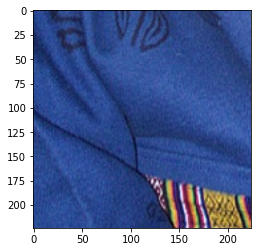

In [72]:
img = Image.open('/home/eeshangd/vision_env/LELImproved/dataset/test/VOCdevkit/VOC2007/JPEGImages/000001.jpg')
boxes, lablist = theon_sliding_window(img,resnet18)
draw = ImageDraw.Draw(img)
for box in boxes:
    draw.rectangle(((box[0], box[1]), (box[2], box[3])), fill="red")
img.show()

"Wait", says <b>Jon Snow</b>, "The predicted boxes may be too many and we can't deal with all of them. So, I myself will go and apply non_maximum_supression to reduce the number of boxes". You are free to choose the threshold value for non maximum supression, but choose wisely [0,1].

In [56]:
def aegon_targaryen_non_maximum_supression(boxes,lablist,threshold = 0.3):
    if len(boxes) == 0:
        return []

    pick = []
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    return (boxes[pick],lablist[pick])

Daenerys, the queen, then orders her army to test out the trained model on the test dataset.

In [57]:
def daenerys_test(resnet18):
    # Write loops for testing the model on the test set
    # Also print out the accuracy of the model
#     for images, labels, orig_images in test_loader:
    root_dir='/home/eeshangd/vision_env/LELImproved/dataset/'
    rdir = root_dir + 'test/VOCdevkit/VOC2007/'
    anotdir = rdir + 'Annotations/'
    imdir   = rdir + 'JPEGImages/'
    mapscore = []
    for filepath in glob.glob(anotdir+'*.xml'):
        tree = ET.parse(filepath)
        root = tree.getroot()
        filename = root.find('filename').text
        bboxarr = [[] for x in range(20)]
        #Loop on every object of the loop
        for objects in root.findall('object'):
            class_name = objects.find('name').text
            box_position = [int(objects.find('bndbox').find('xmin').text), \
                            int(objects.find('bndbox').find('ymin').text), \
                            int(objects.find('bndbox').find('xmax').text), \
                            int(objects.find('bndbox').find('ymax').text)]
            bboxarr[classes.index(class_name)-1].append(box_position)
        o_img = Image.open(imdir+filename)
        boxes,lablist = theon_sliding_window(o_img, resnet18)
        print(len(boxes))
        boxes,lablist = aegon_targaryen_non_maximum_supression(boxes,lablist)
        true_p = [0]*20
        false_p = [0]*20
        for ind in range(len(boxes)):
            clist = bboxarr[lablist[ind]-1]
            boxt = boxes[ind]
            none = True
            for boxB in clist:
                if bb_intersection_over_union(boxt, boxB)>0.5:
                    true_p[lablist[ind]-1]+=1
                    clist.remove(boxB)
                    none = False
                    break
            if none:
                false_p[lablist[ind]-1]+=1
        true_p  = np.array(true_p,dtype=float)
        false_p = np.array(false_p,dtype=float)
        mapscore.append(np.mean(true_p/(true_p+false_p)))
    print("mAP score is %d",np.mean(np.array(mapscore)))
                

In [58]:
%time daenerys_test(resnet18)

0


ValueError: need more than 0 values to unpack

# Final Showdown
After covering all the steps and passing the accuracy value to the talking crystal, they all pass through to the land of the living, with a wounded Jon Snow armed with the Dragon-axe. After a fierce battle, Jon Snow manages to go face to face with the Night king. Surrounded by battling men and falling bodies, they engage in a ferocious battle, a battle of spear and axe. After a raging fight, Jon manages to sink the axe into the Night king's heart, but not before he gets wounded by the spear. As dead men fall to bones, Daenerys and others rush to his aid, but it is too late. Everyone is in tears as they look towards the man of honour, Jon Snow, lying in Daenerys's arms when he says his last words: "The night has ended. Winter is finally over!"

In [7]:
print ("The night has ended. Winter is finally over!")

The night has ended. Winter is finally over!
